## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


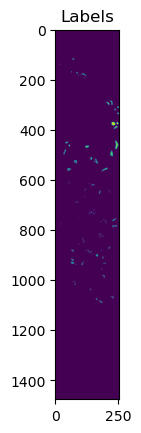

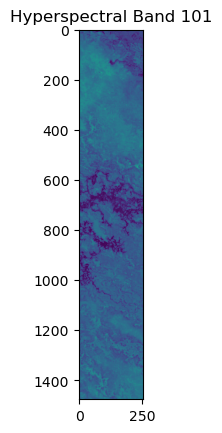

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(140, 5, 5, 145)
(70, 5, 5, 145)
(3038, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 140
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2211, PSNR: -9.4232


Epoch [1/50] Training Loss: 0.2129, PSNR: -8.6728
	[Val]   Batch [1/11] Loss: 0.2036, PSNR: -6.1259
	[Val]   Batch [10/11] Loss: 0.2038, PSNR: -8.3644
Epoch [1/50] Validation Loss: 0.2036, PSNR: -8.0566

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1976, PSNR: -10.4881


Epoch [2/50] Training Loss: 0.1907, PSNR: -8.1969
	[Val]   Batch [1/11] Loss: 0.1793, PSNR: -5.5728
	[Val]   Batch [10/11] Loss: 0.1795, PSNR: -7.8130
Epoch [2/50] Validation Loss: 0.1792, PSNR: -7.5007

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1771, PSNR: -8.9416


Epoch [3/50] Training Loss: 0.1697, PSNR: -7.7161
	[Val]   Batch [1/11] Loss: 0.1553, PSNR: -4.9499
	[Val]   Batch [10/11] Loss: 0.1555, PSNR: -7.1897
Epoch [3/50] Validation Loss: 0.1553, PSNR: -6.8807

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1563, PSNR: -9.4282


Epoch [4/50] Training Loss: 0.1495, PSNR: -7.3482
	[Val]   Batch [1/11] Loss: 0.1344, PSNR: -4.3197
	[Val]   Batch [10/11] Loss: 0.1344, PSNR: -6.5577
Epoch [4/50] Validation Loss: 0.1343, PSNR: -6.2488

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1356, PSNR: -7.2999


Epoch [5/50] Training Loss: 0.1304, PSNR: -6.5754
	[Val]   Batch [1/11] Loss: 0.1166, PSNR: -3.7032
	[Val]   Batch [10/11] Loss: 0.1166, PSNR: -5.9390
Epoch [5/50] Validation Loss: 0.1164, PSNR: -5.6294

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1187, PSNR: -6.7039


Epoch [6/50] Training Loss: 0.1128, PSNR: -6.0881
	[Val]   Batch [1/11] Loss: 0.0994, PSNR: -3.0100
	[Val]   Batch [10/11] Loss: 0.0994, PSNR: -5.2470
Epoch [6/50] Validation Loss: 0.0992, PSNR: -4.9354

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1030, PSNR: -4.7492


Epoch [7/50] Training Loss: 0.0972, PSNR: -5.3866
	[Val]   Batch [1/11] Loss: 0.0857, PSNR: -2.3686
	[Val]   Batch [10/11] Loss: 0.0857, PSNR: -4.6051
Epoch [7/50] Validation Loss: 0.0856, PSNR: -4.2951

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0880, PSNR: -3.7995


Epoch [8/50] Training Loss: 0.0835, PSNR: -4.6284
	[Val]   Batch [1/11] Loss: 0.0733, PSNR: -1.6891
	[Val]   Batch [10/11] Loss: 0.0733, PSNR: -3.9221
Epoch [8/50] Validation Loss: 0.0732, PSNR: -3.6140

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0749, PSNR: -4.6324


Epoch [9/50] Training Loss: 0.0719, PSNR: -4.0913
	[Val]   Batch [1/11] Loss: 0.0650, PSNR: -1.1674
	[Val]   Batch [10/11] Loss: 0.0650, PSNR: -3.3995
Epoch [9/50] Validation Loss: 0.0649, PSNR: -3.0920

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0654, PSNR: -4.6177


Epoch [10/50] Training Loss: 0.0621, PSNR: -3.5373
	[Val]   Batch [1/11] Loss: 0.0563, PSNR: -0.5457
	[Val]   Batch [10/11] Loss: 0.0563, PSNR: -2.7784
Epoch [10/50] Validation Loss: 0.0563, PSNR: -2.4701

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0560, PSNR: -2.0992


Epoch [11/50] Training Loss: 0.0540, PSNR: -2.8095
	[Val]   Batch [1/11] Loss: 0.0497, PSNR: 0.0026
	[Val]   Batch [10/11] Loss: 0.0496, PSNR: -2.2301
Epoch [11/50] Validation Loss: 0.0496, PSNR: -1.9213

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0496, PSNR: -1.9230


Epoch [12/50] Training Loss: 0.0473, PSNR: -2.2075
	[Val]   Batch [1/11] Loss: 0.0445, PSNR: 0.4820
	[Val]   Batch [10/11] Loss: 0.0444, PSNR: -1.7489
Epoch [12/50] Validation Loss: 0.0444, PSNR: -1.4425

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0440, PSNR: -1.4077


Epoch [13/50] Training Loss: 0.0417, PSNR: -1.5884
	[Val]   Batch [1/11] Loss: 0.0389, PSNR: 1.0677
	[Val]   Batch [10/11] Loss: 0.0388, PSNR: -1.1634
Epoch [13/50] Validation Loss: 0.0388, PSNR: -0.8568

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0390, PSNR: -0.8881


Epoch [14/50] Training Loss: 0.0370, PSNR: -1.3261
	[Val]   Batch [1/11] Loss: 0.0354, PSNR: 1.4783
	[Val]   Batch [10/11] Loss: 0.0353, PSNR: -0.7535
Epoch [14/50] Validation Loss: 0.0353, PSNR: -0.4462

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0345, PSNR: -2.1501


Epoch [15/50] Training Loss: 0.0331, PSNR: -0.6577
	[Val]   Batch [1/11] Loss: 0.0316, PSNR: 1.9666
	[Val]   Batch [10/11] Loss: 0.0316, PSNR: -0.2662
Epoch [15/50] Validation Loss: 0.0315, PSNR: 0.0423

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0309, PSNR: -0.8833


Epoch [16/50] Training Loss: 0.0297, PSNR: -0.2407
	[Val]   Batch [1/11] Loss: 0.0285, PSNR: 2.4094
	[Val]   Batch [10/11] Loss: 0.0285, PSNR: 0.1770
Epoch [16/50] Validation Loss: 0.0285, PSNR: 0.4855

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0277, PSNR: 0.9617


Epoch [17/50] Training Loss: 0.0269, PSNR: 0.1863
	[Val]   Batch [1/11] Loss: 0.0259, PSNR: 2.8231
	[Val]   Batch [10/11] Loss: 0.0259, PSNR: 0.5916
Epoch [17/50] Validation Loss: 0.0259, PSNR: 0.8990

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0250, PSNR: -0.3227


Epoch [18/50] Training Loss: 0.0244, PSNR: 0.5871
	[Val]   Batch [1/11] Loss: 0.0236, PSNR: 3.2352
	[Val]   Batch [10/11] Loss: 0.0236, PSNR: 1.0051
Epoch [18/50] Validation Loss: 0.0236, PSNR: 1.3111

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0233, PSNR: -1.2713


Epoch [19/50] Training Loss: 0.0223, PSNR: 1.0270
	[Val]   Batch [1/11] Loss: 0.0217, PSNR: 3.5907
	[Val]   Batch [10/11] Loss: 0.0217, PSNR: 1.3608
Epoch [19/50] Validation Loss: 0.0217, PSNR: 1.6670

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0208, PSNR: 3.7802


Epoch [20/50] Training Loss: 0.0204, PSNR: 1.5438
	[Val]   Batch [1/11] Loss: 0.0200, PSNR: 3.9451
	[Val]   Batch [10/11] Loss: 0.0200, PSNR: 1.7155
Epoch [20/50] Validation Loss: 0.0200, PSNR: 2.0222

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0197, PSNR: 4.0210


Epoch [21/50] Training Loss: 0.0188, PSNR: 1.6503
	[Val]   Batch [1/11] Loss: 0.0183, PSNR: 4.3480
	[Val]   Batch [10/11] Loss: 0.0182, PSNR: 2.1176
Epoch [21/50] Validation Loss: 0.0182, PSNR: 2.4256

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0178, PSNR: 4.4589


Epoch [22/50] Training Loss: 0.0174, PSNR: 2.1565
	[Val]   Batch [1/11] Loss: 0.0172, PSNR: 4.6159
	[Val]   Batch [10/11] Loss: 0.0171, PSNR: 2.3854
Epoch [22/50] Validation Loss: 0.0171, PSNR: 2.6930

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0164, PSNR: 1.8754


Epoch [23/50] Training Loss: 0.0161, PSNR: 2.2180
	[Val]   Batch [1/11] Loss: 0.0158, PSNR: 4.9835
	[Val]   Batch [10/11] Loss: 0.0158, PSNR: 2.7528
Epoch [23/50] Validation Loss: 0.0157, PSNR: 3.0609

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0152, PSNR: 0.6726


Epoch [24/50] Training Loss: 0.0150, PSNR: 2.6660
	[Val]   Batch [1/11] Loss: 0.0148, PSNR: 5.2739
	[Val]   Batch [10/11] Loss: 0.0147, PSNR: 3.0421
Epoch [24/50] Validation Loss: 0.0147, PSNR: 3.3512

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0147, PSNR: 3.6950


Epoch [25/50] Training Loss: 0.0139, PSNR: 2.8943
	[Val]   Batch [1/11] Loss: 0.0138, PSNR: 5.5608
	[Val]   Batch [10/11] Loss: 0.0138, PSNR: 3.3289
Epoch [25/50] Validation Loss: 0.0138, PSNR: 3.6386

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0130, PSNR: 2.8660


Epoch [26/50] Training Loss: 0.0130, PSNR: 3.3294
	[Val]   Batch [1/11] Loss: 0.0128, PSNR: 5.8776
	[Val]   Batch [10/11] Loss: 0.0128, PSNR: 3.6458
Epoch [26/50] Validation Loss: 0.0128, PSNR: 3.9559

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0122, PSNR: 3.2316


Epoch [27/50] Training Loss: 0.0122, PSNR: 3.8145
	[Val]   Batch [1/11] Loss: 0.0121, PSNR: 6.1315
	[Val]   Batch [10/11] Loss: 0.0121, PSNR: 3.9003
Epoch [27/50] Validation Loss: 0.0121, PSNR: 4.2102

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0113, PSNR: 6.4165


Epoch [28/50] Training Loss: 0.0114, PSNR: 3.9645
	[Val]   Batch [1/11] Loss: 0.0113, PSNR: 6.4182
	[Val]   Batch [10/11] Loss: 0.0113, PSNR: 4.1881
Epoch [28/50] Validation Loss: 0.0113, PSNR: 4.4974

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0111, PSNR: 2.2573


Epoch [29/50] Training Loss: 0.0107, PSNR: 4.1630
	[Val]   Batch [1/11] Loss: 0.0107, PSNR: 6.6796
	[Val]   Batch [10/11] Loss: 0.0107, PSNR: 4.4496
Epoch [29/50] Validation Loss: 0.0106, PSNR: 4.7591

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0101, PSNR: 4.5176


Epoch [30/50] Training Loss: 0.0101, PSNR: 4.3343
	[Val]   Batch [1/11] Loss: 0.0101, PSNR: 6.9367
	[Val]   Batch [10/11] Loss: 0.0100, PSNR: 4.7065
Epoch [30/50] Validation Loss: 0.0100, PSNR: 5.0169

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0094, PSNR: 5.3117


Epoch [31/50] Training Loss: 0.0095, PSNR: 4.7961
	[Val]   Batch [1/11] Loss: 0.0096, PSNR: 7.1294
	[Val]   Batch [10/11] Loss: 0.0096, PSNR: 4.8993
Epoch [31/50] Validation Loss: 0.0096, PSNR: 5.2090

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0092, PSNR: 4.5229


Epoch [32/50] Training Loss: 0.0090, PSNR: 4.8416
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4405
	[Val]   Batch [10/11] Loss: 0.0089, PSNR: 5.2111
Epoch [32/50] Validation Loss: 0.0089, PSNR: 5.5202

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0086, PSNR: 6.0418


Epoch [33/50] Training Loss: 0.0085, PSNR: 5.1192
	[Val]   Batch [1/11] Loss: 0.0085, PSNR: 7.6805
	[Val]   Batch [10/11] Loss: 0.0085, PSNR: 5.4499
Epoch [33/50] Validation Loss: 0.0085, PSNR: 5.7602

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0082, PSNR: 4.8749


Epoch [34/50] Training Loss: 0.0081, PSNR: 5.4133
	[Val]   Batch [1/11] Loss: 0.0082, PSNR: 7.8506
	[Val]   Batch [10/11] Loss: 0.0081, PSNR: 5.6207
Epoch [34/50] Validation Loss: 0.0081, PSNR: 5.9293

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0076, PSNR: 5.7280


Epoch [35/50] Training Loss: 0.0077, PSNR: 5.4443
	[Val]   Batch [1/11] Loss: 0.0077, PSNR: 8.1200
	[Val]   Batch [10/11] Loss: 0.0077, PSNR: 5.8904
Epoch [35/50] Validation Loss: 0.0076, PSNR: 6.1989

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0075, PSNR: 8.2122


Epoch [36/50] Training Loss: 0.0073, PSNR: 6.0186
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3311
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.1011
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.4102

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0070, PSNR: 7.1858


Epoch [37/50] Training Loss: 0.0069, PSNR: 6.1509
	[Val]   Batch [1/11] Loss: 0.0070, PSNR: 8.5229
	[Val]   Batch [10/11] Loss: 0.0070, PSNR: 6.2934
Epoch [37/50] Validation Loss: 0.0070, PSNR: 6.6022

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 8.7639


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.2374
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7393
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5096
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8191

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0064, PSNR: 6.9878


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.5323
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9453
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7154
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0249

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0063, PSNR: 6.7093


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.7385
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1640
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9342
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2442

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 7.4539


Epoch [41/50] Training Loss: 0.0058, PSNR: 6.8942
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3307
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.1012
Epoch [41/50] Validation Loss: 0.0058, PSNR: 7.4108

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0055, PSNR: 5.0809


Epoch [42/50] Training Loss: 0.0055, PSNR: 6.9453
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5238
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.2947
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6041

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 5.2526


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.2121
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.7058
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.4768
Epoch [43/50] Validation Loss: 0.0053, PSNR: 7.7866

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 7.8038


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.4086
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.8942
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6639
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9752

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 6.1124


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.4072
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0710
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8413
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.1523

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 10.1361


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.7513
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2673
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 8.0375
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.3484

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 8.5406


Epoch [47/50] Training Loss: 0.0045, PSNR: 8.1191
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4443
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.2158
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.5256

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 7.9846


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.1528
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6035
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.3756
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.6857

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 6.2702


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.2099
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.7930
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5661
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.8761

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0041, PSNR: 8.4520


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.3608
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9463
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.7192
Epoch [50/50] Validation Loss: 0.0040, PSNR: 9.0300


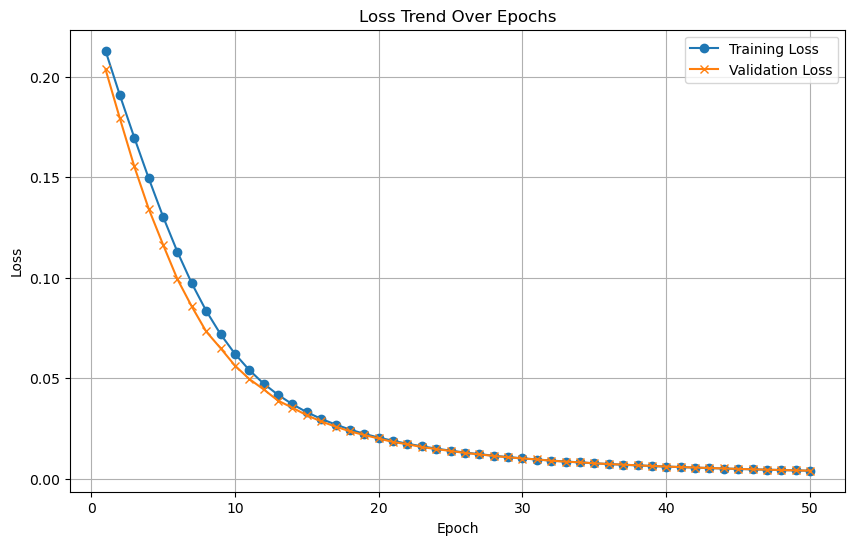

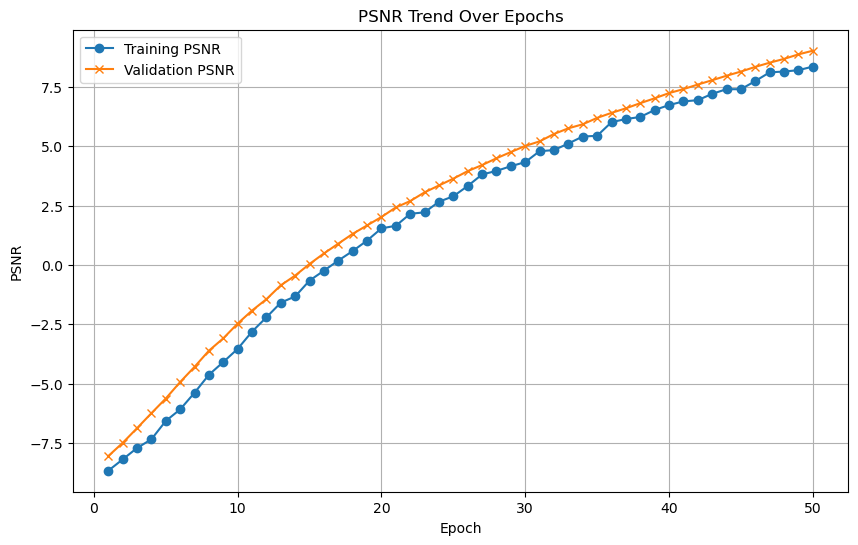

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6564
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6450. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6246
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6450. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5899
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6450. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5714
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6450. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

    Validation Batch [1/1], Loss: 2.6446
Validation Loss: 2.6446, Validation Accuracy: 7.14%
Validation loss improved from 2.6447 to 2.6446. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.4015
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss improved from 2.6446 to 2.6444. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.3910
    Validation Batch [1/1], Loss: 2.6442
Validation Loss: 2.6442, Validation Accuracy: 7.14%
Validation loss improved from 2.6444 to 2.6442. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.3904
    Validation Batch [1/1], Loss: 2.6441
Validation Loss: 2.6441, Validation Accuracy: 7.14%
Validation loss improved from 2.6442 to 2.6441. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.3794
    Validati

    Validation Batch [1/1], Loss: 2.6434
Validation Loss: 2.6434, Validation Accuracy: 7.14%
Validation loss improved from 2.6436 to 2.6434. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.3396
    Validation Batch [1/1], Loss: 2.6434
Validation Loss: 2.6434, Validation Accuracy: 7.14%
Validation loss improved from 2.6434 to 2.6434. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.3327
    Validation Batch [1/1], Loss: 2.6432
Validation Loss: 2.6432, Validation Accuracy: 7.14%
Validation loss improved from 2.6434 to 2.6432. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.3344
    Validation Batch [1/1], Loss: 2.6430
Validation Loss: 2.6430, Validation Accuracy: 7.14%
Validation loss improved from 2.6432 to 2.6430. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 2.3019
    Validati

Epoch [43/1000] completed, Average Training Loss: 2.1880
    Validation Batch [1/1], Loss: 2.6345
Validation Loss: 2.6345, Validation Accuracy: 7.14%
Validation loss improved from 2.6359 to 2.6345. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.1826
    Validation Batch [1/1], Loss: 2.6328
Validation Loss: 2.6328, Validation Accuracy: 7.14%
Validation loss improved from 2.6345 to 2.6328. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.1517
    Validation Batch [1/1], Loss: 2.6310
Validation Loss: 2.6310, Validation Accuracy: 7.14%
Validation loss improved from 2.6328 to 2.6310. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.1627
    Validation Batch [1/1], Loss: 2.6290
Validation Loss: 2.6290, Validation Accuracy: 7.14%
Validation loss improved from 2.6310 to 2.6290. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/10

Epoch [53/1000] completed, Average Training Loss: 2.0913
    Validation Batch [1/1], Loss: 2.6079
Validation Loss: 2.6079, Validation Accuracy: 7.14%
Validation loss improved from 2.6121 to 2.6079. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.0813
    Validation Batch [1/1], Loss: 2.6034
Validation Loss: 2.6034, Validation Accuracy: 7.14%
Validation loss improved from 2.6079 to 2.6034. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.0743
    Validation Batch [1/1], Loss: 2.5982
Validation Loss: 2.5982, Validation Accuracy: 7.14%
Validation loss improved from 2.6034 to 2.5982. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.0513
    Validation Batch [1/1], Loss: 2.5938
Validation Loss: 2.5938, Validation Accuracy: 7.14%
Validation loss improved from 2.5982 to 2.5938. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/10

Epoch [70/1000] completed, Average Training Loss: 1.9492
    Validation Batch [1/1], Loss: 2.4562
Validation Loss: 2.4562, Validation Accuracy: 20.00%
Validation loss improved from 2.4727 to 2.4562. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.9389
    Validation Batch [1/1], Loss: 2.4388
Validation Loss: 2.4388, Validation Accuracy: 24.29%
Validation loss improved from 2.4562 to 2.4388. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.9609
    Validation Batch [1/1], Loss: 2.4205
Validation Loss: 2.4205, Validation Accuracy: 27.14%
Validation loss improved from 2.4388 to 2.4205. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 1.9317
    Validation Batch [1/1], Loss: 2.4011
Validation Loss: 2.4011, Validation Accuracy: 28.57%
Validation loss improved from 2.4205 to 2.4011. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 2.2487
Validation Loss: 2.2487, Validation Accuracy: 54.29%
Validation loss improved from 2.2721 to 2.2487. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.8659
    Validation Batch [1/1], Loss: 2.2270
Validation Loss: 2.2270, Validation Accuracy: 55.71%
Validation loss improved from 2.2487 to 2.2270. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.8534
    Validation Batch [1/1], Loss: 2.2040
Validation Loss: 2.2040, Validation Accuracy: 55.71%
Validation loss improved from 2.2270 to 2.2040. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.8823
    Validation Batch [1/1], Loss: 2.1784
Validation Loss: 2.1784, Validation Accuracy: 58.57%
Validation loss improved from 2.2040 to 2.1784. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.8479
    Vali

Epoch [96/1000] completed, Average Training Loss: 1.7353
    Validation Batch [1/1], Loss: 1.9311
Validation Loss: 1.9311, Validation Accuracy: 71.43%
Validation loss improved from 1.9362 to 1.9311. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.7689
    Validation Batch [1/1], Loss: 1.9051
Validation Loss: 1.9051, Validation Accuracy: 68.57%
Validation loss improved from 1.9311 to 1.9051. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.7603
    Validation Batch [1/1], Loss: 1.8904
Validation Loss: 1.8904, Validation Accuracy: 68.57%
Validation loss improved from 1.9051 to 1.8904. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.7295
    Validation Batch [1/1], Loss: 1.8778
Validation Loss: 1.8778, Validation Accuracy: 70.00%
Validation loss improved from 1.8904 to 1.8778. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [

    Validation Batch [1/1], Loss: 1.8241
Validation Loss: 1.8241, Validation Accuracy: 71.43%
Validation loss improved from 1.8281 to 1.8241. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.6711
    Validation Batch [1/1], Loss: 1.8091
Validation Loss: 1.8091, Validation Accuracy: 71.43%
Validation loss improved from 1.8241 to 1.8091. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.6927
    Validation Batch [1/1], Loss: 1.7833
Validation Loss: 1.7833, Validation Accuracy: 71.43%
Validation loss improved from 1.8091 to 1.7833. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.6490
    Validation Batch [1/1], Loss: 1.7715
Validation Loss: 1.7715, Validation Accuracy: 70.00%
Validation loss improved from 1.7833 to 1.7715. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.7011


Epoch [122/1000] completed, Average Training Loss: 1.5439
    Validation Batch [1/1], Loss: 1.6475
Validation Loss: 1.6475, Validation Accuracy: 72.86%
Validation loss improved from 1.6489 to 1.6475. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.5200
    Validation Batch [1/1], Loss: 1.6665
Validation Loss: 1.6665, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.5623
    Validation Batch [1/1], Loss: 1.6515
Validation Loss: 1.6515, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.5578
    Validation Batch [1/1], Loss: 1.6105
Validation Loss: 1.6105, Validation Accuracy: 71.43%
Validation loss improved from 1.6475 to 1.6105. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Av

Epoch [129/1000] completed, Average Training Loss: 1.4908
    Validation Batch [1/1], Loss: 1.5810
Validation Loss: 1.5810, Validation Accuracy: 75.71%
Validation loss improved from 1.5925 to 1.5810. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 1.4989
    Validation Batch [1/1], Loss: 1.5788
Validation Loss: 1.5788, Validation Accuracy: 74.29%
Validation loss improved from 1.5810 to 1.5788. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.4965
    Validation Batch [1/1], Loss: 1.5929
Validation Loss: 1.5929, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.4508
    Validation Batch [1/1], Loss: 1.5622
Validation Loss: 1.5622, Validation Accuracy: 75.71%
Validation loss improved from 1.5788 to 1.5622. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000

    Validation Batch [1/1], Loss: 1.4815
Validation Loss: 1.4815, Validation Accuracy: 77.14%
Validation loss improved from 1.4922 to 1.4815. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.3751
    Validation Batch [1/1], Loss: 1.4521
Validation Loss: 1.4521, Validation Accuracy: 74.29%
Validation loss improved from 1.4815 to 1.4521. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.3845
    Validation Batch [1/1], Loss: 1.4560
Validation Loss: 1.4560, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.3572
    Validation Batch [1/1], Loss: 1.4627
Validation Loss: 1.4627, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.3207
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.4012
Validation Loss: 1.4012, Validation Accuracy: 80.00%
Validation loss improved from 1.4040 to 1.4012. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.2875
    Validation Batch [1/1], Loss: 1.3902
Validation Loss: 1.3902, Validation Accuracy: 80.00%
Validation loss improved from 1.4012 to 1.3902. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.3073
    Validation Batch [1/1], Loss: 1.3710
Validation Loss: 1.3710, Validation Accuracy: 80.00%
Validation loss improved from 1.3902 to 1.3710. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.2935
    Validation Batch [1/1], Loss: 1.3599
Validation Loss: 1.3599, Validation Accuracy: 82.86%
Validation loss improved from 1.3710 to 1.3599. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.2991


Epoch [172/1000] completed, Average Training Loss: 1.1770
    Validation Batch [1/1], Loss: 1.2721
Validation Loss: 1.2721, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.1722
    Validation Batch [1/1], Loss: 1.2628
Validation Loss: 1.2628, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.1453
    Validation Batch [1/1], Loss: 1.2717
Validation Loss: 1.2717, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.1558
    Validation Batch [1/1], Loss: 1.2310
Validation Loss: 1.2310, Validation Accuracy: 87.14%
Validation loss improved from 1.2578 to 1.2310. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training 

Epoch [182/1000] completed, Average Training Loss: 1.0901
    Validation Batch [1/1], Loss: 1.1578
Validation Loss: 1.1578, Validation Accuracy: 84.29%
Validation loss improved from 1.1805 to 1.1578. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.1131
    Validation Batch [1/1], Loss: 1.1472
Validation Loss: 1.1472, Validation Accuracy: 84.29%
Validation loss improved from 1.1578 to 1.1472. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 1.0709
    Validation Batch [1/1], Loss: 1.1474
Validation Loss: 1.1474, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 1.0398
    Validation Batch [1/1], Loss: 1.1560
Validation Loss: 1.1560, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Av

Epoch [199/1000] completed, Average Training Loss: 0.9435
    Validation Batch [1/1], Loss: 1.0510
Validation Loss: 1.0510, Validation Accuracy: 88.57%
Validation loss improved from 1.0599 to 1.0510. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.9491
    Validation Batch [1/1], Loss: 1.0462
Validation Loss: 1.0462, Validation Accuracy: 91.43%
Validation loss improved from 1.0510 to 1.0462. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.9690
    Validation Batch [1/1], Loss: 1.0370
Validation Loss: 1.0370, Validation Accuracy: 88.57%
Validation loss improved from 1.0462 to 1.0370. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.9579
    Validation Batch [1/1], Loss: 1.0335
Validation Loss: 1.0335, Validation Accuracy: 88.57%
Validation loss improved from 1.0370 to 1.0335. Saving model...

LOG: Epoch [203/1000] - Training


Epoch [209/1000] completed, Average Training Loss: 0.9640
    Validation Batch [1/1], Loss: 0.9820
Validation Loss: 0.9820, Validation Accuracy: 91.43%
Validation loss improved from 0.9906 to 0.9820. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.9362
    Validation Batch [1/1], Loss: 0.9815
Validation Loss: 0.9815, Validation Accuracy: 91.43%
Validation loss improved from 0.9820 to 0.9815. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.9181
    Validation Batch [1/1], Loss: 0.9719
Validation Loss: 0.9719, Validation Accuracy: 91.43%
Validation loss improved from 0.9815 to 0.9719. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.8777
    Validation Batch [1/1], Loss: 0.9599
Validation Loss: 0.9599, Validation Accuracy: 87.14%
Validation loss improved from 0.9719 to 0.9599. Saving model...

LOG: Epoch [213/1000] - Training


Epoch [225/1000] completed, Average Training Loss: 0.7804
    Validation Batch [1/1], Loss: 0.8854
Validation Loss: 0.8854, Validation Accuracy: 90.00%
Validation loss improved from 0.8880 to 0.8854. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.7734
    Validation Batch [1/1], Loss: 0.8761
Validation Loss: 0.8761, Validation Accuracy: 88.57%
Validation loss improved from 0.8854 to 0.8761. Saving model...

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.7680
    Validation Batch [1/1], Loss: 0.8603
Validation Loss: 0.8603, Validation Accuracy: 90.00%
Validation loss improved from 0.8761 to 0.8603. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.7501
    Validation Batch [1/1], Loss: 0.8394
Validation Loss: 0.8394, Validation Accuracy: 94.29%
Validation loss improved from 0.8603 to 0.8394. Saving model...

LOG: Epoch [229/1000] - Training


    Validation Batch [1/1], Loss: 0.8306
Validation Loss: 0.8306, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.7414
    Validation Batch [1/1], Loss: 0.8347
Validation Loss: 0.8347, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7145
    Validation Batch [1/1], Loss: 0.8045
Validation Loss: 0.8045, Validation Accuracy: 94.29%
Validation loss improved from 0.8265 to 0.8045. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7581
    Validation Batch [1/1], Loss: 0.8084
Validation Loss: 0.8084, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7427
    Validation Batch [1/1], Loss: 0.8243
Vali

Epoch [253/1000] completed, Average Training Loss: 0.6265
    Validation Batch [1/1], Loss: 0.7145
Validation Loss: 0.7145, Validation Accuracy: 94.29%
Validation loss improved from 0.7243 to 0.7145. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.6024
    Validation Batch [1/1], Loss: 0.7147
Validation Loss: 0.7147, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.6127
    Validation Batch [1/1], Loss: 0.7303
Validation Loss: 0.7303, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.5690
    Validation Batch [1/1], Loss: 0.7299
Validation Loss: 0.7299, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.6785
Validation Loss: 0.6785, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.6054
    Validation Batch [1/1], Loss: 0.6719
Validation Loss: 0.6719, Validation Accuracy: 94.29%
Validation loss improved from 0.6731 to 0.6719. Saving model...

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.5438
    Validation Batch [1/1], Loss: 0.6562
Validation Loss: 0.6562, Validation Accuracy: 94.29%
Validation loss improved from 0.6719 to 0.6562. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.5563
    Validation Batch [1/1], Loss: 0.6462
Validation Loss: 0.6462, Validation Accuracy: 94.29%
Validation loss improved from 0.6562 to 0.6462. Saving model...

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.5503
    Validation 

Epoch [280/1000] completed, Average Training Loss: 0.4980
    Validation Batch [1/1], Loss: 0.5909
Validation Loss: 0.5909, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4035
    Validation Batch [1/1], Loss: 0.5743
Validation Loss: 0.5743, Validation Accuracy: 94.29%
Validation loss improved from 0.5871 to 0.5743. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4634
    Validation Batch [1/1], Loss: 0.5707
Validation Loss: 0.5707, Validation Accuracy: 94.29%
Validation loss improved from 0.5743 to 0.5707. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.4405
    Validation Batch [1/1], Loss: 0.5882
Validation Loss: 0.5882, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5604
Validation Loss: 0.5604, Validation Accuracy: 92.86%
Validation loss improved from 0.5607 to 0.5604. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.4339
    Validation Batch [1/1], Loss: 0.5712
Validation Loss: 0.5712, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.4822
    Validation Batch [1/1], Loss: 0.5582
Validation Loss: 0.5582, Validation Accuracy: 92.86%
Validation loss improved from 0.5604 to 0.5582. Saving model...

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.4425
    Validation Batch [1/1], Loss: 0.5330
Validation Loss: 0.5330, Validation Accuracy: 92.86%
Validation loss improved from 0.5582 to 0.5330. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4344
    Validation 

Epoch [306/1000] completed, Average Training Loss: 0.3963
    Validation Batch [1/1], Loss: 0.4773
Validation Loss: 0.4773, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.3874
    Validation Batch [1/1], Loss: 0.4663
Validation Loss: 0.4663, Validation Accuracy: 92.86%
Validation loss improved from 0.4762 to 0.4663. Saving model...

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.3734
    Validation Batch [1/1], Loss: 0.4634
Validation Loss: 0.4634, Validation Accuracy: 92.86%
Validation loss improved from 0.4663 to 0.4634. Saving model...

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.3545
    Validation Batch [1/1], Loss: 0.4749
Validation Loss: 0.4749, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Av

Epoch [312/1000] completed, Average Training Loss: 0.3550
    Validation Batch [1/1], Loss: 0.4582
Validation Loss: 0.4582, Validation Accuracy: 92.86%
Validation loss improved from 0.4634 to 0.4582. Saving model...

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.3717
    Validation Batch [1/1], Loss: 0.4511
Validation Loss: 0.4511, Validation Accuracy: 92.86%
Validation loss improved from 0.4582 to 0.4511. Saving model...

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3818
    Validation Batch [1/1], Loss: 0.4583
Validation Loss: 0.4583, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3506
    Validation Batch [1/1], Loss: 0.4862
Validation Loss: 0.4862, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Av

Epoch [332/1000] completed, Average Training Loss: 0.3007
    Validation Batch [1/1], Loss: 0.4094
Validation Loss: 0.4094, Validation Accuracy: 92.86%
Validation loss improved from 0.4192 to 0.4094. Saving model...

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.3040
    Validation Batch [1/1], Loss: 0.4085
Validation Loss: 0.4085, Validation Accuracy: 92.86%
Validation loss improved from 0.4094 to 0.4085. Saving model...

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.3002
    Validation Batch [1/1], Loss: 0.4098
Validation Loss: 0.4098, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.2524
    Validation Batch [1/1], Loss: 0.4224
Validation Loss: 0.4224, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [336/1000] - Training


Epoch [336/1000] completed, Average Training Loss: 0.2905
    Validation Batch [1/1], Loss: 0.4148
Validation Loss: 0.4148, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.2781
    Validation Batch [1/1], Loss: 0.3977
Validation Loss: 0.3977, Validation Accuracy: 92.86%
Validation loss improved from 0.4085 to 0.3977. Saving model...

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2737
    Validation Batch [1/1], Loss: 0.4051
Validation Loss: 0.4051, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2817
    Validation Batch [1/1], Loss: 0.4089
Validation Loss: 0.4089, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.3715
Validation Loss: 0.3715, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.2148
    Validation Batch [1/1], Loss: 0.3736
Validation Loss: 0.3736, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.2217
    Validation Batch [1/1], Loss: 0.3643
Validation Loss: 0.3643, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.2122
    Validation Batch [1/1], Loss: 0.3602
Validation Loss: 0.3602, Validation Accuracy: 92.86%
Validation loss improved from 0.3630 to 0.3602. Saving model...

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2482
    Validation Batch [1/1], Loss: 0.3591
Vali

Epoch [388/1000] completed, Average Training Loss: 0.1823
    Validation Batch [1/1], Loss: 0.3022
Validation Loss: 0.3022, Validation Accuracy: 92.86%
Validation loss improved from 0.3037 to 0.3022. Saving model...

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.2014
    Validation Batch [1/1], Loss: 0.3078
Validation Loss: 0.3078, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1693
    Validation Batch [1/1], Loss: 0.3253
Validation Loss: 0.3253, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.2165
    Validation Batch [1/1], Loss: 0.3006
Validation Loss: 0.3006, Validation Accuracy: 92.86%
Validation loss improved from 0.3022 to 0.3006. Saving model...

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Av

Epoch [415/1000] completed, Average Training Loss: 0.1787
    Validation Batch [1/1], Loss: 0.2744
Validation Loss: 0.2744, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1528
    Validation Batch [1/1], Loss: 0.2849
Validation Loss: 0.2849, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1819
    Validation Batch [1/1], Loss: 0.2850
Validation Loss: 0.2850, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1275
    Validation Batch [1/1], Loss: 0.2823
Validation Loss: 0.2823, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1589
  

Epoch [443/1000] completed, Average Training Loss: 0.1434
    Validation Batch [1/1], Loss: 0.2749
Validation Loss: 0.2749, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1387
    Validation Batch [1/1], Loss: 0.2614
Validation Loss: 0.2614, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1048
    Validation Batch [1/1], Loss: 0.2495
Validation Loss: 0.2495, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1483
    Validation Batch [1/1], Loss: 0.2470
Validation Loss: 0.2470, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1169
  

    Validation Batch [1/1], Loss: 0.2283
Validation Loss: 0.2283, Validation Accuracy: 94.29%
Validation loss improved from 0.2314 to 0.2283. Saving model...

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1202
    Validation Batch [1/1], Loss: 0.2274
Validation Loss: 0.2274, Validation Accuracy: 94.29%
Validation loss improved from 0.2283 to 0.2274. Saving model...

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1024
    Validation Batch [1/1], Loss: 0.2362
Validation Loss: 0.2362, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1017
    Validation Batch [1/1], Loss: 0.2548
Validation Loss: 0.2548, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.0983
    Validation Batch [1/1], Lo

Epoch [498/1000] completed, Average Training Loss: 0.0999
    Validation Batch [1/1], Loss: 0.2297
Validation Loss: 0.2297, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.1048
    Validation Batch [1/1], Loss: 0.2171
Validation Loss: 0.2171, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0795
    Validation Batch [1/1], Loss: 0.2160
Validation Loss: 0.2160, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0911
    Validation Batch [1/1], Loss: 0.2124
Validation Loss: 0.2124, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1054
  

Epoch [525/1000] completed, Average Training Loss: 0.0714
    Validation Batch [1/1], Loss: 0.2107
Validation Loss: 0.2107, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0729
    Validation Batch [1/1], Loss: 0.2054
Validation Loss: 0.2054, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0988
    Validation Batch [1/1], Loss: 0.2054
Validation Loss: 0.2054, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.2378
Validation Loss: 0.2378, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.081

    Validation Batch [1/1], Loss: 0.1956
Validation Loss: 0.1956, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0751
    Validation Batch [1/1], Loss: 0.1998
Validation Loss: 0.1998, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0804
    Validation Batch [1/1], Loss: 0.2007
Validation Loss: 0.2007, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0825
    Validation Batch [1/1], Loss: 0.2053
Validation Loss: 0.2053, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 0.2162
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.1747
Validation Loss: 0.1747, Validation Accuracy: 92.86%
Validation loss improved from 0.1773 to 0.1747. Saving model...

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.1813
Validation Loss: 0.1813, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.1884
Validation Loss: 0.1884, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.1919
Validation Loss: 0.1919, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 0.1915
Vali

Epoch [608/1000] completed, Average Training Loss: 0.0597
    Validation Batch [1/1], Loss: 0.2253
Validation Loss: 0.2253, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.2068
Validation Loss: 0.2068, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.1896
Validation Loss: 0.1896, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.1971
Validation Loss: 0.1971, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0617


Epoch [636/1000] completed, Average Training Loss: 0.0588
    Validation Batch [1/1], Loss: 0.1822
Validation Loss: 0.1822, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0687
    Validation Batch [1/1], Loss: 0.1825
Validation Loss: 0.1825, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.1993
Validation Loss: 0.1993, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0524
    Validation Batch [1/1], Loss: 0.2131
Validation Loss: 0.2131, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0511
  

Epoch [663/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.2199
Validation Loss: 0.2199, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.2148
Validation Loss: 0.2148, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.2026
Validation Loss: 0.2026, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0636
    Validation Batch [1/1], Loss: 0.1907
Validation Loss: 0.1907, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.044

    Validation Batch [1/1], Loss: 0.1864
Validation Loss: 0.1864, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0612
    Validation Batch [1/1], Loss: 0.2096
Validation Loss: 0.2096, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.2278
Validation Loss: 0.2278, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.2030
Validation Loss: 0.2030, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0353
    Validation Batch [1/1], Loss: 0.1781
Validation Loss

Epoch [719/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.1601
Validation Loss: 0.1601, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.1577
Validation Loss: 0.1577, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.1588
Validation Loss: 0.1588, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1], Loss: 0.1630
Validation Loss: 0.1630, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [723/1000] - Training
Epoch [723/1000] completed, Average Training Loss: 0.041

Epoch [746/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.1659
Validation Loss: 0.1659, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0482
    Validation Batch [1/1], Loss: 0.1666
Validation Loss: 0.1666, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.1677
Validation Loss: 0.1677, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [749/1000] - Training
Epoch [749/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.1670
Validation Loss: 0.1670, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [750/1000] - Training
Epoch [750/1000] completed, Average Training Loss: 0.0318
  

Epoch [774/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.1839
Validation Loss: 0.1839, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [775/1000] - Training
Epoch [775/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.2043
Validation Loss: 0.2043, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [776/1000] - Training
Epoch [776/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.2050
Validation Loss: 0.2050, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [777/1000] - Training
Epoch [777/1000] completed, Average Training Loss: 0.0381
    Validation Batch [1/1], Loss: 0.1897
Validation Loss: 0.1897, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [778/1000] - Training
Epoch [778/1000] completed, Average Training Loss: 0.0417
  

Epoch [802/1000] completed, Average Training Loss: 0.0309
    Validation Batch [1/1], Loss: 0.1461
Validation Loss: 0.1461, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [803/1000] - Training
Epoch [803/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.1424
Validation Loss: 0.1424, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [804/1000] - Training
Epoch [804/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.1469
Validation Loss: 0.1469, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [805/1000] - Training
Epoch [805/1000] completed, Average Training Loss: 0.0287
    Validation Batch [1/1], Loss: 0.1546
Validation Loss: 0.1546, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.030

Epoch [831/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.1485
Validation Loss: 0.1485, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [832/1000] - Training
Epoch [832/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.1481
Validation Loss: 0.1481, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [833/1000] - Training
Epoch [833/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.1478
Validation Loss: 0.1478, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [834/1000] - Training
Epoch [834/1000] completed, Average Training Loss: 0.0265
    Validation Batch [1/1], Loss: 0.1494
Validation Loss: 0.1494, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [835/1000] - Training
Epoch [835/1000] completed, Average Training Loss: 0.035

Epoch [859/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.1484
Validation Loss: 0.1484, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [860/1000] - Training
Epoch [860/1000] completed, Average Training Loss: 0.0273
    Validation Batch [1/1], Loss: 0.1469
Validation Loss: 0.1469, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [861/1000] - Training
Epoch [861/1000] completed, Average Training Loss: 0.0223
    Validation Batch [1/1], Loss: 0.1523
Validation Loss: 0.1523, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [862/1000] - Training
Epoch [862/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.1541
Validation Loss: 0.1541, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [863/1000] - Training
Epoch [863/1000] completed, Average Training Loss: 0.025

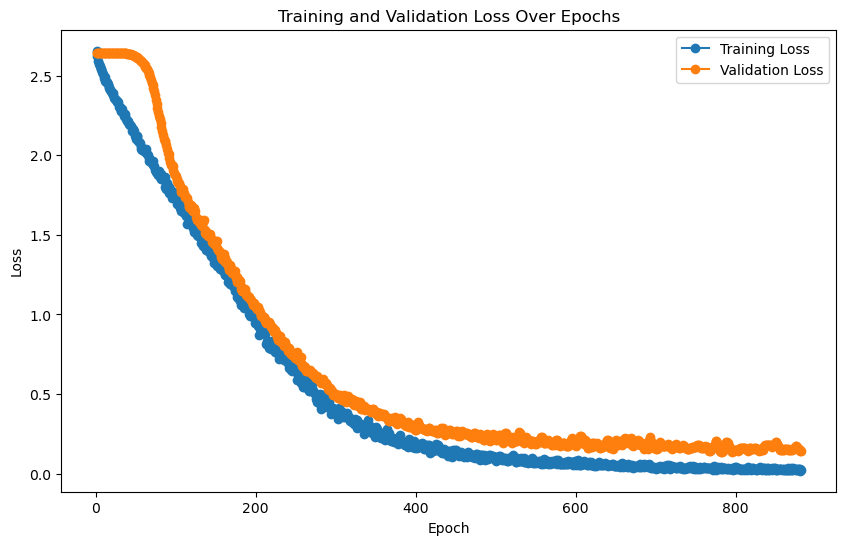

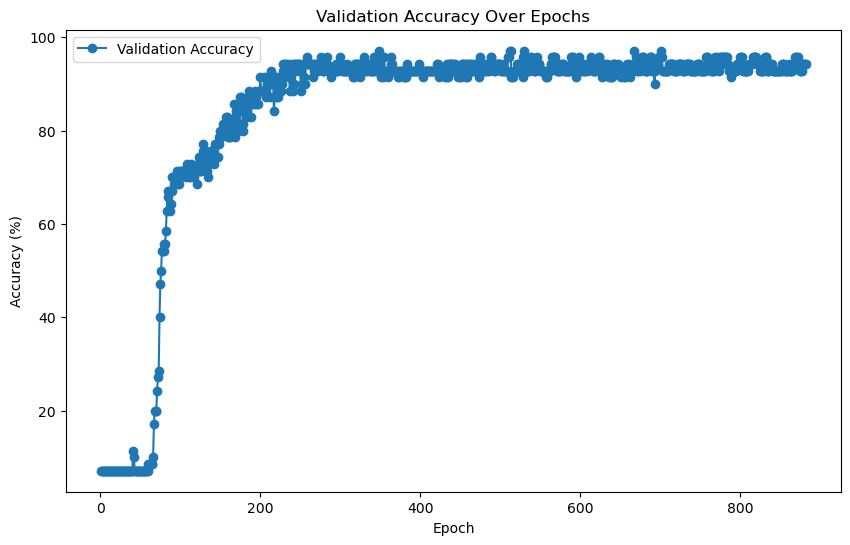


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0788

Final Test Loss: 0.1700, Test Accuracy: 94.63%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)

LOG: Training features shape: (140, 64), Training labels shape: (140,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3038, 64), Test labels shape: (3038,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 65.71%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...


LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)
Train reps shape: (140, 64)
Train labels shape: (140,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3038, 64)
Test labels shape: (3038,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7609  |  Val Loss: 2.6763
Validation loss improved from inf to 2.6763.
[Epoch 2/1000] Train Loss: 2.6743  |  Val Loss: 2.6564
Validation loss improved from 2.6763 to 2.6564.
[Epoch 3/1000] Train Loss: 2.6552  |  Val Loss: 2.6472
Validation loss improved from 2.6564 to 2.6472.
[Epoch 4/1000] Train Loss: 2.6475  |  Val Loss: 2.6400
Validation loss improved from 2.6472 to 2.6400.
[Epoch 5/1000] Train Loss: 2.6408  |  Val Loss: 2.6312
Validation loss improved from 2.6400 to 2.6312.
[Epoch 6/1000] Train Loss: 2.6307  |  Val Loss: 2.6246
Validation loss improved from 2.6312 to 2.6246.
[Epoch 7/1000] Train Loss: 2.6269  |  Val Loss: 2.6222
Validation loss improved from 2.6246 to 2.6222.
[Epoch 8/1000] Train Loss: 2.6227  |  Val Loss: 2.6185
Validation loss improved from 2.6222 to 2.6185.
[Epoch 9/1000] Train Loss: 2.6194  |  Val Loss: 2.6150
Validation loss improved from 2.6185 to 2.6150.
[Epoch 10/1000] Train Loss: 2.6157  |  Val Loss: 2.6106
Validation loss impr

[Epoch 23/1000] Train Loss: 2.5357  |  Val Loss: 2.5254
Validation loss improved from 2.5380 to 2.5254.
[Epoch 24/1000] Train Loss: 2.5192  |  Val Loss: 2.5122
Validation loss improved from 2.5254 to 2.5122.
[Epoch 25/1000] Train Loss: 2.5050  |  Val Loss: 2.5026
Validation loss improved from 2.5122 to 2.5026.
[Epoch 26/1000] Train Loss: 2.4942  |  Val Loss: 2.4920
Validation loss improved from 2.5026 to 2.4920.
[Epoch 27/1000] Train Loss: 2.4836  |  Val Loss: 2.4819
Validation loss improved from 2.4920 to 2.4819.
[Epoch 28/1000] Train Loss: 2.4725  |  Val Loss: 2.4711
Validation loss improved from 2.4819 to 2.4711.
[Epoch 29/1000] Train Loss: 2.4640  |  Val Loss: 2.4614
Validation loss improved from 2.4711 to 2.4614.
[Epoch 30/1000] Train Loss: 2.4520  |  Val Loss: 2.4483
Validation loss improved from 2.4614 to 2.4483.
[Epoch 31/1000] Train Loss: 2.4372  |  Val Loss: 2.4359
Validation loss improved from 2.4483 to 2.4359.


[Epoch 32/1000] Train Loss: 2.4219  |  Val Loss: 2.4158
Validation loss improved from 2.4359 to 2.4158.
[Epoch 33/1000] Train Loss: 2.4026  |  Val Loss: 2.4022
Validation loss improved from 2.4158 to 2.4022.
[Epoch 34/1000] Train Loss: 2.3891  |  Val Loss: 2.3840
Validation loss improved from 2.4022 to 2.3840.
[Epoch 35/1000] Train Loss: 2.3752  |  Val Loss: 2.3741
Validation loss improved from 2.3840 to 2.3741.
[Epoch 36/1000] Train Loss: 2.3543  |  Val Loss: 2.3530
Validation loss improved from 2.3741 to 2.3530.
[Epoch 37/1000] Train Loss: 2.3420  |  Val Loss: 2.3384
Validation loss improved from 2.3530 to 2.3384.
[Epoch 38/1000] Train Loss: 2.3200  |  Val Loss: 2.3158
Validation loss improved from 2.3384 to 2.3158.
[Epoch 39/1000] Train Loss: 2.3016  |  Val Loss: 2.3153
Validation loss improved from 2.3158 to 2.3153.
[Epoch 40/1000] Train Loss: 2.2951  |  Val Loss: 2.2811
Validation loss improved from 2.3153 to 2.2811.
[Epoch 41/1000] Train Loss: 2.2546  |  Val Loss: 2.2641
Validati

[Epoch 52/1000] Train Loss: 2.0042  |  Val Loss: 2.0133
Validation loss improved from 2.0385 to 2.0133.
[Epoch 53/1000] Train Loss: 1.9844  |  Val Loss: 1.9852
Validation loss improved from 2.0133 to 1.9852.
[Epoch 54/1000] Train Loss: 1.9514  |  Val Loss: 1.9681
Validation loss improved from 1.9852 to 1.9681.
[Epoch 55/1000] Train Loss: 1.9346  |  Val Loss: 1.9423
Validation loss improved from 1.9681 to 1.9423.
[Epoch 56/1000] Train Loss: 1.9053  |  Val Loss: 1.9252
Validation loss improved from 1.9423 to 1.9252.
[Epoch 57/1000] Train Loss: 1.8905  |  Val Loss: 1.8941
Validation loss improved from 1.9252 to 1.8941.
[Epoch 58/1000] Train Loss: 1.8625  |  Val Loss: 1.8652
Validation loss improved from 1.8941 to 1.8652.
[Epoch 59/1000] Train Loss: 1.8505  |  Val Loss: 1.8524
Validation loss improved from 1.8652 to 1.8524.
[Epoch 60/1000] Train Loss: 1.8212  |  Val Loss: 1.8702
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 61/1000] Train Loss: 1.8299  |  Val Loss: 1.8161
Validation loss improved from 1.8524 to 1.8161.
[Epoch 62/1000] Train Loss: 1.7886  |  Val Loss: 1.7930
Validation loss improved from 1.8161 to 1.7930.
[Epoch 63/1000] Train Loss: 1.7589  |  Val Loss: 1.7736
Validation loss improved from 1.7930 to 1.7736.
[Epoch 64/1000] Train Loss: 1.7408  |  Val Loss: 1.7837
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 1.7485  |  Val Loss: 1.7444
Validation loss improved from 1.7736 to 1.7444.
[Epoch 66/1000] Train Loss: 1.7020  |  Val Loss: 1.7808
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 67/1000] Train Loss: 1.7385  |  Val Loss: 1.7102
Validation loss improved from 1.7444 to 1.7102.
[Epoch 68/1000] Train Loss: 1.6749  |  Val Loss: 1.6862
Validation loss improved from 1.7102 to 1.6862.
[Epoch 69/1000] Train Loss: 1.6532  |  Val Loss: 1.6733
Validation loss improved from 1.6862 to 1.6733.
[Epoch 70/1000] Train Loss: 1.6297  |  Val Loss: 1.6

[Epoch 83/1000] Train Loss: 1.4778  |  Val Loss: 1.5086
Validation loss improved from 1.5232 to 1.5086.
[Epoch 84/1000] Train Loss: 1.4593  |  Val Loss: 1.5172
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 85/1000] Train Loss: 1.4666  |  Val Loss: 1.4951
Validation loss improved from 1.5086 to 1.4951.
[Epoch 86/1000] Train Loss: 1.4405  |  Val Loss: 1.4727
Validation loss improved from 1.4951 to 1.4727.
[Epoch 87/1000] Train Loss: 1.4243  |  Val Loss: 1.4769
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 1.4256  |  Val Loss: 1.4813
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 89/1000] Train Loss: 1.4252  |  Val Loss: 1.4732
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 90/1000] Train Loss: 1.4123  |  Val Loss: 1.4601
Validation loss improved from 1.4727 to 1.4601.
[Epoch 91/1000] Train Loss: 1.4038  |  Val Loss: 1.4548
Validation loss improved from 1.4601 to 1.4548.


[Epoch 92/1000] Train Loss: 1.4030  |  Val Loss: 1.4531
Validation loss improved from 1.4548 to 1.4531.
[Epoch 93/1000] Train Loss: 1.3780  |  Val Loss: 1.4690
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 1.4071  |  Val Loss: 1.4823
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train Loss: 1.4337  |  Val Loss: 1.4202
Validation loss improved from 1.4531 to 1.4202.
[Epoch 96/1000] Train Loss: 1.3722  |  Val Loss: 1.4646
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 97/1000] Train Loss: 1.3892  |  Val Loss: 1.5158
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 98/1000] Train Loss: 1.4231  |  Val Loss: 1.4323
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 99/1000] Train Loss: 1.3841  |  Val Loss: 1.4153
Validation loss improved from 1.4202 to 1.4153.
[Epoch 100/1000] Train Loss: 1.3730  |  Val Loss: 1.4250
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss

[Epoch 114/1000] Train Loss: 1.2804  |  Val Loss: 1.3533
Validation loss improved from 1.3548 to 1.3533.
[Epoch 115/1000] Train Loss: 1.2713  |  Val Loss: 1.3466
Validation loss improved from 1.3533 to 1.3466.
[Epoch 116/1000] Train Loss: 1.2721  |  Val Loss: 1.3465
Validation loss improved from 1.3466 to 1.3465.
[Epoch 117/1000] Train Loss: 1.2632  |  Val Loss: 1.3572
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 1.2658  |  Val Loss: 1.3628
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 119/1000] Train Loss: 1.2774  |  Val Loss: 1.3514
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 120/1000] Train Loss: 1.2664  |  Val Loss: 1.3294
Validation loss improved from 1.3465 to 1.3294.
[Epoch 121/1000] Train Loss: 1.2379  |  Val Loss: 1.3237
Validation loss improved from 1.3294 to 1.3237.


[Epoch 122/1000] Train Loss: 1.2431  |  Val Loss: 1.3344
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 1.2525  |  Val Loss: 1.3363
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 1.2607  |  Val Loss: 1.3306
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 125/1000] Train Loss: 1.2358  |  Val Loss: 1.3322
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 126/1000] Train Loss: 1.2399  |  Val Loss: 1.3553
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 127/1000] Train Loss: 1.2724  |  Val Loss: 1.3289
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 128/1000] Train Loss: 1.2429  |  Val Loss: 1.3742
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 129/1000] Train Loss: 1.2552  |  Val Loss: 1.3830
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 130/1000] Train Loss: 1.2850  |  Val Loss: 1.3375
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 144/1000] Train Loss: 1.2122  |  Val Loss: 1.3167
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 145/1000] Train Loss: 1.1950  |  Val Loss: 1.3129
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 146/1000] Train Loss: 1.2020  |  Val Loss: 1.3247
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 147/1000] Train Loss: 1.2067  |  Val Loss: 1.3589
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 148/1000] Train Loss: 1.2340  |  Val Loss: 1.3560
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 149/1000] Train Loss: 1.2367  |  Val Loss: 1.3196
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 150/1000] Train Loss: 1.2000  |  Val Loss: 1.3356
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 151/1000] Train Loss: 1.1929  |  Val Loss: 1.3495
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 152/1000] Train Loss: 1.2226  |  Val Loss: 1.3181
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 154/1000] Train Loss: 1.1773  |  Val Loss: 1.3074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 1.1791  |  Val Loss: 1.3169
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 1.1755  |  Val Loss: 1.3204
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 157/1000] Train Loss: 1.1822  |  Val Loss: 1.3042
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 158/1000] Train Loss: 1.1749  |  Val Loss: 1.2968
Validation loss improved from 1.3033 to 1.2968.
[Epoch 159/1000] Train Loss: 1.1839  |  Val Loss: 1.2964
Validation loss improved from 1.2968 to 1.2964.
[Epoch 160/1000] Train Loss: 1.1808  |  Val Loss: 1.3083
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 1.1699  |  Val Loss: 1.3726
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 162/1000] Train Loss: 1.2245  |  Val Loss: 1.3817
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 163/10

[Epoch 172/1000] Train Loss: 1.1856  |  Val Loss: 1.2976
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 173/1000] Train Loss: 1.1582  |  Val Loss: 1.3227
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 174/1000] Train Loss: 1.1675  |  Val Loss: 1.3071
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 175/1000] Train Loss: 1.1544  |  Val Loss: 1.2899
Validation loss improved from 1.2964 to 1.2899.
[Epoch 176/1000] Train Loss: 1.1391  |  Val Loss: 1.3158
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 1.1790  |  Val Loss: 1.3030
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 1.1749  |  Val Loss: 1.2910
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 1.1648  |  Val Loss: 1.3264
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 180/1000] Train Loss: 1.1721  |  Val Loss: 1.2895
Validation loss improved from 1.2899 to 1.2895.
[Epoch 181

[Epoch 186/1000] Train Loss: 1.1739  |  Val Loss: 1.2982
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 187/1000] Train Loss: 1.1591  |  Val Loss: 1.3316
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 188/1000] Train Loss: 1.1532  |  Val Loss: 1.3036
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 189/1000] Train Loss: 1.1543  |  Val Loss: 1.2799
Validation loss improved from 1.2895 to 1.2799.
[Epoch 190/1000] Train Loss: 1.1326  |  Val Loss: 1.3404
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 191/1000] Train Loss: 1.1777  |  Val Loss: 1.3012
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 192/1000] Train Loss: 1.1757  |  Val Loss: 1.2992
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 193/1000] Train Loss: 1.1358  |  Val Loss: 1.3281
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 194/1000] Train Loss: 1.1678  |  Val Loss: 1.3467
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 203/1000] Train Loss: 1.1623  |  Val Loss: 1.3157
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 204/1000] Train Loss: 1.1313  |  Val Loss: 1.3070
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 205/1000] Train Loss: 1.1200  |  Val Loss: 1.2952
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 206/1000] Train Loss: 1.1341  |  Val Loss: 1.2944
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 207/1000] Train Loss: 1.1357  |  Val Loss: 1.3115
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 208/1000] Train Loss: 1.1358  |  Val Loss: 1.2880
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 209/1000] Train Loss: 1.1234  |  Val Loss: 1.2956
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 210/1000] Train Loss: 1.1234  |  Val Loss: 1.2982
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 211/1000] Train Loss: 1.1334  |  Val Loss: 1.2951
!! Validation loss did NOT improve !! Patience:

[Epoch 216/1000] Train Loss: 1.1136  |  Val Loss: 1.2876
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 217/1000] Train Loss: 1.1096  |  Val Loss: 1.3053
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 218/1000] Train Loss: 1.1581  |  Val Loss: 1.3115
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 219/1000] Train Loss: 1.1352  |  Val Loss: 1.3246
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 220/1000] Train Loss: 1.1296  |  Val Loss: 1.3245
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 221/1000] Train Loss: 1.1422  |  Val Loss: 1.2995
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 222/1000] Train Loss: 1.1231  |  Val Loss: 1.2926
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 223/1000] Train Loss: 1.1004  |  Val Loss: 1.2975
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 224/1000] Train Loss: 1.1292  |  Val Loss: 1.2910
!! Validation loss did NOT improve !! Patience:

[Epoch 231/1000] Train Loss: 1.0975  |  Val Loss: 1.2940
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 232/1000] Train Loss: 1.0960  |  Val Loss: 1.3322
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 233/1000] Train Loss: 1.1526  |  Val Loss: 1.3006
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 234/1000] Train Loss: 1.1009  |  Val Loss: 1.2869
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 235/1000] Train Loss: 1.1043  |  Val Loss: 1.2970
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 236/1000] Train Loss: 1.1236  |  Val Loss: 1.3127
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 237/1000] Train Loss: 1.1131  |  Val Loss: 1.2890
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 238/1000] Train Loss: 1.0913  |  Val Loss: 1.3391
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 239/1000] Train Loss: 1.1264  |  Val Loss: 1.3199
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 247/1000] Train Loss: 1.2113  |  Val Loss: 1.3257
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 248/1000] Train Loss: 1.1185  |  Val Loss: 1.3443
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 249/1000] Train Loss: 1.1312  |  Val Loss: 1.3106
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 250/1000] Train Loss: 1.1076  |  Val Loss: 1.3228
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 251/1000] Train Loss: 1.1115  |  Val Loss: 1.3120
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 252/1000] Train Loss: 1.1070  |  Val Loss: 1.3012
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 253/1000] Train Loss: 1.0909  |  Val Loss: 1.3072
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 254/1000] Train Loss: 1.0975  |  Val Loss: 1.3222
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 255/1000] Train Loss: 1.1051  |  Val Loss: 1.3308
!! Validation loss did NOT improve !! Patience:

[Epoch 262/1000] Train Loss: 1.0831  |  Val Loss: 1.2888
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 263/1000] Train Loss: 1.0751  |  Val Loss: 1.2817
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 264/1000] Train Loss: 1.0804  |  Val Loss: 1.2863
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 265/1000] Train Loss: 1.0867  |  Val Loss: 1.2990
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 266/1000] Train Loss: 1.1052  |  Val Loss: 1.3021
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 267/1000] Train Loss: 1.0964  |  Val Loss: 1.2952
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 268/1000] Train Loss: 1.0818  |  Val Loss: 1.3010
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 269/1000] Train Loss: 1.0839  |  Val Loss: 1.3019
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 270/1000] Train Loss: 1.0871  |  Val Loss: 1.2946
!! Validation loss did NOT improve !! Patience:

[Epoch 276/1000] Train Loss: 1.1577  |  Val Loss: 1.3040
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 277/1000] Train Loss: 1.0997  |  Val Loss: 1.3312
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 278/1000] Train Loss: 1.0714  |  Val Loss: 1.4153
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 279/1000] Train Loss: 1.1777  |  Val Loss: 1.3215
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 280/1000] Train Loss: 1.1732  |  Val Loss: 1.3487
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 281/1000] Train Loss: 1.0975  |  Val Loss: 1.4469
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 282/1000] Train Loss: 1.2028  |  Val Loss: 1.3178
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 283/1000] Train Loss: 1.1730  |  Val Loss: 1.3490
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 284/1000] Train Loss: 1.0921  |  Val Loss: 1.4956
!! Validation loss did NOT improve !! Patience:

[Epoch 290/1000] Train Loss: 1.1649  |  Val Loss: 1.3308
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 291/1000] Train Loss: 1.1289  |  Val Loss: 1.2993
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 292/1000] Train Loss: 1.0955  |  Val Loss: 1.3207
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 293/1000] Train Loss: 1.0914  |  Val Loss: 1.2971
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 294/1000] Train Loss: 1.0797  |  Val Loss: 1.2865
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 295/1000] Train Loss: 1.0641  |  Val Loss: 1.2813
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 296/1000] Train Loss: 1.0562  |  Val Loss: 1.2948
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 297/1000] Train Loss: 1.0693  |  Val Loss: 1.2887
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 298/1000] Train Loss: 1.0543  |  Val Loss: 1.3034
!! Validation loss did NOT improve !! Patience:

[Epoch 307/1000] Train Loss: 1.0902  |  Val Loss: 1.3252
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 308/1000] Train Loss: 1.0861  |  Val Loss: 1.3253
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 309/1000] Train Loss: 1.0592  |  Val Loss: 1.3612
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 310/1000] Train Loss: 1.1260  |  Val Loss: 1.3199
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 311/1000] Train Loss: 1.0804  |  Val Loss: 1.3402
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 312/1000] Train Loss: 1.0914  |  Val Loss: 1.3292
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 313/1000] Train Loss: 1.0778  |  Val Loss: 1.3056
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 314/1000] Train Loss: 1.0524  |  Val Loss: 1.3004
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 315/1000] Train Loss: 1.0598  |  Val Loss: 1.3040
!! Validation loss did NOT improve !! Patience:

[Epoch 317/1000] Train Loss: 1.1104  |  Val Loss: 1.2994
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 318/1000] Train Loss: 1.0683  |  Val Loss: 1.3319
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 319/1000] Train Loss: 1.0674  |  Val Loss: 1.3386
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 320/1000] Train Loss: 1.1005  |  Val Loss: 1.3130
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 321/1000] Train Loss: 1.1243  |  Val Loss: 1.3453
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 322/1000] Train Loss: 1.0782  |  Val Loss: 1.4390
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 323/1000] Train Loss: 1.1399  |  Val Loss: 1.3264
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 324/1000] Train Loss: 1.1271  |  Val Loss: 1.3385
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 325/1000] Train Loss: 1.0756  |  Val Loss: 1.3391
!! Validation loss did NOT improve !! Patience:

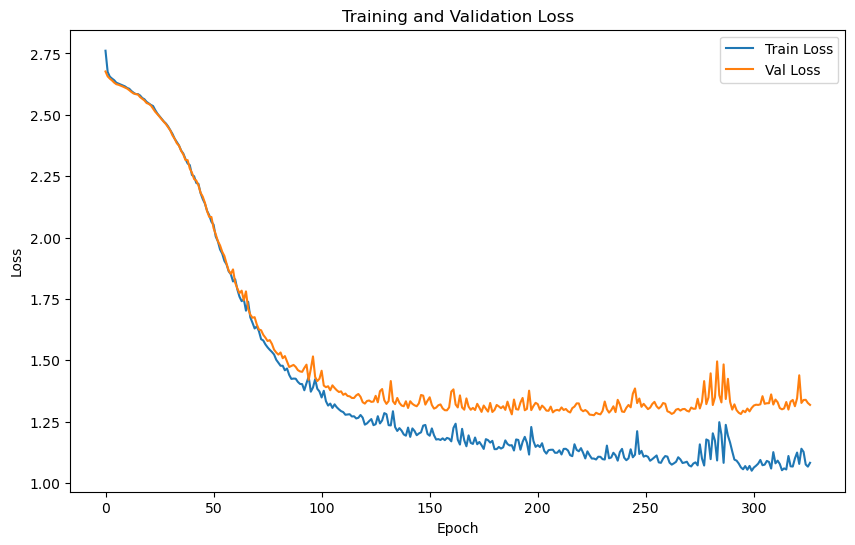

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.3433 | Test Accuracy: 39.34%


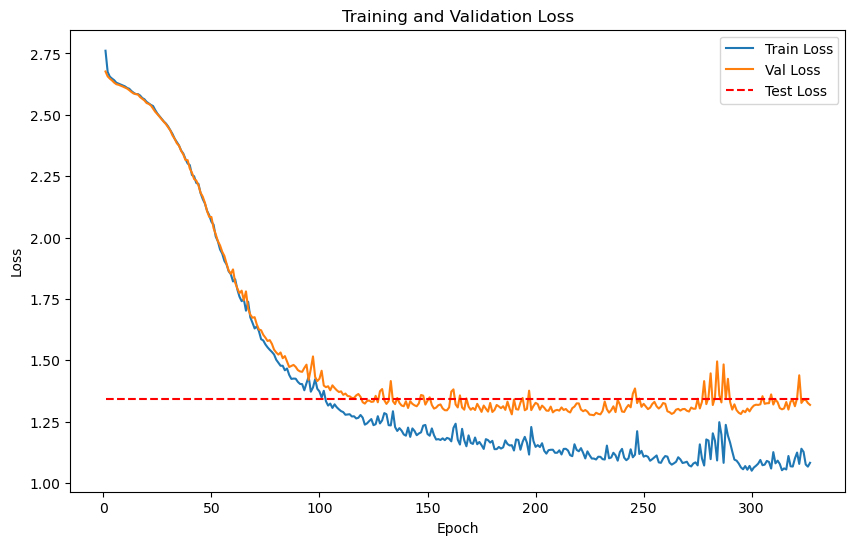

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.1441
Epoch [1/2000], Avg Train Loss: 8.1441
Epoch [1/2000], Avg Val Loss: 3.8492
Validation loss improved from inf to 3.8492. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1280
Epoch [2/2000], Avg Train Loss: 8.1280
Epoch [2/2000], Avg Val Loss: 3.8267
Validation loss improved from 3.8492 to 3.8267. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.2124
Epoch [3/2000], Avg Train Loss: 8.2124
Epoch [3/2000], Avg Val Loss: 3.8053
Validation loss improved from 3.8267 to 3.8053. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9866
Epoch [4/2000], Avg Train Loss: 7.9866
Epoch [4/2000], Avg Val Loss: 3.7849
Validation loss improved from 3.8053 to 3.7849. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.0622
Epoch [5/2000], Avg Train Loss: 8.0622
Epoch [5/2000], Avg Val Loss: 3.7652
Validation loss improved from 3.7849 to 3.7652. Saving mode

Epoch [16/2000], Avg Val Loss: 3.5952
Validation loss improved from 3.6078 to 3.5952. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.0983
Epoch [17/2000], Avg Train Loss: 7.0983
Epoch [17/2000], Avg Val Loss: 3.5831
Validation loss improved from 3.5952 to 3.5831. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.9037
Epoch [18/2000], Avg Train Loss: 6.9037
Epoch [18/2000], Avg Val Loss: 3.5715
Validation loss improved from 3.5831 to 3.5715. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.1522
Epoch [19/2000], Avg Train Loss: 7.1522
Epoch [19/2000], Avg Val Loss: 3.5604
Validation loss improved from 3.5715 to 3.5604. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.9971
Epoch [20/2000], Avg Train Loss: 6.9971
Epoch [20/2000], Avg Val Loss: 3.5496
Validation loss improved from 3.5604 to 3.5496. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.6629
Epoch [25/2000], Avg Train Loss: 6.6629
Epoch [25/2000], Avg Val Loss: 3.5018
Validation loss improved from 3.5105 to 3.5018. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.4961
Epoch [26/2000], Avg Train Loss: 6.4961
Epoch [26/2000], Avg Val Loss: 3.4934
Validation loss improved from 3.5018 to 3.4934. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.4722
Epoch [27/2000], Avg Train Loss: 6.4722
Epoch [27/2000], Avg Val Loss: 3.4853
Validation loss improved from 3.4934 to 3.4853. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.6097
Epoch [28/2000], Avg Train Loss: 6.6097
Epoch [28/2000], Avg Val Loss: 3.4776
Validation loss improved from 3.4853 to 3.4776. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.3565
Epoch [29/2000], Avg Train Loss: 6.3565
Epoch [29/2000], Avg Val Loss: 3.4703
Validation loss improved from 3.4776 to 3.

Epoch [41/2000], Avg Val Loss: 3.4020
Validation loss improved from 3.4065 to 3.4020. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 5.7568
Epoch [42/2000], Avg Train Loss: 5.7568
Epoch [42/2000], Avg Val Loss: 3.3977
Validation loss improved from 3.4020 to 3.3977. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 5.7951
Epoch [43/2000], Avg Train Loss: 5.7951
Epoch [43/2000], Avg Val Loss: 3.3936
Validation loss improved from 3.3977 to 3.3936. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 5.8022
Epoch [44/2000], Avg Train Loss: 5.8022
Epoch [44/2000], Avg Val Loss: 3.3897
Validation loss improved from 3.3936 to 3.3897. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.7656
Epoch [45/2000], Avg Train Loss: 5.7656
Epoch [45/2000], Avg Val Loss: 3.3859
Validation loss improved from 3.3897 to 3.3859. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.1452
Epoch [61/2000], Avg Train Loss: 5.1452
Epoch [61/2000], Avg Val Loss: 3.3414
Validation loss improved from 3.3435 to 3.3414. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.2667
Epoch [62/2000], Avg Train Loss: 5.2667
Epoch [62/2000], Avg Val Loss: 3.3393
Validation loss improved from 3.3414 to 3.3393. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.1523
Epoch [63/2000], Avg Train Loss: 5.1523
Epoch [63/2000], Avg Val Loss: 3.3373
Validation loss improved from 3.3393 to 3.3373. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.2752
Epoch [64/2000], Avg Train Loss: 5.2752
Epoch [64/2000], Avg Val Loss: 3.3354
Validation loss improved from 3.3373 to 3.3354. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 4.9881
Epoch [65/2000], Avg Train Loss: 4.9881
Epoch [65/2000], Avg Val Loss: 3.3335
Validation loss improved from 3.3354 to 3.

Epoch [69/2000], Avg Val Loss: 3.3267
Validation loss improved from 3.3283 to 3.3267. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.1833
Epoch [70/2000], Avg Train Loss: 5.1833
Epoch [70/2000], Avg Val Loss: 3.3251
Validation loss improved from 3.3267 to 3.3251. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.9811
Epoch [71/2000], Avg Train Loss: 4.9811
Epoch [71/2000], Avg Val Loss: 3.3235
Validation loss improved from 3.3251 to 3.3235. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.9921
Epoch [72/2000], Avg Train Loss: 4.9921
Epoch [72/2000], Avg Val Loss: 3.3221
Validation loss improved from 3.3235 to 3.3221. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.0576
Epoch [73/2000], Avg Train Loss: 5.0576
Epoch [73/2000], Avg Val Loss: 3.3206
Validation loss improved from 3.3221 to 3.3206. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.8940
Epoch [82/2000], Avg Train Loss: 4.8940
Epoch [82/2000], Avg Val Loss: 3.3090
Validation loss improved from 3.3102 to 3.3090. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 4.7836
Epoch [83/2000], Avg Train Loss: 4.7836
Epoch [83/2000], Avg Val Loss: 3.3079
Validation loss improved from 3.3090 to 3.3079. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 4.7132
Epoch [84/2000], Avg Train Loss: 4.7132
Epoch [84/2000], Avg Val Loss: 3.3069
Validation loss improved from 3.3079 to 3.3069. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 4.7561
Epoch [85/2000], Avg Train Loss: 4.7561
Epoch [85/2000], Avg Val Loss: 3.3058
Validation loss improved from 3.3069 to 3.3058. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 4.7470
Epoch [86/2000], Avg Train Loss: 4.7470
Epoch [86/2000], Avg Val Loss: 3.3048
Validation loss improved from 3.3058 to 3.

Epoch [104/2000], Avg Val Loss: 3.2874
Validation loss improved from 3.2883 to 3.2874. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.6781
Epoch [105/2000], Avg Train Loss: 4.6781
Epoch [105/2000], Avg Val Loss: 3.2864
Validation loss improved from 3.2874 to 3.2864. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.4903
Epoch [106/2000], Avg Train Loss: 4.4903
Epoch [106/2000], Avg Val Loss: 3.2855
Validation loss improved from 3.2864 to 3.2855. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.5512
Epoch [107/2000], Avg Train Loss: 4.5512
Epoch [107/2000], Avg Val Loss: 3.2846
Validation loss improved from 3.2855 to 3.2846. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.5145
Epoch [108/2000], Avg Train Loss: 4.5145
Epoch [108/2000], Avg Val Loss: 3.2837
Validation loss improved from 3.2846 to 3.2837. Saving model...

LOG: Epoch [109/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5640
Epoch [111/2000], Avg Train Loss: 4.5640
Epoch [111/2000], Avg Val Loss: 3.2811
Validation loss improved from 3.2819 to 3.2811. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.5087
Epoch [112/2000], Avg Train Loss: 4.5087
Epoch [112/2000], Avg Val Loss: 3.2802
Validation loss improved from 3.2811 to 3.2802. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.5157
Epoch [113/2000], Avg Train Loss: 4.5157
Epoch [113/2000], Avg Val Loss: 3.2794
Validation loss improved from 3.2802 to 3.2794. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.5915
Epoch [114/2000], Avg Train Loss: 4.5915
Epoch [114/2000], Avg Val Loss: 3.2785
Validation loss improved from 3.2794 to 3.2785. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.4857
Epoch [115/2000], Avg Train Loss: 4.4857
Epoch [115/2000], Avg Val Loss: 3.2776
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4849
Epoch [123/2000], Avg Train Loss: 4.4849
Epoch [123/2000], Avg Val Loss: 3.2709
Validation loss improved from 3.2718 to 3.2709. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 4.5026
Epoch [124/2000], Avg Train Loss: 4.5026
Epoch [124/2000], Avg Val Loss: 3.2701
Validation loss improved from 3.2709 to 3.2701. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.5403
Epoch [125/2000], Avg Train Loss: 4.5403
Epoch [125/2000], Avg Val Loss: 3.2692
Validation loss improved from 3.2701 to 3.2692. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.6021
Epoch [126/2000], Avg Train Loss: 4.6021
Epoch [126/2000], Avg Val Loss: 3.2684
Validation loss improved from 3.2692 to 3.2684. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.4959
Epoch [127/2000], Avg Train Loss: 4.4959
Epoch [127/2000], Avg Val Loss: 3.2677
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4039
Epoch [147/2000], Avg Train Loss: 4.4039
Epoch [147/2000], Avg Val Loss: 3.2516
Validation loss improved from 3.2525 to 3.2516. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.4156
Epoch [148/2000], Avg Train Loss: 4.4156
Epoch [148/2000], Avg Val Loss: 3.2508
Validation loss improved from 3.2516 to 3.2508. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.4242
Epoch [149/2000], Avg Train Loss: 4.4242
Epoch [149/2000], Avg Val Loss: 3.2500
Validation loss improved from 3.2508 to 3.2500. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.3463
Epoch [150/2000], Avg Train Loss: 4.3463
Epoch [150/2000], Avg Val Loss: 3.2492
Validation loss improved from 3.2500 to 3.2492. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.3534
Epoch [151/2000], Avg Train Loss: 4.3534
Epoch [151/2000], Avg Val Loss: 3.2483
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2749
Epoch [165/2000], Avg Train Loss: 4.2749
Epoch [165/2000], Avg Val Loss: 3.2368
Validation loss improved from 3.2376 to 3.2368. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.2779
Epoch [166/2000], Avg Train Loss: 4.2779
Epoch [166/2000], Avg Val Loss: 3.2359
Validation loss improved from 3.2368 to 3.2359. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 4.2912
Epoch [167/2000], Avg Train Loss: 4.2912
Epoch [167/2000], Avg Val Loss: 3.2351
Validation loss improved from 3.2359 to 3.2351. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 4.2759
Epoch [168/2000], Avg Train Loss: 4.2759
Epoch [168/2000], Avg Val Loss: 3.2342
Validation loss improved from 3.2351 to 3.2342. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.2853
Epoch [169/2000], Avg Train Loss: 4.2853
Epoch [169/2000], Avg Val Loss: 3.2334
Validation loss improved fro

Epoch [192/2000], Avg Val Loss: 3.2129
Validation loss improved from 3.2138 to 3.2129. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.2274
Epoch [193/2000], Avg Train Loss: 4.2274
Epoch [193/2000], Avg Val Loss: 3.2120
Validation loss improved from 3.2129 to 3.2120. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.1898
Epoch [194/2000], Avg Train Loss: 4.1898
Epoch [194/2000], Avg Val Loss: 3.2111
Validation loss improved from 3.2120 to 3.2111. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.1603
Epoch [195/2000], Avg Train Loss: 4.1603
Epoch [195/2000], Avg Val Loss: 3.2102
Validation loss improved from 3.2111 to 3.2102. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.2546
Epoch [196/2000], Avg Train Loss: 4.2546
Epoch [196/2000], Avg Val Loss: 3.2093
Validation loss improved from 3.2102 to 3.2093. Saving model...

LOG: Epoch [197/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1441
Epoch [212/2000], Avg Train Loss: 4.1441
Epoch [212/2000], Avg Val Loss: 3.1950
Validation loss improved from 3.1958 to 3.1950. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.1690
Epoch [213/2000], Avg Train Loss: 4.1690
Epoch [213/2000], Avg Val Loss: 3.1941
Validation loss improved from 3.1950 to 3.1941. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 4.1874
Epoch [214/2000], Avg Train Loss: 4.1874
Epoch [214/2000], Avg Val Loss: 3.1933
Validation loss improved from 3.1941 to 3.1933. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.1645
Epoch [215/2000], Avg Train Loss: 4.1645
Epoch [215/2000], Avg Val Loss: 3.1924
Validation loss improved from 3.1933 to 3.1924. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.1014
Epoch [216/2000], Avg Train Loss: 4.1014
Epoch [216/2000], Avg Val Loss: 3.1915
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1705
Epoch [236/2000], Avg Train Loss: 4.1705
Epoch [236/2000], Avg Val Loss: 3.1749
Validation loss improved from 3.1757 to 3.1749. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.1246
Epoch [237/2000], Avg Train Loss: 4.1246
Epoch [237/2000], Avg Val Loss: 3.1741
Validation loss improved from 3.1749 to 3.1741. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.0584
Epoch [238/2000], Avg Train Loss: 4.0584
Epoch [238/2000], Avg Val Loss: 3.1733
Validation loss improved from 3.1741 to 3.1733. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.1627
Epoch [239/2000], Avg Train Loss: 4.1627
Epoch [239/2000], Avg Val Loss: 3.1725
Validation loss improved from 3.1733 to 3.1725. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.0989
Epoch [240/2000], Avg Train Loss: 4.0989
Epoch [240/2000], Avg Val Loss: 3.1717
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0344
Epoch [258/2000], Avg Train Loss: 4.0344
Epoch [258/2000], Avg Val Loss: 3.1562
Validation loss improved from 3.1571 to 3.1562. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.0255
Epoch [259/2000], Avg Train Loss: 4.0255
Epoch [259/2000], Avg Val Loss: 3.1554
Validation loss improved from 3.1562 to 3.1554. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.0749
Epoch [260/2000], Avg Train Loss: 4.0749
Epoch [260/2000], Avg Val Loss: 3.1545
Validation loss improved from 3.1554 to 3.1545. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.0237
Epoch [261/2000], Avg Train Loss: 4.0237
Epoch [261/2000], Avg Val Loss: 3.1536
Validation loss improved from 3.1545 to 3.1536. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.0410
Epoch [262/2000], Avg Train Loss: 4.0410
Epoch [262/2000], Avg Val Loss: 3.1527
Validation loss improved fro

Epoch [279/2000], Avg Val Loss: 3.1384
Validation loss improved from 3.1392 to 3.1384. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 4.0246
Epoch [280/2000], Avg Train Loss: 4.0246
Epoch [280/2000], Avg Val Loss: 3.1376
Validation loss improved from 3.1384 to 3.1376. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 4.0532
Epoch [281/2000], Avg Train Loss: 4.0532
Epoch [281/2000], Avg Val Loss: 3.1368
Validation loss improved from 3.1376 to 3.1368. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 4.0260
Epoch [282/2000], Avg Train Loss: 4.0260
Epoch [282/2000], Avg Val Loss: 3.1360
Validation loss improved from 3.1368 to 3.1360. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 4.0081
Epoch [283/2000], Avg Train Loss: 4.0081
Epoch [283/2000], Avg Val Loss: 3.1352
Validation loss improved from 3.1360 to 3.1352. Saving model...

LOG: Epoch [284/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9502
Epoch [302/2000], Avg Train Loss: 3.9502
Epoch [302/2000], Avg Val Loss: 3.1199
Validation loss improved from 3.1206 to 3.1199. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.9223
Epoch [303/2000], Avg Train Loss: 3.9223
Epoch [303/2000], Avg Val Loss: 3.1191
Validation loss improved from 3.1199 to 3.1191. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.9004
Epoch [304/2000], Avg Train Loss: 3.9004
Epoch [304/2000], Avg Val Loss: 3.1183
Validation loss improved from 3.1191 to 3.1183. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.9307
Epoch [305/2000], Avg Train Loss: 3.9307
Epoch [305/2000], Avg Val Loss: 3.1176
Validation loss improved from 3.1183 to 3.1176. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.9535
Epoch [306/2000], Avg Train Loss: 3.9535
Epoch [306/2000], Avg Val Loss: 3.1168
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8994
Epoch [325/2000], Avg Train Loss: 3.8994
Epoch [325/2000], Avg Val Loss: 3.1032
Validation loss improved from 3.1039 to 3.1032. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.9365
Epoch [326/2000], Avg Train Loss: 3.9365
Epoch [326/2000], Avg Val Loss: 3.1025
Validation loss improved from 3.1032 to 3.1025. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.9042
Epoch [327/2000], Avg Train Loss: 3.9042
Epoch [327/2000], Avg Val Loss: 3.1017
Validation loss improved from 3.1025 to 3.1017. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.9734
Epoch [328/2000], Avg Train Loss: 3.9734
Epoch [328/2000], Avg Val Loss: 3.1010
Validation loss improved from 3.1017 to 3.1010. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.9353
Epoch [329/2000], Avg Train Loss: 3.9353
Epoch [329/2000], Avg Val Loss: 3.1003
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9172
Epoch [346/2000], Avg Train Loss: 3.9172
Epoch [346/2000], Avg Val Loss: 3.0890
Validation loss improved from 3.0896 to 3.0890. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.8584
Epoch [347/2000], Avg Train Loss: 3.8584
Epoch [347/2000], Avg Val Loss: 3.0884
Validation loss improved from 3.0890 to 3.0884. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.9028
Epoch [348/2000], Avg Train Loss: 3.9028
Epoch [348/2000], Avg Val Loss: 3.0877
Validation loss improved from 3.0884 to 3.0877. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.8987
Epoch [349/2000], Avg Train Loss: 3.8987
Epoch [349/2000], Avg Val Loss: 3.0871
Validation loss improved from 3.0877 to 3.0871. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.8611
Epoch [350/2000], Avg Train Loss: 3.8611
Epoch [350/2000], Avg Val Loss: 3.0864
Validation loss improved fro

Epoch [367/2000], Avg Val Loss: 3.0750
Validation loss improved from 3.0756 to 3.0750. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.9009
Epoch [368/2000], Avg Train Loss: 3.9009
Epoch [368/2000], Avg Val Loss: 3.0744
Validation loss improved from 3.0750 to 3.0744. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.8627
Epoch [369/2000], Avg Train Loss: 3.8627
Epoch [369/2000], Avg Val Loss: 3.0738
Validation loss improved from 3.0744 to 3.0738. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.8778
Epoch [370/2000], Avg Train Loss: 3.8778
Epoch [370/2000], Avg Val Loss: 3.0732
Validation loss improved from 3.0738 to 3.0732. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.8927
Epoch [371/2000], Avg Train Loss: 3.8927
Epoch [371/2000], Avg Val Loss: 3.0726
Validation loss improved from 3.0732 to 3.0726. Saving model...

LOG: Epoch [372/2000] - Training
    Bat

Epoch [386/2000], Avg Val Loss: 3.0636
Validation loss improved from 3.0642 to 3.0636. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 3.8337
Epoch [387/2000], Avg Train Loss: 3.8337
Epoch [387/2000], Avg Val Loss: 3.0630
Validation loss improved from 3.0636 to 3.0630. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 3.7980
Epoch [388/2000], Avg Train Loss: 3.7980
Epoch [388/2000], Avg Val Loss: 3.0625
Validation loss improved from 3.0630 to 3.0625. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 3.8772
Epoch [389/2000], Avg Train Loss: 3.8772
Epoch [389/2000], Avg Val Loss: 3.0619
Validation loss improved from 3.0625 to 3.0619. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 3.8521
Epoch [390/2000], Avg Train Loss: 3.8521
Epoch [390/2000], Avg Val Loss: 3.0614
Validation loss improved from 3.0619 to 3.0614. Saving model...

LOG: Epoch [391/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8223
Epoch [412/2000], Avg Train Loss: 3.8223
Epoch [412/2000], Avg Val Loss: 3.0481
Validation loss improved from 3.0487 to 3.0481. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 3.8115
Epoch [413/2000], Avg Train Loss: 3.8115
Epoch [413/2000], Avg Val Loss: 3.0475
Validation loss improved from 3.0481 to 3.0475. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 3.8082
Epoch [414/2000], Avg Train Loss: 3.8082
Epoch [414/2000], Avg Val Loss: 3.0470
Validation loss improved from 3.0475 to 3.0470. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 3.7450
Epoch [415/2000], Avg Train Loss: 3.7450
Epoch [415/2000], Avg Val Loss: 3.0464
Validation loss improved from 3.0470 to 3.0464. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.7548
Epoch [416/2000], Avg Train Loss: 3.7548
Epoch [416/2000], Avg Val Loss: 3.0459
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7175
Epoch [429/2000], Avg Train Loss: 3.7175
Epoch [429/2000], Avg Val Loss: 3.0386
Validation loss improved from 3.0392 to 3.0386. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 3.7462
Epoch [430/2000], Avg Train Loss: 3.7462
Epoch [430/2000], Avg Val Loss: 3.0380
Validation loss improved from 3.0386 to 3.0380. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 3.7486
Epoch [431/2000], Avg Train Loss: 3.7486
Epoch [431/2000], Avg Val Loss: 3.0374
Validation loss improved from 3.0380 to 3.0374. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 3.7418
Epoch [432/2000], Avg Train Loss: 3.7418
Epoch [432/2000], Avg Val Loss: 3.0368
Validation loss improved from 3.0374 to 3.0368. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 3.7518
Epoch [433/2000], Avg Train Loss: 3.7518
Epoch [433/2000], Avg Val Loss: 3.0362
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7259
Epoch [457/2000], Avg Train Loss: 3.7259
Epoch [457/2000], Avg Val Loss: 3.0215
Validation loss improved from 3.0222 to 3.0215. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 3.7216
Epoch [458/2000], Avg Train Loss: 3.7216
Epoch [458/2000], Avg Val Loss: 3.0208
Validation loss improved from 3.0215 to 3.0208. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.7377
Epoch [459/2000], Avg Train Loss: 3.7377
Epoch [459/2000], Avg Val Loss: 3.0202
Validation loss improved from 3.0208 to 3.0202. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.7747
Epoch [460/2000], Avg Train Loss: 3.7747
Epoch [460/2000], Avg Val Loss: 3.0195
Validation loss improved from 3.0202 to 3.0195. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 3.7569
Epoch [461/2000], Avg Train Loss: 3.7569
Epoch [461/2000], Avg Val Loss: 3.0188
Validation loss improved fro

Epoch [472/2000], Avg Val Loss: 3.0127
Validation loss improved from 3.0132 to 3.0127. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 3.7223
Epoch [473/2000], Avg Train Loss: 3.7223
Epoch [473/2000], Avg Val Loss: 3.0122
Validation loss improved from 3.0127 to 3.0122. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.6909
Epoch [474/2000], Avg Train Loss: 3.6909
Epoch [474/2000], Avg Val Loss: 3.0118
Validation loss improved from 3.0122 to 3.0118. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 3.7731
Epoch [475/2000], Avg Train Loss: 3.7731
Epoch [475/2000], Avg Val Loss: 3.0113
Validation loss improved from 3.0118 to 3.0113. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 3.6942
Epoch [476/2000], Avg Train Loss: 3.6942
Epoch [476/2000], Avg Val Loss: 3.0109
Validation loss improved from 3.0113 to 3.0109. Saving model...

LOG: Epoch [477/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7237
Epoch [502/2000], Avg Train Loss: 3.7237
Epoch [502/2000], Avg Val Loss: 2.9991
Validation loss improved from 2.9997 to 2.9991. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 3.6919
Epoch [503/2000], Avg Train Loss: 3.6919
Epoch [503/2000], Avg Val Loss: 2.9986
Validation loss improved from 2.9991 to 2.9986. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.5971
Epoch [504/2000], Avg Train Loss: 3.5971
Epoch [504/2000], Avg Val Loss: 2.9981
Validation loss improved from 2.9986 to 2.9981. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.6504
Epoch [505/2000], Avg Train Loss: 3.6504
Epoch [505/2000], Avg Val Loss: 2.9977
Validation loss improved from 2.9981 to 2.9977. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.6248
Epoch [506/2000], Avg Train Loss: 3.6248
Epoch [506/2000], Avg Val Loss: 2.9973
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6198
Epoch [517/2000], Avg Train Loss: 3.6198
Epoch [517/2000], Avg Val Loss: 2.9912
Validation loss improved from 2.9917 to 2.9912. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.6237
Epoch [518/2000], Avg Train Loss: 3.6237
Epoch [518/2000], Avg Val Loss: 2.9907
Validation loss improved from 2.9912 to 2.9907. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.6361
Epoch [519/2000], Avg Train Loss: 3.6361
Epoch [519/2000], Avg Val Loss: 2.9903
Validation loss improved from 2.9907 to 2.9903. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 3.6673
Epoch [520/2000], Avg Train Loss: 3.6673
Epoch [520/2000], Avg Val Loss: 2.9899
Validation loss improved from 2.9903 to 2.9899. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 3.6405
Epoch [521/2000], Avg Train Loss: 3.6405
Epoch [521/2000], Avg Val Loss: 2.9895
Validation loss improved fro

Epoch [544/2000], Avg Val Loss: 2.9811
Validation loss improved from 2.9814 to 2.9811. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 3.6277
Epoch [545/2000], Avg Train Loss: 3.6277
Epoch [545/2000], Avg Val Loss: 2.9808
Validation loss improved from 2.9811 to 2.9808. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 3.6382
Epoch [546/2000], Avg Train Loss: 3.6382
Epoch [546/2000], Avg Val Loss: 2.9804
Validation loss improved from 2.9808 to 2.9804. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 3.6834
Epoch [547/2000], Avg Train Loss: 3.6834
Epoch [547/2000], Avg Val Loss: 2.9801
Validation loss improved from 2.9804 to 2.9801. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 3.6598
Epoch [548/2000], Avg Train Loss: 3.6598
Epoch [548/2000], Avg Val Loss: 2.9798
Validation loss improved from 2.9801 to 2.9798. Saving model...

LOG: Epoch [549/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6023
Epoch [560/2000], Avg Train Loss: 3.6023
Epoch [560/2000], Avg Val Loss: 2.9756
Validation loss improved from 2.9759 to 2.9756. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.6057
Epoch [561/2000], Avg Train Loss: 3.6057
Epoch [561/2000], Avg Val Loss: 2.9752
Validation loss improved from 2.9756 to 2.9752. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.5179
Epoch [562/2000], Avg Train Loss: 3.5179
Epoch [562/2000], Avg Val Loss: 2.9749
Validation loss improved from 2.9752 to 2.9749. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.6124
Epoch [563/2000], Avg Train Loss: 3.6124
Epoch [563/2000], Avg Val Loss: 2.9746
Validation loss improved from 2.9749 to 2.9746. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.6086
Epoch [564/2000], Avg Train Loss: 3.6086
Epoch [564/2000], Avg Val Loss: 2.9744
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5540
Epoch [589/2000], Avg Train Loss: 3.5540
Epoch [589/2000], Avg Val Loss: 2.9650
Validation loss improved from 2.9653 to 2.9650. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.5207
Epoch [590/2000], Avg Train Loss: 3.5207
Epoch [590/2000], Avg Val Loss: 2.9645
Validation loss improved from 2.9650 to 2.9645. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.5807
Epoch [591/2000], Avg Train Loss: 3.5807
Epoch [591/2000], Avg Val Loss: 2.9640
Validation loss improved from 2.9645 to 2.9640. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 3.5638
Epoch [592/2000], Avg Train Loss: 3.5638
Epoch [592/2000], Avg Val Loss: 2.9637
Validation loss improved from 2.9640 to 2.9637. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.6115
Epoch [593/2000], Avg Train Loss: 3.6115
Epoch [593/2000], Avg Val Loss: 2.9633
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5557
Epoch [608/2000], Avg Train Loss: 3.5557
Epoch [608/2000], Avg Val Loss: 2.9581
Validation loss improved from 2.9585 to 2.9581. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 3.5275
Epoch [609/2000], Avg Train Loss: 3.5275
Epoch [609/2000], Avg Val Loss: 2.9578
Validation loss improved from 2.9581 to 2.9578. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 3.5385
Epoch [610/2000], Avg Train Loss: 3.5385
Epoch [610/2000], Avg Val Loss: 2.9574
Validation loss improved from 2.9578 to 2.9574. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.5677
Epoch [611/2000], Avg Train Loss: 3.5677
Epoch [611/2000], Avg Val Loss: 2.9571
Validation loss improved from 2.9574 to 2.9571. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.5623
Epoch [612/2000], Avg Train Loss: 3.5623
Epoch [612/2000], Avg Val Loss: 2.9567
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5209
Epoch [633/2000], Avg Train Loss: 3.5209
Epoch [633/2000], Avg Val Loss: 2.9499
Validation loss improved from 2.9502 to 2.9499. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.5894
Epoch [634/2000], Avg Train Loss: 3.5894
Epoch [634/2000], Avg Val Loss: 2.9496
Validation loss improved from 2.9499 to 2.9496. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.5225
Epoch [635/2000], Avg Train Loss: 3.5225
Epoch [635/2000], Avg Val Loss: 2.9494
Validation loss improved from 2.9496 to 2.9494. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.5470
Epoch [636/2000], Avg Train Loss: 3.5470
Epoch [636/2000], Avg Val Loss: 2.9493
Validation loss improved from 2.9494 to 2.9493. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.4896
Epoch [637/2000], Avg Train Loss: 3.4896
Epoch [637/2000], Avg Val Loss: 2.9491
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4476
Epoch [652/2000], Avg Train Loss: 3.4476
Epoch [652/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9449 to 2.9445. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.4509
Epoch [653/2000], Avg Train Loss: 3.4509
Epoch [653/2000], Avg Val Loss: 2.9441
Validation loss improved from 2.9445 to 2.9441. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.4445
Epoch [654/2000], Avg Train Loss: 3.4445
Epoch [654/2000], Avg Val Loss: 2.9437
Validation loss improved from 2.9441 to 2.9437. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.5018
Epoch [655/2000], Avg Train Loss: 3.5018
Epoch [655/2000], Avg Val Loss: 2.9433
Validation loss improved from 2.9437 to 2.9433. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.5250
Epoch [656/2000], Avg Train Loss: 3.5250
Epoch [656/2000], Avg Val Loss: 2.9429
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4739
Epoch [678/2000], Avg Train Loss: 3.4739
Epoch [678/2000], Avg Val Loss: 2.9358
Validation loss improved from 2.9361 to 2.9358. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 3.3975
Epoch [679/2000], Avg Train Loss: 3.3975
Epoch [679/2000], Avg Val Loss: 2.9355
Validation loss improved from 2.9358 to 2.9355. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 3.4202
Epoch [680/2000], Avg Train Loss: 3.4202
Epoch [680/2000], Avg Val Loss: 2.9352
Validation loss improved from 2.9355 to 2.9352. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.4742
Epoch [681/2000], Avg Train Loss: 3.4742
Epoch [681/2000], Avg Val Loss: 2.9349
Validation loss improved from 2.9352 to 2.9349. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.4739
Epoch [682/2000], Avg Train Loss: 3.4739
Epoch [682/2000], Avg Val Loss: 2.9344
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4290
Epoch [698/2000], Avg Train Loss: 3.4290
Epoch [698/2000], Avg Val Loss: 2.9276
Validation loss improved from 2.9281 to 2.9276. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.4815
Epoch [699/2000], Avg Train Loss: 3.4815
Epoch [699/2000], Avg Val Loss: 2.9270
Validation loss improved from 2.9276 to 2.9270. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.3875
Epoch [700/2000], Avg Train Loss: 3.3875
Epoch [700/2000], Avg Val Loss: 2.9265
Validation loss improved from 2.9270 to 2.9265. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.4759
Epoch [701/2000], Avg Train Loss: 3.4759
Epoch [701/2000], Avg Val Loss: 2.9260
Validation loss improved from 2.9265 to 2.9260. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.3838
Epoch [702/2000], Avg Train Loss: 3.3838
Epoch [702/2000], Avg Val Loss: 2.9255
Validation loss improved fro

Epoch [722/2000], Avg Val Loss: 2.9186
Validation loss improved from 2.9188 to 2.9186. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 3.4256
Epoch [723/2000], Avg Train Loss: 3.4256
Epoch [723/2000], Avg Val Loss: 2.9184
Validation loss improved from 2.9186 to 2.9184. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.4180
Epoch [724/2000], Avg Train Loss: 3.4180
Epoch [724/2000], Avg Val Loss: 2.9182
Validation loss improved from 2.9184 to 2.9182. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.3789
Epoch [725/2000], Avg Train Loss: 3.3789
Epoch [725/2000], Avg Val Loss: 2.9180
Validation loss improved from 2.9182 to 2.9180. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.4429
Epoch [726/2000], Avg Train Loss: 3.4429
Epoch [726/2000], Avg Val Loss: 2.9178
Validation loss improved from 2.9180 to 2.9178. Saving model...

LOG: Epoch [727/2000] - Training
    Bat

Epoch [741/2000], Avg Val Loss: 2.9139
Validation loss improved from 2.9141 to 2.9139. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.3837
Epoch [742/2000], Avg Train Loss: 3.3837
Epoch [742/2000], Avg Val Loss: 2.9136
Validation loss improved from 2.9139 to 2.9136. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.3598
Epoch [743/2000], Avg Train Loss: 3.3598
Epoch [743/2000], Avg Val Loss: 2.9134
Validation loss improved from 2.9136 to 2.9134. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.4099
Epoch [744/2000], Avg Train Loss: 3.4099
Epoch [744/2000], Avg Val Loss: 2.9131
Validation loss improved from 2.9134 to 2.9131. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.3887
Epoch [745/2000], Avg Train Loss: 3.3887
Epoch [745/2000], Avg Val Loss: 2.9128
Validation loss improved from 2.9131 to 2.9128. Saving model...

LOG: Epoch [746/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3778
Epoch [767/2000], Avg Train Loss: 3.3778
Epoch [767/2000], Avg Val Loss: 2.9085
Validation loss improved from 2.9088 to 2.9085. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 3.3737
Epoch [768/2000], Avg Train Loss: 3.3737
Epoch [768/2000], Avg Val Loss: 2.9081
Validation loss improved from 2.9085 to 2.9081. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.3055
Epoch [769/2000], Avg Train Loss: 3.3055
Epoch [769/2000], Avg Val Loss: 2.9079
Validation loss improved from 2.9081 to 2.9079. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.3739
Epoch [770/2000], Avg Train Loss: 3.3739
Epoch [770/2000], Avg Val Loss: 2.9075
Validation loss improved from 2.9079 to 2.9075. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.3692
Epoch [771/2000], Avg Train Loss: 3.3692
Epoch [771/2000], Avg Val Loss: 2.9072
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2995
Epoch [783/2000], Avg Train Loss: 3.2995
Epoch [783/2000], Avg Val Loss: 2.9043
Validation loss improved from 2.9046 to 2.9043. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 3.2997
Epoch [784/2000], Avg Train Loss: 3.2997
Epoch [784/2000], Avg Val Loss: 2.9040
Validation loss improved from 2.9043 to 2.9040. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 3.3415
Epoch [785/2000], Avg Train Loss: 3.3415
Epoch [785/2000], Avg Val Loss: 2.9036
Validation loss improved from 2.9040 to 2.9036. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 3.3468
Epoch [786/2000], Avg Train Loss: 3.3468
Epoch [786/2000], Avg Val Loss: 2.9031
Validation loss improved from 2.9036 to 2.9031. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.3131
Epoch [787/2000], Avg Train Loss: 3.3131
Epoch [787/2000], Avg Val Loss: 2.9028
Validation loss improved fro

Epoch [811/2000], Avg Val Loss: 2.8983
Validation loss improved from 2.8983 to 2.8983. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.3529
Epoch [812/2000], Avg Train Loss: 3.3529
Epoch [812/2000], Avg Val Loss: 2.8983
Validation loss improved from 2.8983 to 2.8983. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 3.3587
Epoch [813/2000], Avg Train Loss: 3.3587
Epoch [813/2000], Avg Val Loss: 2.8982
Validation loss improved from 2.8983 to 2.8982. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.3380
Epoch [814/2000], Avg Train Loss: 3.3380
Epoch [814/2000], Avg Val Loss: 2.8981
Validation loss improved from 2.8982 to 2.8981. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.2618
Epoch [815/2000], Avg Train Loss: 3.2618
Epoch [815/2000], Avg Val Loss: 2.8980
Validation loss improved from 2.8981 to 2.8980. Saving model...

LOG: Epoch [816/2000] - Training
    Bat

Epoch [831/2000], Avg Val Loss: 2.8957
Validation loss improved from 2.8958 to 2.8957. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 3.3098
Epoch [832/2000], Avg Train Loss: 3.3098
Epoch [832/2000], Avg Val Loss: 2.8955
Validation loss improved from 2.8957 to 2.8955. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.3127
Epoch [833/2000], Avg Train Loss: 3.3127
Epoch [833/2000], Avg Val Loss: 2.8953
Validation loss improved from 2.8955 to 2.8953. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 3.3503
Epoch [834/2000], Avg Train Loss: 3.3503
Epoch [834/2000], Avg Val Loss: 2.8951
Validation loss improved from 2.8953 to 2.8951. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 3.3425
Epoch [835/2000], Avg Train Loss: 3.3425
Epoch [835/2000], Avg Val Loss: 2.8949
Validation loss improved from 2.8951 to 2.8949. Saving model...

LOG: Epoch [836/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2607
Epoch [858/2000], Avg Train Loss: 3.2607
Epoch [858/2000], Avg Val Loss: 2.8856
Validation loss improved from 2.8858 to 2.8856. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 3.3107
Epoch [859/2000], Avg Train Loss: 3.3107
Epoch [859/2000], Avg Val Loss: 2.8854
Validation loss improved from 2.8856 to 2.8854. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 3.2805
Epoch [860/2000], Avg Train Loss: 3.2805
Epoch [860/2000], Avg Val Loss: 2.8853
Validation loss improved from 2.8854 to 2.8853. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 3.3113
Epoch [861/2000], Avg Train Loss: 3.3113
Epoch [861/2000], Avg Val Loss: 2.8851
Validation loss improved from 2.8853 to 2.8851. Saving model...

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 3.2927
Epoch [862/2000], Avg Train Loss: 3.2927
Epoch [862/2000], Avg Val Loss: 2.8850
Validation loss improved fro

Epoch [876/2000], Avg Val Loss: 2.8816
Validation loss improved from 2.8817 to 2.8816. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 3.2504
Epoch [877/2000], Avg Train Loss: 3.2504
Epoch [877/2000], Avg Val Loss: 2.8816
Validation loss improved from 2.8816 to 2.8816. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 3.2601
Epoch [878/2000], Avg Train Loss: 3.2601
Epoch [878/2000], Avg Val Loss: 2.8815
Validation loss improved from 2.8816 to 2.8815. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.2847
Epoch [879/2000], Avg Train Loss: 3.2847
Epoch [879/2000], Avg Val Loss: 2.8813
Validation loss improved from 2.8815 to 2.8813. Saving model...

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.2850
Epoch [880/2000], Avg Train Loss: 3.2850
Epoch [880/2000], Avg Val Loss: 2.8811
Validation loss improved from 2.8813 to 2.8811. Saving model...

LOG: Epoch [881/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2610
Epoch [903/2000], Avg Train Loss: 3.2610
Epoch [903/2000], Avg Val Loss: 2.8776
Validation loss improved from 2.8779 to 2.8776. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.3136
Epoch [904/2000], Avg Train Loss: 3.3136
Epoch [904/2000], Avg Val Loss: 2.8773
Validation loss improved from 2.8776 to 2.8773. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 3.2663
Epoch [905/2000], Avg Train Loss: 3.2663
Epoch [905/2000], Avg Val Loss: 2.8770
Validation loss improved from 2.8773 to 2.8770. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 3.1791
Epoch [906/2000], Avg Train Loss: 3.1791
Epoch [906/2000], Avg Val Loss: 2.8767
Validation loss improved from 2.8770 to 2.8767. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 3.1959
Epoch [907/2000], Avg Train Loss: 3.1959
Epoch [907/2000], Avg Val Loss: 2.8764
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2442
Epoch [923/2000], Avg Train Loss: 3.2442
Epoch [923/2000], Avg Val Loss: 2.8710
Validation loss improved from 2.8713 to 2.8710. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 3.1845
Epoch [924/2000], Avg Train Loss: 3.1845
Epoch [924/2000], Avg Val Loss: 2.8705
Validation loss improved from 2.8710 to 2.8705. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 3.2668
Epoch [925/2000], Avg Train Loss: 3.2668
Epoch [925/2000], Avg Val Loss: 2.8703
Validation loss improved from 2.8705 to 2.8703. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 3.2481
Epoch [926/2000], Avg Train Loss: 3.2481
Epoch [926/2000], Avg Val Loss: 2.8703
Validation loss improved from 2.8703 to 2.8703. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 3.1791
Epoch [927/2000], Avg Train Loss: 3.1791
Epoch [927/2000], Avg Val Loss: 2.8701
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1750
Epoch [949/2000], Avg Train Loss: 3.1750
Epoch [949/2000], Avg Val Loss: 2.8706
Validation loss did not improve. Patience: 20/100

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.2008
Epoch [950/2000], Avg Train Loss: 3.2008
Epoch [950/2000], Avg Val Loss: 2.8706
Validation loss did not improve. Patience: 21/100

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.2195
Epoch [951/2000], Avg Train Loss: 3.2195
Epoch [951/2000], Avg Val Loss: 2.8705
Validation loss did not improve. Patience: 22/100

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 3.1829
Epoch [952/2000], Avg Train Loss: 3.1829
Epoch [952/2000], Avg Val Loss: 2.8707
Validation loss did not improve. Patience: 23/100

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 3.2115
Epoch [953/2000], Avg Train Loss: 3.2115
Epoch [953/2000], Avg Val Loss: 2.8708
Validation loss did not improve. Patience: 24/100

LOG: Epoch [954/2000] - Training


Epoch [968/2000], Avg Val Loss: 2.8707
Validation loss did not improve. Patience: 39/100

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 3.1535
Epoch [969/2000], Avg Train Loss: 3.1535
Epoch [969/2000], Avg Val Loss: 2.8708
Validation loss did not improve. Patience: 40/100

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 3.1589
Epoch [970/2000], Avg Train Loss: 3.1589
Epoch [970/2000], Avg Val Loss: 2.8710
Validation loss did not improve. Patience: 41/100

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 3.2050
Epoch [971/2000], Avg Train Loss: 3.2050
Epoch [971/2000], Avg Val Loss: 2.8711
Validation loss did not improve. Patience: 42/100

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 3.2124
Epoch [972/2000], Avg Train Loss: 3.2124
Epoch [972/2000], Avg Val Loss: 2.8710
Validation loss did not improve. Patience: 43/100

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 3.1792
Epoch [973/2000], Avg Train Loss: 3.1792


    Batch [1/1], Train Loss: 3.1425
Epoch [994/2000], Avg Train Loss: 3.1425
Epoch [994/2000], Avg Val Loss: 2.8646
Validation loss improved from 2.8648 to 2.8646. Saving model...

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 3.1619
Epoch [995/2000], Avg Train Loss: 3.1619
Epoch [995/2000], Avg Val Loss: 2.8642
Validation loss improved from 2.8646 to 2.8642. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 3.1515
Epoch [996/2000], Avg Train Loss: 3.1515
Epoch [996/2000], Avg Val Loss: 2.8638
Validation loss improved from 2.8642 to 2.8638. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 3.1728
Epoch [997/2000], Avg Train Loss: 3.1728
Epoch [997/2000], Avg Val Loss: 2.8633
Validation loss improved from 2.8638 to 2.8633. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 3.1491
Epoch [998/2000], Avg Train Loss: 3.1491
Epoch [998/2000], Avg Val Loss: 2.8630
Validation loss improved fro

Epoch [1013/2000], Avg Val Loss: 2.8647
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 3.1627
Epoch [1014/2000], Avg Train Loss: 3.1627
Epoch [1014/2000], Avg Val Loss: 2.8648
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.1784
Epoch [1015/2000], Avg Train Loss: 3.1784
Epoch [1015/2000], Avg Val Loss: 2.8648
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 3.1564
Epoch [1016/2000], Avg Train Loss: 3.1564
Epoch [1016/2000], Avg Val Loss: 2.8648
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.1847
Epoch [1017/2000], Avg Train Loss: 3.1847
Epoch [1017/2000], Avg Val Loss: 2.8648
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.1535
Epoch [1018/2000], Avg Trai

    Batch [1/1], Train Loss: 3.1435
Epoch [1039/2000], Avg Train Loss: 3.1435
Epoch [1039/2000], Avg Val Loss: 2.8631
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 3.0884
Epoch [1040/2000], Avg Train Loss: 3.0884
Epoch [1040/2000], Avg Val Loss: 2.8631
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 3.1503
Epoch [1041/2000], Avg Train Loss: 3.1503
Epoch [1041/2000], Avg Val Loss: 2.8630
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 3.1001
Epoch [1042/2000], Avg Train Loss: 3.1001
Epoch [1042/2000], Avg Val Loss: 2.8628
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 3.1971
Epoch [1043/2000], Avg Train Loss: 3.1971
Epoch [1043/2000], Avg Val Loss: 2.8626
Validation loss improved from 2.8626 to 2.8626. Saving model...

LOG: 

    Batch [1/1], Train Loss: 3.1374
Epoch [1059/2000], Avg Train Loss: 3.1374
Epoch [1059/2000], Avg Val Loss: 2.8578
Validation loss improved from 2.8582 to 2.8578. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.1034
Epoch [1060/2000], Avg Train Loss: 3.1034
Epoch [1060/2000], Avg Val Loss: 2.8573
Validation loss improved from 2.8578 to 2.8573. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.0976
Epoch [1061/2000], Avg Train Loss: 3.0976
Epoch [1061/2000], Avg Val Loss: 2.8570
Validation loss improved from 2.8573 to 2.8570. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 3.1071
Epoch [1062/2000], Avg Train Loss: 3.1071
Epoch [1062/2000], Avg Val Loss: 2.8565
Validation loss improved from 2.8570 to 2.8565. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 3.1025
Epoch [1063/2000], Avg Train Loss: 3.1025
Epoch [1063/2000], Avg Val Loss: 2.8561
Validation los

Epoch [1084/2000], Avg Val Loss: 2.8538
Validation loss improved from 2.8540 to 2.8538. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 3.1038
Epoch [1085/2000], Avg Train Loss: 3.1038
Epoch [1085/2000], Avg Val Loss: 2.8535
Validation loss improved from 2.8538 to 2.8535. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 3.1067
Epoch [1086/2000], Avg Train Loss: 3.1067
Epoch [1086/2000], Avg Val Loss: 2.8532
Validation loss improved from 2.8535 to 2.8532. Saving model...

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 3.0609
Epoch [1087/2000], Avg Train Loss: 3.0609
Epoch [1087/2000], Avg Val Loss: 2.8529
Validation loss improved from 2.8532 to 2.8529. Saving model...

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 3.1578
Epoch [1088/2000], Avg Train Loss: 3.1578
Epoch [1088/2000], Avg Val Loss: 2.8526
Validation loss improved from 2.8529 to 2.8526. Saving model...

LOG: Epoch [1089/2000] - Tr

    Batch [1/1], Train Loss: 3.1265
Epoch [1105/2000], Avg Train Loss: 3.1265
Epoch [1105/2000], Avg Val Loss: 2.8500
Validation loss improved from 2.8502 to 2.8500. Saving model...

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 3.0859
Epoch [1106/2000], Avg Train Loss: 3.0859
Epoch [1106/2000], Avg Val Loss: 2.8500
Validation loss improved from 2.8500 to 2.8500. Saving model...

LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 3.1006
Epoch [1107/2000], Avg Train Loss: 3.1006
Epoch [1107/2000], Avg Val Loss: 2.8501
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 3.0778
Epoch [1108/2000], Avg Train Loss: 3.0778
Epoch [1108/2000], Avg Val Loss: 2.8503
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 3.0430
Epoch [1109/2000], Avg Train Loss: 3.0430
Epoch [1109/2000], Avg Val Loss: 2.8505
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.0515
Epoch [1130/2000], Avg Train Loss: 3.0515
Epoch [1130/2000], Avg Val Loss: 2.8479
Validation loss improved from 2.8481 to 2.8479. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 3.1001
Epoch [1131/2000], Avg Train Loss: 3.1001
Epoch [1131/2000], Avg Val Loss: 2.8476
Validation loss improved from 2.8479 to 2.8476. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 3.0719
Epoch [1132/2000], Avg Train Loss: 3.0719
Epoch [1132/2000], Avg Val Loss: 2.8474
Validation loss improved from 2.8476 to 2.8474. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 3.0011
Epoch [1133/2000], Avg Train Loss: 3.0011
Epoch [1133/2000], Avg Val Loss: 2.8473
Validation loss improved from 2.8474 to 2.8473. Saving model...

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 3.0638
Epoch [1134/2000], Avg Train Loss: 3.0638
Epoch [1134/2000], Avg Val Loss: 2.8472
Validation los

    Batch [1/1], Train Loss: 3.0968
Epoch [1149/2000], Avg Train Loss: 3.0968
Epoch [1149/2000], Avg Val Loss: 2.8477
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 3.0146
Epoch [1150/2000], Avg Train Loss: 3.0146
Epoch [1150/2000], Avg Val Loss: 2.8474
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.0435
Epoch [1151/2000], Avg Train Loss: 3.0435
Epoch [1151/2000], Avg Val Loss: 2.8473
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 3.0574
Epoch [1152/2000], Avg Train Loss: 3.0574
Epoch [1152/2000], Avg Val Loss: 2.8472
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 3.0295
Epoch [1153/2000], Avg Train Loss: 3.0295
Epoch [1153/2000], Avg Val Loss: 2.8472
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1154/20

    Batch [1/1], Train Loss: 3.0326
Epoch [1172/2000], Avg Train Loss: 3.0326
Epoch [1172/2000], Avg Val Loss: 2.8478
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 3.0126
Epoch [1173/2000], Avg Train Loss: 3.0126
Epoch [1173/2000], Avg Val Loss: 2.8477
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 3.0127
Epoch [1174/2000], Avg Train Loss: 3.0127
Epoch [1174/2000], Avg Val Loss: 2.8475
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 2.9665
Epoch [1175/2000], Avg Train Loss: 2.9665
Epoch [1175/2000], Avg Val Loss: 2.8473
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 3.0344
Epoch [1176/2000], Avg Train Loss: 3.0344
Epoch [1176/2000], Avg Val Loss: 2.8471
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1177/20

    Batch [1/1], Train Loss: 3.0536
Epoch [1193/2000], Avg Train Loss: 3.0536
Epoch [1193/2000], Avg Val Loss: 2.8399
Validation loss improved from 2.8403 to 2.8399. Saving model...

LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 3.0255
Epoch [1194/2000], Avg Train Loss: 3.0255
Epoch [1194/2000], Avg Val Loss: 2.8397
Validation loss improved from 2.8399 to 2.8397. Saving model...

LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 3.0288
Epoch [1195/2000], Avg Train Loss: 3.0288
Epoch [1195/2000], Avg Val Loss: 2.8396
Validation loss improved from 2.8397 to 2.8396. Saving model...

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 3.0017
Epoch [1196/2000], Avg Train Loss: 3.0017
Epoch [1196/2000], Avg Val Loss: 2.8396
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.0011
Epoch [1197/2000], Avg Train Loss: 3.0011
Epoch [1197/2000], Avg Val Loss: 2.8396
Validation loss improved from

    Batch [1/1], Train Loss: 3.0142
Epoch [1216/2000], Avg Train Loss: 3.0142
Epoch [1216/2000], Avg Val Loss: 2.8387
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 3.0348
Epoch [1217/2000], Avg Train Loss: 3.0348
Epoch [1217/2000], Avg Val Loss: 2.8391
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 2.9578
Epoch [1218/2000], Avg Train Loss: 2.9578
Epoch [1218/2000], Avg Val Loss: 2.8394
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 2.9338
Epoch [1219/2000], Avg Train Loss: 2.9338
Epoch [1219/2000], Avg Val Loss: 2.8395
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 2.9610
Epoch [1220/2000], Avg Train Loss: 2.9610
Epoch [1220/2000], Avg Val Loss: 2.8394
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1221/2000] -

    Batch [1/1], Train Loss: 2.9640
Epoch [1238/2000], Avg Train Loss: 2.9640
Epoch [1238/2000], Avg Val Loss: 2.8400
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 3.0015
Epoch [1239/2000], Avg Train Loss: 3.0015
Epoch [1239/2000], Avg Val Loss: 2.8400
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 2.9811
Epoch [1240/2000], Avg Train Loss: 2.9811
Epoch [1240/2000], Avg Val Loss: 2.8399
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 2.9271
Epoch [1241/2000], Avg Train Loss: 2.9271
Epoch [1241/2000], Avg Val Loss: 2.8401
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 2.9914
Epoch [1242/2000], Avg Train Loss: 2.9914
Epoch [1242/2000], Avg Val Loss: 2.8403
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1243/20

    Batch [1/1], Train Loss: 2.9598
Epoch [1255/2000], Avg Train Loss: 2.9598
Epoch [1255/2000], Avg Val Loss: 2.8431
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 3.0137
Epoch [1256/2000], Avg Train Loss: 3.0137
Epoch [1256/2000], Avg Val Loss: 2.8431
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 2.9957
Epoch [1257/2000], Avg Train Loss: 2.9957
Epoch [1257/2000], Avg Val Loss: 2.8430
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 3.0485
Epoch [1258/2000], Avg Train Loss: 3.0485
Epoch [1258/2000], Avg Val Loss: 2.8426
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 3.0404
Epoch [1259/2000], Avg Train Loss: 3.0404
Epoch [1259/2000], Avg Val Loss: 2.8423
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1260/20

    Batch [1/1], Train Loss: 2.9853
Epoch [1277/2000], Avg Train Loss: 2.9853
Epoch [1277/2000], Avg Val Loss: 2.8368
Validation loss improved from 2.8368 to 2.8368. Saving model...

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 2.9670
Epoch [1278/2000], Avg Train Loss: 2.9670
Epoch [1278/2000], Avg Val Loss: 2.8366
Validation loss improved from 2.8368 to 2.8366. Saving model...

LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 2.9798
Epoch [1279/2000], Avg Train Loss: 2.9798
Epoch [1279/2000], Avg Val Loss: 2.8365
Validation loss improved from 2.8366 to 2.8365. Saving model...

LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 2.9891
Epoch [1280/2000], Avg Train Loss: 2.9891
Epoch [1280/2000], Avg Val Loss: 2.8364
Validation loss improved from 2.8365 to 2.8364. Saving model...

LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 2.9575
Epoch [1281/2000], Avg Train Loss: 2.9575
Epoch [1281/2000], Avg Val Loss: 2.8363
Validation los

    Batch [1/1], Train Loss: 2.9437
Epoch [1304/2000], Avg Train Loss: 2.9437
Epoch [1304/2000], Avg Val Loss: 2.8335
Validation loss improved from 2.8338 to 2.8335. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 2.9414
Epoch [1305/2000], Avg Train Loss: 2.9414
Epoch [1305/2000], Avg Val Loss: 2.8335
Validation loss improved from 2.8335 to 2.8335. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 2.9711
Epoch [1306/2000], Avg Train Loss: 2.9711
Epoch [1306/2000], Avg Val Loss: 2.8334
Validation loss improved from 2.8335 to 2.8334. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 2.9426
Epoch [1307/2000], Avg Train Loss: 2.9426
Epoch [1307/2000], Avg Val Loss: 2.8334
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 2.9892
Epoch [1308/2000], Avg Train Loss: 2.9892
Epoch [1308/2000], Avg Val Loss: 2.8334
Validation loss did not impro

    Batch [1/1], Train Loss: 2.9228
Epoch [1321/2000], Avg Train Loss: 2.9228
Epoch [1321/2000], Avg Val Loss: 2.8340
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 2.8936
Epoch [1322/2000], Avg Train Loss: 2.8936
Epoch [1322/2000], Avg Val Loss: 2.8338
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 2.9310
Epoch [1323/2000], Avg Train Loss: 2.9310
Epoch [1323/2000], Avg Val Loss: 2.8335
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 2.9711
Epoch [1324/2000], Avg Train Loss: 2.9711
Epoch [1324/2000], Avg Val Loss: 2.8333
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 2.9264
Epoch [1325/2000], Avg Train Loss: 2.9264
Epoch [1325/2000], Avg Val Loss: 2.8330
Validation loss improved from 2.8333 to 2.8330. Saving model...

LOG: 

    Batch [1/1], Train Loss: 2.9039
Epoch [1350/2000], Avg Train Loss: 2.9039
Epoch [1350/2000], Avg Val Loss: 2.8280
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 2.9381
Epoch [1351/2000], Avg Train Loss: 2.9381
Epoch [1351/2000], Avg Val Loss: 2.8278
Validation loss improved from 2.8278 to 2.8278. Saving model...

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 2.8984
Epoch [1352/2000], Avg Train Loss: 2.8984
Epoch [1352/2000], Avg Val Loss: 2.8277
Validation loss improved from 2.8278 to 2.8277. Saving model...

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 2.9402
Epoch [1353/2000], Avg Train Loss: 2.9402
Epoch [1353/2000], Avg Val Loss: 2.8278
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 2.9375
Epoch [1354/2000], Avg Train Loss: 2.9375
Epoch [1354/2000], Avg Val Loss: 2.8279
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 2.9400
Epoch [1365/2000], Avg Train Loss: 2.9400
Epoch [1365/2000], Avg Val Loss: 2.8258
Validation loss improved from 2.8260 to 2.8258. Saving model...

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 2.9109
Epoch [1366/2000], Avg Train Loss: 2.9109
Epoch [1366/2000], Avg Val Loss: 2.8257
Validation loss improved from 2.8258 to 2.8257. Saving model...

LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 2.9254
Epoch [1367/2000], Avg Train Loss: 2.9254
Epoch [1367/2000], Avg Val Loss: 2.8255
Validation loss improved from 2.8257 to 2.8255. Saving model...

LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 2.9520
Epoch [1368/2000], Avg Train Loss: 2.9520
Epoch [1368/2000], Avg Val Loss: 2.8254
Validation loss improved from 2.8255 to 2.8254. Saving model...

LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 2.9594
Epoch [1369/2000], Avg Train Loss: 2.9594
Epoch [1369/2000], Avg Val Loss: 2.8254
Validation los

    Batch [1/1], Train Loss: 2.9180
Epoch [1394/2000], Avg Train Loss: 2.9180
Epoch [1394/2000], Avg Val Loss: 2.8255
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 2.9028
Epoch [1395/2000], Avg Train Loss: 2.9028
Epoch [1395/2000], Avg Val Loss: 2.8251
Validation loss improved from 2.8253 to 2.8251. Saving model...

LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 2.9107
Epoch [1396/2000], Avg Train Loss: 2.9107
Epoch [1396/2000], Avg Val Loss: 2.8248
Validation loss improved from 2.8251 to 2.8248. Saving model...

LOG: Epoch [1397/2000] - Training
    Batch [1/1], Train Loss: 2.9378
Epoch [1397/2000], Avg Train Loss: 2.9378
Epoch [1397/2000], Avg Val Loss: 2.8245
Validation loss improved from 2.8248 to 2.8245. Saving model...

LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 2.9390
Epoch [1398/2000], Avg Train Loss: 2.9390
Epoch [1398/2000], Avg Val Loss: 2.8241
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9072
Epoch [1409/2000], Avg Train Loss: 2.9072
Epoch [1409/2000], Avg Val Loss: 2.8191
Validation loss improved from 2.8196 to 2.8191. Saving model...

LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 2.9197
Epoch [1410/2000], Avg Train Loss: 2.9197
Epoch [1410/2000], Avg Val Loss: 2.8188
Validation loss improved from 2.8191 to 2.8188. Saving model...

LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 2.9577
Epoch [1411/2000], Avg Train Loss: 2.9577
Epoch [1411/2000], Avg Val Loss: 2.8184
Validation loss improved from 2.8188 to 2.8184. Saving model...

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 2.9583
Epoch [1412/2000], Avg Train Loss: 2.9583
Epoch [1412/2000], Avg Val Loss: 2.8180
Validation loss improved from 2.8184 to 2.8180. Saving model...

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 2.8983
Epoch [1413/2000], Avg Train Loss: 2.8983
Epoch [1413/2000], Avg Val Loss: 2.8176
Validation los

    Batch [1/1], Train Loss: 2.9187
Epoch [1438/2000], Avg Train Loss: 2.9187
Epoch [1438/2000], Avg Val Loss: 2.8095
Validation loss improved from 2.8097 to 2.8095. Saving model...

LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 2.8337
Epoch [1439/2000], Avg Train Loss: 2.8337
Epoch [1439/2000], Avg Val Loss: 2.8092
Validation loss improved from 2.8095 to 2.8092. Saving model...

LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 2.8552
Epoch [1440/2000], Avg Train Loss: 2.8552
Epoch [1440/2000], Avg Val Loss: 2.8089
Validation loss improved from 2.8092 to 2.8089. Saving model...

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 2.8730
Epoch [1441/2000], Avg Train Loss: 2.8730
Epoch [1441/2000], Avg Val Loss: 2.8087
Validation loss improved from 2.8089 to 2.8087. Saving model...

LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 2.8922
Epoch [1442/2000], Avg Train Loss: 2.8922
Epoch [1442/2000], Avg Val Loss: 2.8084
Validation los

Epoch [1453/2000], Avg Train Loss: 2.8673
Epoch [1453/2000], Avg Val Loss: 2.8101
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 2.8904
Epoch [1454/2000], Avg Train Loss: 2.8904
Epoch [1454/2000], Avg Val Loss: 2.8104
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 2.8831
Epoch [1455/2000], Avg Train Loss: 2.8831
Epoch [1455/2000], Avg Val Loss: 2.8108
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1456/2000] - Training
    Batch [1/1], Train Loss: 2.9039
Epoch [1456/2000], Avg Train Loss: 2.9039
Epoch [1456/2000], Avg Val Loss: 2.8111
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1457/2000] - Training
    Batch [1/1], Train Loss: 2.8868
Epoch [1457/2000], Avg Train Loss: 2.8868
Epoch [1457/2000], Avg Val Loss: 2.8117
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1458/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 2.8759
Epoch [1485/2000], Avg Train Loss: 2.8759
Epoch [1485/2000], Avg Val Loss: 2.8191
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 2.8647
Epoch [1486/2000], Avg Train Loss: 2.8647
Epoch [1486/2000], Avg Val Loss: 2.8186
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 2.8975
Epoch [1487/2000], Avg Train Loss: 2.8975
Epoch [1487/2000], Avg Val Loss: 2.8182
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 2.9180
Epoch [1488/2000], Avg Train Loss: 2.9180
Epoch [1488/2000], Avg Val Loss: 2.8175
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1489/2000] - Training
    Batch [1/1], Train Loss: 2.8635
Epoch [1489/2000], Avg Train Loss: 2.8635
Epoch [1489/2000], Avg Val Loss: 2.8170
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1490/20

Epoch [1497/2000], Avg Val Loss: 2.8117
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1498/2000] - Training
    Batch [1/1], Train Loss: 2.8628
Epoch [1498/2000], Avg Train Loss: 2.8628
Epoch [1498/2000], Avg Val Loss: 2.8113
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 2.8450
Epoch [1499/2000], Avg Train Loss: 2.8450
Epoch [1499/2000], Avg Val Loss: 2.8111
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1500/2000] - Training
    Batch [1/1], Train Loss: 2.8903
Epoch [1500/2000], Avg Train Loss: 2.8903
Epoch [1500/2000], Avg Val Loss: 2.8110
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 2.8922
Epoch [1501/2000], Avg Train Loss: 2.8922
Epoch [1501/2000], Avg Val Loss: 2.8108
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 2.8276
Epoch [1502/2000], Avg Trai

    Batch [1/1], Train Loss: 2.8731
Epoch [1529/2000], Avg Train Loss: 2.8731
Epoch [1529/2000], Avg Val Loss: 2.8127
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 2.8617
Epoch [1530/2000], Avg Train Loss: 2.8617
Epoch [1530/2000], Avg Val Loss: 2.8127
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 2.8830
Epoch [1531/2000], Avg Train Loss: 2.8830
Epoch [1531/2000], Avg Val Loss: 2.8124
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 2.8396
Epoch [1532/2000], Avg Train Loss: 2.8396
Epoch [1532/2000], Avg Val Loss: 2.8122
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1533/2000] - Training
    Batch [1/1], Train Loss: 2.8646
Epoch [1533/2000], Avg Train Loss: 2.8646
Epoch [1533/2000], Avg Val Loss: 2.8120
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1534/20

Epoch [1538/2000], Avg Val Loss: 2.8099
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 2.8327
Epoch [1539/2000], Avg Train Loss: 2.8327
Epoch [1539/2000], Avg Val Loss: 2.8094
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 2.8176
Epoch [1540/2000], Avg Train Loss: 2.8176
Epoch [1540/2000], Avg Val Loss: 2.8090
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 2.8520
Epoch [1541/2000], Avg Train Loss: 2.8520
Epoch [1541/2000], Avg Val Loss: 2.8086
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 2.8360
Epoch [1542/2000], Avg Train Loss: 2.8360
Epoch [1542/2000], Avg Val Loss: 2.8084
Validation loss improved from 2.8084 to 2.8084. Saving model...

LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 2.8426
Epoch [1543/2

    Batch [1/1], Train Loss: 2.8269
Epoch [1573/2000], Avg Train Loss: 2.8269
Epoch [1573/2000], Avg Val Loss: 2.8063
Validation loss improved from 2.8069 to 2.8063. Saving model...

LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 2.9118
Epoch [1574/2000], Avg Train Loss: 2.9118
Epoch [1574/2000], Avg Val Loss: 2.8057
Validation loss improved from 2.8063 to 2.8057. Saving model...

LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 2.7854
Epoch [1575/2000], Avg Train Loss: 2.7854
Epoch [1575/2000], Avg Val Loss: 2.8053
Validation loss improved from 2.8057 to 2.8053. Saving model...

LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 2.8291
Epoch [1576/2000], Avg Train Loss: 2.8291
Epoch [1576/2000], Avg Val Loss: 2.8050
Validation loss improved from 2.8053 to 2.8050. Saving model...

LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 2.7731
Epoch [1577/2000], Avg Train Loss: 2.7731
Epoch [1577/2000], Avg Val Loss: 2.8046
Validation los

    Batch [1/1], Train Loss: 2.8207
Epoch [1579/2000], Avg Train Loss: 2.8207
Epoch [1579/2000], Avg Val Loss: 2.8040
Validation loss improved from 2.8044 to 2.8040. Saving model...

LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 2.8019
Epoch [1580/2000], Avg Train Loss: 2.8019
Epoch [1580/2000], Avg Val Loss: 2.8037
Validation loss improved from 2.8040 to 2.8037. Saving model...

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 2.8081
Epoch [1581/2000], Avg Train Loss: 2.8081
Epoch [1581/2000], Avg Val Loss: 2.8036
Validation loss improved from 2.8037 to 2.8036. Saving model...

LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 2.7863
Epoch [1582/2000], Avg Train Loss: 2.7863
Epoch [1582/2000], Avg Val Loss: 2.8031
Validation loss improved from 2.8036 to 2.8031. Saving model...

LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 2.8237
Epoch [1583/2000], Avg Train Loss: 2.8237
Epoch [1583/2000], Avg Val Loss: 2.8026
Validation los

    Batch [1/1], Train Loss: 2.8373
Epoch [1617/2000], Avg Train Loss: 2.8373
Epoch [1617/2000], Avg Val Loss: 2.8049
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 2.8249
Epoch [1618/2000], Avg Train Loss: 2.8249
Epoch [1618/2000], Avg Val Loss: 2.8047
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 2.8107
Epoch [1619/2000], Avg Train Loss: 2.8107
Epoch [1619/2000], Avg Val Loss: 2.8047
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 2.8521
Epoch [1620/2000], Avg Train Loss: 2.8521
Epoch [1620/2000], Avg Val Loss: 2.8044
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 2.7912
Epoch [1621/2000], Avg Train Loss: 2.7912
Epoch [1621/2000], Avg Val Loss: 2.8039
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1622/20

Epoch [1660/2000], Avg Val Loss: 2.8119
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1661/2000] - Training
    Batch [1/1], Train Loss: 2.8177
Epoch [1661/2000], Avg Train Loss: 2.8177
Epoch [1661/2000], Avg Val Loss: 2.8122
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 2.8290
Epoch [1662/2000], Avg Train Loss: 2.8290
Epoch [1662/2000], Avg Val Loss: 2.8125
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 2.8209
Epoch [1663/2000], Avg Train Loss: 2.8209
Epoch [1663/2000], Avg Val Loss: 2.8130
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 2.8093
Epoch [1664/2000], Avg Train Loss: 2.8093
Epoch [1664/2000], Avg Val Loss: 2.8132
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 2.8577
Epoch [1665/2000], Avg Trai

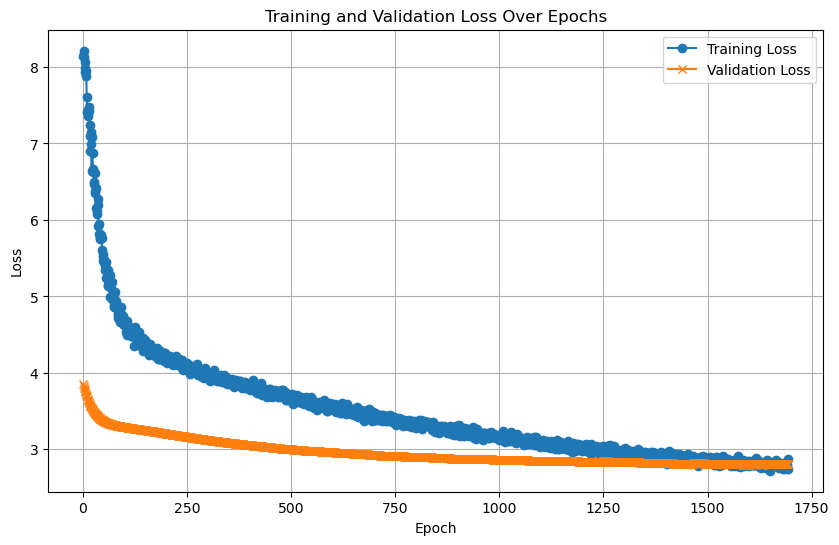

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.1443

Test Loss: 4.9877


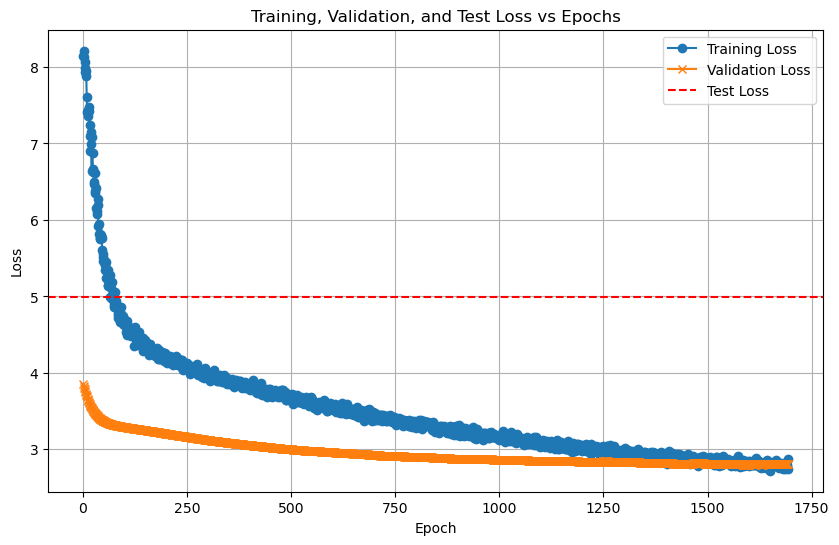

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 74.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.71      1.00      0.83         5
           3       0.62      1.00      0.77         5
           4       0.33      0.20      0.25         5
           5       0.67      0.40      0.50         5
           6       1.00      0.60      0.75         5
           7       0.71      1.00      0.83         5
           8       0.67      0.40      0.50         5
           9       0.60      0.60      0.60         5
          10       1.00      0.40      0.57         5
          11       1.00      0.80      0.89         5
          12       0.56      1.00      0.71         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7397  |  Val Loss: 2.6957
Validation loss improved from inf to 2.6957.
[Epoch 2/1000] Train Loss: 2.7118  |  Val Loss: 2.6725
Validation loss improved from 2.6957 to 2.6725.
[Epoch 3/1000] Train Loss: 2.6854  |  Val Loss: 2.6509
Validation loss improved from 2.6725 to 2.6509.
[Epoch 4/1000] Train Loss: 2.6623  |  Val Loss: 2.6307
Validation loss improved from 2.6509 to 2.6307.
[Epoch 5/1000] Train Loss: 2.6377  |  Val Loss: 2.6113
Validation loss improved from 2.6307 to 2.6113.
[Epoch 6/1000] Train Loss: 2.6173  |  Val Loss: 2.5924
Validation loss improved from 2.6113 to 2.5924.
[Epoch 7/1000] Train Loss: 2.5958  |  Val Loss: 2.5737
Validation loss improved from 2.5924 to 2.5737.
[Epoch 8/1000] Train Loss: 2.5745  |  Val Loss: 2.5552
Validation loss improved from 2.5737 to 2.5552.
[Epoch 9/1000] Train Loss: 2.5536  |  Val Loss: 2.5355
Validation loss improved from 2.5552 to 2.5355.
[Epoch 10/1000] Train Loss: 2.5307  |  Val Loss: 2.5166
Validation loss impr

[Epoch 15/1000] Train Loss: 2.4434  |  Val Loss: 2.4452
Validation loss improved from 2.4558 to 2.4452.
[Epoch 16/1000] Train Loss: 2.4319  |  Val Loss: 2.4352
Validation loss improved from 2.4452 to 2.4352.
[Epoch 17/1000] Train Loss: 2.4203  |  Val Loss: 2.4255
Validation loss improved from 2.4352 to 2.4255.
[Epoch 18/1000] Train Loss: 2.4095  |  Val Loss: 2.4159
Validation loss improved from 2.4255 to 2.4159.
[Epoch 19/1000] Train Loss: 2.3985  |  Val Loss: 2.4066
Validation loss improved from 2.4159 to 2.4066.
[Epoch 20/1000] Train Loss: 2.3882  |  Val Loss: 2.3973
Validation loss improved from 2.4066 to 2.3973.
[Epoch 21/1000] Train Loss: 2.3779  |  Val Loss: 2.3882
Validation loss improved from 2.3973 to 2.3882.
[Epoch 22/1000] Train Loss: 2.3679  |  Val Loss: 2.3789
Validation loss improved from 2.3882 to 2.3789.
[Epoch 23/1000] Train Loss: 2.3578  |  Val Loss: 2.3700
Validation loss improved from 2.3789 to 2.3700.
[Epoch 24/1000] Train Loss: 2.3483  |  Val Loss: 2.3614
Validati

[Epoch 25/1000] Train Loss: 2.3384  |  Val Loss: 2.3528
Validation loss improved from 2.3614 to 2.3528.


[Epoch 26/1000] Train Loss: 2.3292  |  Val Loss: 2.3440
Validation loss improved from 2.3528 to 2.3440.
[Epoch 27/1000] Train Loss: 2.3190  |  Val Loss: 2.3353
Validation loss improved from 2.3440 to 2.3353.
[Epoch 28/1000] Train Loss: 2.3095  |  Val Loss: 2.3267
Validation loss improved from 2.3353 to 2.3267.
[Epoch 29/1000] Train Loss: 2.2998  |  Val Loss: 2.3184
Validation loss improved from 2.3267 to 2.3184.
[Epoch 30/1000] Train Loss: 2.2906  |  Val Loss: 2.3103
Validation loss improved from 2.3184 to 2.3103.
[Epoch 31/1000] Train Loss: 2.2809  |  Val Loss: 2.3023
Validation loss improved from 2.3103 to 2.3023.
[Epoch 32/1000] Train Loss: 2.2720  |  Val Loss: 2.2945
Validation loss improved from 2.3023 to 2.2945.
[Epoch 33/1000] Train Loss: 2.2625  |  Val Loss: 2.2868
Validation loss improved from 2.2945 to 2.2868.
[Epoch 34/1000] Train Loss: 2.2536  |  Val Loss: 2.2790
Validation loss improved from 2.2868 to 2.2790.
[Epoch 35/1000] Train Loss: 2.2447  |  Val Loss: 2.2713
Validati

[Epoch 45/1000] Train Loss: 2.1517  |  Val Loss: 2.1952
Validation loss improved from 2.2026 to 2.1952.
[Epoch 46/1000] Train Loss: 2.1420  |  Val Loss: 2.1876
Validation loss improved from 2.1952 to 2.1876.
[Epoch 47/1000] Train Loss: 2.1326  |  Val Loss: 2.1796
Validation loss improved from 2.1876 to 2.1796.
[Epoch 48/1000] Train Loss: 2.1229  |  Val Loss: 2.1719
Validation loss improved from 2.1796 to 2.1719.
[Epoch 49/1000] Train Loss: 2.1133  |  Val Loss: 2.1641
Validation loss improved from 2.1719 to 2.1641.
[Epoch 50/1000] Train Loss: 2.1039  |  Val Loss: 2.1562
Validation loss improved from 2.1641 to 2.1562.
[Epoch 51/1000] Train Loss: 2.0945  |  Val Loss: 2.1482
Validation loss improved from 2.1562 to 2.1482.
[Epoch 52/1000] Train Loss: 2.0852  |  Val Loss: 2.1401
Validation loss improved from 2.1482 to 2.1401.
[Epoch 53/1000] Train Loss: 2.0755  |  Val Loss: 2.1322
Validation loss improved from 2.1401 to 2.1322.
[Epoch 54/1000] Train Loss: 2.0652  |  Val Loss: 2.1241
Validati

[Epoch 55/1000] Train Loss: 2.0553  |  Val Loss: 2.1155
Validation loss improved from 2.1241 to 2.1155.
[Epoch 56/1000] Train Loss: 2.0447  |  Val Loss: 2.1066
Validation loss improved from 2.1155 to 2.1066.
[Epoch 57/1000] Train Loss: 2.0337  |  Val Loss: 2.0976
Validation loss improved from 2.1066 to 2.0976.
[Epoch 58/1000] Train Loss: 2.0224  |  Val Loss: 2.0885
Validation loss improved from 2.0976 to 2.0885.
[Epoch 59/1000] Train Loss: 2.0110  |  Val Loss: 2.0793
Validation loss improved from 2.0885 to 2.0793.
[Epoch 60/1000] Train Loss: 1.9992  |  Val Loss: 2.0703
Validation loss improved from 2.0793 to 2.0703.
[Epoch 61/1000] Train Loss: 1.9884  |  Val Loss: 2.0612
Validation loss improved from 2.0703 to 2.0612.
[Epoch 62/1000] Train Loss: 1.9763  |  Val Loss: 2.0522
Validation loss improved from 2.0612 to 2.0522.
[Epoch 63/1000] Train Loss: 1.9650  |  Val Loss: 2.0430
Validation loss improved from 2.0522 to 2.0430.
[Epoch 64/1000] Train Loss: 1.9539  |  Val Loss: 2.0341
Validati

[Epoch 75/1000] Train Loss: 1.8326  |  Val Loss: 1.9347
Validation loss improved from 1.9431 to 1.9347.
[Epoch 76/1000] Train Loss: 1.8216  |  Val Loss: 1.9265
Validation loss improved from 1.9347 to 1.9265.
[Epoch 77/1000] Train Loss: 1.8109  |  Val Loss: 1.9182
Validation loss improved from 1.9265 to 1.9182.
[Epoch 78/1000] Train Loss: 1.8002  |  Val Loss: 1.9098
Validation loss improved from 1.9182 to 1.9098.
[Epoch 79/1000] Train Loss: 1.7900  |  Val Loss: 1.9015
Validation loss improved from 1.9098 to 1.9015.
[Epoch 80/1000] Train Loss: 1.7789  |  Val Loss: 1.8933
Validation loss improved from 1.9015 to 1.8933.
[Epoch 81/1000] Train Loss: 1.7687  |  Val Loss: 1.8847
Validation loss improved from 1.8933 to 1.8847.
[Epoch 82/1000] Train Loss: 1.7581  |  Val Loss: 1.8757
Validation loss improved from 1.8847 to 1.8757.
[Epoch 83/1000] Train Loss: 1.7479  |  Val Loss: 1.8662
Validation loss improved from 1.8757 to 1.8662.
[Epoch 84/1000] Train Loss: 1.7371  |  Val Loss: 1.8571
Validati

[Epoch 86/1000] Train Loss: 1.7158  |  Val Loss: 1.8397
Validation loss improved from 1.8484 to 1.8397.
[Epoch 87/1000] Train Loss: 1.7057  |  Val Loss: 1.8308
Validation loss improved from 1.8397 to 1.8308.
[Epoch 88/1000] Train Loss: 1.6949  |  Val Loss: 1.8218
Validation loss improved from 1.8308 to 1.8218.
[Epoch 89/1000] Train Loss: 1.6843  |  Val Loss: 1.8129
Validation loss improved from 1.8218 to 1.8129.
[Epoch 90/1000] Train Loss: 1.6741  |  Val Loss: 1.8040
Validation loss improved from 1.8129 to 1.8040.
[Epoch 91/1000] Train Loss: 1.6643  |  Val Loss: 1.7955
Validation loss improved from 1.8040 to 1.7955.
[Epoch 92/1000] Train Loss: 1.6541  |  Val Loss: 1.7871
Validation loss improved from 1.7955 to 1.7871.
[Epoch 93/1000] Train Loss: 1.6439  |  Val Loss: 1.7789
Validation loss improved from 1.7871 to 1.7789.
[Epoch 94/1000] Train Loss: 1.6337  |  Val Loss: 1.7711
Validation loss improved from 1.7789 to 1.7711.
[Epoch 95/1000] Train Loss: 1.6234  |  Val Loss: 1.7636
Validati

[Epoch 101/1000] Train Loss: 1.5670  |  Val Loss: 1.7190
Validation loss improved from 1.7260 to 1.7190.
[Epoch 102/1000] Train Loss: 1.5577  |  Val Loss: 1.7120
Validation loss improved from 1.7190 to 1.7120.
[Epoch 103/1000] Train Loss: 1.5485  |  Val Loss: 1.7047
Validation loss improved from 1.7120 to 1.7047.
[Epoch 104/1000] Train Loss: 1.5394  |  Val Loss: 1.6975
Validation loss improved from 1.7047 to 1.6975.
[Epoch 105/1000] Train Loss: 1.5300  |  Val Loss: 1.6904
Validation loss improved from 1.6975 to 1.6904.
[Epoch 106/1000] Train Loss: 1.5207  |  Val Loss: 1.6833
Validation loss improved from 1.6904 to 1.6833.
[Epoch 107/1000] Train Loss: 1.5116  |  Val Loss: 1.6760
Validation loss improved from 1.6833 to 1.6760.
[Epoch 108/1000] Train Loss: 1.5022  |  Val Loss: 1.6688
Validation loss improved from 1.6760 to 1.6688.
[Epoch 109/1000] Train Loss: 1.4936  |  Val Loss: 1.6617
Validation loss improved from 1.6688 to 1.6617.
[Epoch 110/1000] Train Loss: 1.4844  |  Val Loss: 1.654

[Epoch 115/1000] Train Loss: 1.4398  |  Val Loss: 1.6198
Validation loss improved from 1.6265 to 1.6198.
[Epoch 116/1000] Train Loss: 1.4309  |  Val Loss: 1.6134
Validation loss improved from 1.6198 to 1.6134.
[Epoch 117/1000] Train Loss: 1.4221  |  Val Loss: 1.6072
Validation loss improved from 1.6134 to 1.6072.
[Epoch 118/1000] Train Loss: 1.4131  |  Val Loss: 1.6010
Validation loss improved from 1.6072 to 1.6010.
[Epoch 119/1000] Train Loss: 1.4042  |  Val Loss: 1.5946
Validation loss improved from 1.6010 to 1.5946.
[Epoch 120/1000] Train Loss: 1.3954  |  Val Loss: 1.5882
Validation loss improved from 1.5946 to 1.5882.
[Epoch 121/1000] Train Loss: 1.3862  |  Val Loss: 1.5813
Validation loss improved from 1.5882 to 1.5813.
[Epoch 122/1000] Train Loss: 1.3771  |  Val Loss: 1.5742
Validation loss improved from 1.5813 to 1.5742.
[Epoch 123/1000] Train Loss: 1.3681  |  Val Loss: 1.5673
Validation loss improved from 1.5742 to 1.5673.
[Epoch 124/1000] Train Loss: 1.3586  |  Val Loss: 1.560

[Epoch 130/1000] Train Loss: 1.3028  |  Val Loss: 1.5199
Validation loss improved from 1.5264 to 1.5199.
[Epoch 131/1000] Train Loss: 1.2939  |  Val Loss: 1.5136
Validation loss improved from 1.5199 to 1.5136.
[Epoch 132/1000] Train Loss: 1.2849  |  Val Loss: 1.5071
Validation loss improved from 1.5136 to 1.5071.
[Epoch 133/1000] Train Loss: 1.2758  |  Val Loss: 1.5005
Validation loss improved from 1.5071 to 1.5005.
[Epoch 134/1000] Train Loss: 1.2669  |  Val Loss: 1.4933
Validation loss improved from 1.5005 to 1.4933.
[Epoch 135/1000] Train Loss: 1.2581  |  Val Loss: 1.4861
Validation loss improved from 1.4933 to 1.4861.
[Epoch 136/1000] Train Loss: 1.2493  |  Val Loss: 1.4790
Validation loss improved from 1.4861 to 1.4790.
[Epoch 137/1000] Train Loss: 1.2403  |  Val Loss: 1.4723
Validation loss improved from 1.4790 to 1.4723.
[Epoch 138/1000] Train Loss: 1.2317  |  Val Loss: 1.4659
Validation loss improved from 1.4723 to 1.4659.
[Epoch 139/1000] Train Loss: 1.2232  |  Val Loss: 1.459

[Epoch 144/1000] Train Loss: 1.1806  |  Val Loss: 1.4293
Validation loss improved from 1.4355 to 1.4293.
[Epoch 145/1000] Train Loss: 1.1721  |  Val Loss: 1.4227
Validation loss improved from 1.4293 to 1.4227.
[Epoch 146/1000] Train Loss: 1.1638  |  Val Loss: 1.4162
Validation loss improved from 1.4227 to 1.4162.
[Epoch 147/1000] Train Loss: 1.1552  |  Val Loss: 1.4103
Validation loss improved from 1.4162 to 1.4103.
[Epoch 148/1000] Train Loss: 1.1470  |  Val Loss: 1.4042
Validation loss improved from 1.4103 to 1.4042.
[Epoch 149/1000] Train Loss: 1.1387  |  Val Loss: 1.3983
Validation loss improved from 1.4042 to 1.3983.
[Epoch 150/1000] Train Loss: 1.1304  |  Val Loss: 1.3925
Validation loss improved from 1.3983 to 1.3925.
[Epoch 151/1000] Train Loss: 1.1222  |  Val Loss: 1.3863
Validation loss improved from 1.3925 to 1.3863.
[Epoch 152/1000] Train Loss: 1.1138  |  Val Loss: 1.3806
Validation loss improved from 1.3863 to 1.3806.
[Epoch 153/1000] Train Loss: 1.1056  |  Val Loss: 1.375

[Epoch 159/1000] Train Loss: 1.0571  |  Val Loss: 1.3426
Validation loss improved from 1.3489 to 1.3426.
[Epoch 160/1000] Train Loss: 1.0488  |  Val Loss: 1.3363
Validation loss improved from 1.3426 to 1.3363.
[Epoch 161/1000] Train Loss: 1.0402  |  Val Loss: 1.3300
Validation loss improved from 1.3363 to 1.3300.
[Epoch 162/1000] Train Loss: 1.0321  |  Val Loss: 1.3237
Validation loss improved from 1.3300 to 1.3237.
[Epoch 163/1000] Train Loss: 1.0241  |  Val Loss: 1.3177
Validation loss improved from 1.3237 to 1.3177.
[Epoch 164/1000] Train Loss: 1.0162  |  Val Loss: 1.3115
Validation loss improved from 1.3177 to 1.3115.
[Epoch 165/1000] Train Loss: 1.0081  |  Val Loss: 1.3057
Validation loss improved from 1.3115 to 1.3057.
[Epoch 166/1000] Train Loss: 0.9997  |  Val Loss: 1.3003
Validation loss improved from 1.3057 to 1.3003.
[Epoch 167/1000] Train Loss: 0.9919  |  Val Loss: 1.2952
Validation loss improved from 1.3003 to 1.2952.
[Epoch 168/1000] Train Loss: 0.9840  |  Val Loss: 1.290

[Epoch 174/1000] Train Loss: 0.9371  |  Val Loss: 1.2594
Validation loss improved from 1.2650 to 1.2594.
[Epoch 175/1000] Train Loss: 0.9289  |  Val Loss: 1.2539
Validation loss improved from 1.2594 to 1.2539.
[Epoch 176/1000] Train Loss: 0.9213  |  Val Loss: 1.2485
Validation loss improved from 1.2539 to 1.2485.
[Epoch 177/1000] Train Loss: 0.9132  |  Val Loss: 1.2430
Validation loss improved from 1.2485 to 1.2430.
[Epoch 178/1000] Train Loss: 0.9057  |  Val Loss: 1.2376
Validation loss improved from 1.2430 to 1.2376.
[Epoch 179/1000] Train Loss: 0.8974  |  Val Loss: 1.2325
Validation loss improved from 1.2376 to 1.2325.
[Epoch 180/1000] Train Loss: 0.8898  |  Val Loss: 1.2280
Validation loss improved from 1.2325 to 1.2280.
[Epoch 181/1000] Train Loss: 0.8823  |  Val Loss: 1.2241
Validation loss improved from 1.2280 to 1.2241.
[Epoch 182/1000] Train Loss: 0.8759  |  Val Loss: 1.2203
Validation loss improved from 1.2241 to 1.2203.
[Epoch 183/1000] Train Loss: 0.8686  |  Val Loss: 1.215

[Epoch 189/1000] Train Loss: 0.8263  |  Val Loss: 1.1841
Validation loss improved from 1.1903 to 1.1841.
[Epoch 190/1000] Train Loss: 0.8185  |  Val Loss: 1.1787
Validation loss improved from 1.1841 to 1.1787.
[Epoch 191/1000] Train Loss: 0.8111  |  Val Loss: 1.1732
Validation loss improved from 1.1787 to 1.1732.
[Epoch 192/1000] Train Loss: 0.8035  |  Val Loss: 1.1679
Validation loss improved from 1.1732 to 1.1679.
[Epoch 193/1000] Train Loss: 0.7962  |  Val Loss: 1.1630
Validation loss improved from 1.1679 to 1.1630.
[Epoch 194/1000] Train Loss: 0.7894  |  Val Loss: 1.1587
Validation loss improved from 1.1630 to 1.1587.
[Epoch 195/1000] Train Loss: 0.7826  |  Val Loss: 1.1542
Validation loss improved from 1.1587 to 1.1542.
[Epoch 196/1000] Train Loss: 0.7758  |  Val Loss: 1.1496
Validation loss improved from 1.1542 to 1.1496.
[Epoch 197/1000] Train Loss: 0.7692  |  Val Loss: 1.1449
Validation loss improved from 1.1496 to 1.1449.
[Epoch 198/1000] Train Loss: 0.7623  |  Val Loss: 1.140

[Epoch 203/1000] Train Loss: 0.7274  |  Val Loss: 1.1184
Validation loss improved from 1.1222 to 1.1184.
[Epoch 204/1000] Train Loss: 0.7201  |  Val Loss: 1.1145
Validation loss improved from 1.1184 to 1.1145.
[Epoch 205/1000] Train Loss: 0.7136  |  Val Loss: 1.1100
Validation loss improved from 1.1145 to 1.1100.
[Epoch 206/1000] Train Loss: 0.7069  |  Val Loss: 1.1053
Validation loss improved from 1.1100 to 1.1053.
[Epoch 207/1000] Train Loss: 0.6995  |  Val Loss: 1.1006
Validation loss improved from 1.1053 to 1.1006.
[Epoch 208/1000] Train Loss: 0.6928  |  Val Loss: 1.0963
Validation loss improved from 1.1006 to 1.0963.
[Epoch 209/1000] Train Loss: 0.6860  |  Val Loss: 1.0925
Validation loss improved from 1.0963 to 1.0925.
[Epoch 210/1000] Train Loss: 0.6794  |  Val Loss: 1.0888
Validation loss improved from 1.0925 to 1.0888.
[Epoch 211/1000] Train Loss: 0.6727  |  Val Loss: 1.0847
Validation loss improved from 1.0888 to 1.0847.
[Epoch 212/1000] Train Loss: 0.6662  |  Val Loss: 1.080

[Epoch 219/1000] Train Loss: 0.6218  |  Val Loss: 1.0541
Validation loss improved from 1.0581 to 1.0541.
[Epoch 220/1000] Train Loss: 0.6156  |  Val Loss: 1.0496
Validation loss improved from 1.0541 to 1.0496.
[Epoch 221/1000] Train Loss: 0.6096  |  Val Loss: 1.0450
Validation loss improved from 1.0496 to 1.0450.
[Epoch 222/1000] Train Loss: 0.6035  |  Val Loss: 1.0415
Validation loss improved from 1.0450 to 1.0415.
[Epoch 223/1000] Train Loss: 0.5976  |  Val Loss: 1.0381
Validation loss improved from 1.0415 to 1.0381.
[Epoch 224/1000] Train Loss: 0.5917  |  Val Loss: 1.0347
Validation loss improved from 1.0381 to 1.0347.
[Epoch 225/1000] Train Loss: 0.5857  |  Val Loss: 1.0308
Validation loss improved from 1.0347 to 1.0308.
[Epoch 226/1000] Train Loss: 0.5801  |  Val Loss: 1.0272
Validation loss improved from 1.0308 to 1.0272.
[Epoch 227/1000] Train Loss: 0.5741  |  Val Loss: 1.0248
Validation loss improved from 1.0272 to 1.0248.
[Epoch 228/1000] Train Loss: 0.5682  |  Val Loss: 1.022

[Epoch 234/1000] Train Loss: 0.5348  |  Val Loss: 1.0070
Validation loss improved from 1.0106 to 1.0070.
[Epoch 235/1000] Train Loss: 0.5298  |  Val Loss: 1.0034
Validation loss improved from 1.0070 to 1.0034.
[Epoch 236/1000] Train Loss: 0.5241  |  Val Loss: 1.0008
Validation loss improved from 1.0034 to 1.0008.
[Epoch 237/1000] Train Loss: 0.5190  |  Val Loss: 0.9991
Validation loss improved from 1.0008 to 0.9991.
[Epoch 238/1000] Train Loss: 0.5140  |  Val Loss: 0.9969
Validation loss improved from 0.9991 to 0.9969.
[Epoch 239/1000] Train Loss: 0.5089  |  Val Loss: 0.9946
Validation loss improved from 0.9969 to 0.9946.
[Epoch 240/1000] Train Loss: 0.5042  |  Val Loss: 0.9916
Validation loss improved from 0.9946 to 0.9916.
[Epoch 241/1000] Train Loss: 0.4988  |  Val Loss: 0.9876
Validation loss improved from 0.9916 to 0.9876.
[Epoch 242/1000] Train Loss: 0.4931  |  Val Loss: 0.9833
Validation loss improved from 0.9876 to 0.9833.
[Epoch 243/1000] Train Loss: 0.4882  |  Val Loss: 0.979

[Epoch 249/1000] Train Loss: 0.4592  |  Val Loss: 0.9627
Validation loss improved from 0.9654 to 0.9627.
[Epoch 250/1000] Train Loss: 0.4544  |  Val Loss: 0.9605
Validation loss improved from 0.9627 to 0.9605.
[Epoch 251/1000] Train Loss: 0.4502  |  Val Loss: 0.9583
Validation loss improved from 0.9605 to 0.9583.
[Epoch 252/1000] Train Loss: 0.4456  |  Val Loss: 0.9552
Validation loss improved from 0.9583 to 0.9552.
[Epoch 253/1000] Train Loss: 0.4410  |  Val Loss: 0.9513
Validation loss improved from 0.9552 to 0.9513.
[Epoch 254/1000] Train Loss: 0.4362  |  Val Loss: 0.9483
Validation loss improved from 0.9513 to 0.9483.
[Epoch 255/1000] Train Loss: 0.4316  |  Val Loss: 0.9464
Validation loss improved from 0.9483 to 0.9464.
[Epoch 256/1000] Train Loss: 0.4274  |  Val Loss: 0.9444
Validation loss improved from 0.9464 to 0.9444.
[Epoch 257/1000] Train Loss: 0.4230  |  Val Loss: 0.9423
Validation loss improved from 0.9444 to 0.9423.
[Epoch 258/1000] Train Loss: 0.4187  |  Val Loss: 0.940

[Epoch 263/1000] Train Loss: 0.3982  |  Val Loss: 0.9310
Validation loss improved from 0.9329 to 0.9310.
[Epoch 264/1000] Train Loss: 0.3942  |  Val Loss: 0.9289
Validation loss improved from 0.9310 to 0.9289.
[Epoch 265/1000] Train Loss: 0.3902  |  Val Loss: 0.9270
Validation loss improved from 0.9289 to 0.9270.
[Epoch 266/1000] Train Loss: 0.3861  |  Val Loss: 0.9246
Validation loss improved from 0.9270 to 0.9246.
[Epoch 267/1000] Train Loss: 0.3823  |  Val Loss: 0.9226
Validation loss improved from 0.9246 to 0.9226.
[Epoch 268/1000] Train Loss: 0.3782  |  Val Loss: 0.9208
Validation loss improved from 0.9226 to 0.9208.
[Epoch 269/1000] Train Loss: 0.3744  |  Val Loss: 0.9190
Validation loss improved from 0.9208 to 0.9190.
[Epoch 270/1000] Train Loss: 0.3707  |  Val Loss: 0.9173
Validation loss improved from 0.9190 to 0.9173.
[Epoch 271/1000] Train Loss: 0.3670  |  Val Loss: 0.9158
Validation loss improved from 0.9173 to 0.9158.
[Epoch 272/1000] Train Loss: 0.3633  |  Val Loss: 0.914

[Epoch 277/1000] Train Loss: 0.3454  |  Val Loss: 0.9088
Validation loss improved from 0.9106 to 0.9088.
[Epoch 278/1000] Train Loss: 0.3421  |  Val Loss: 0.9074
Validation loss improved from 0.9088 to 0.9074.
[Epoch 279/1000] Train Loss: 0.3384  |  Val Loss: 0.9061
Validation loss improved from 0.9074 to 0.9061.
[Epoch 280/1000] Train Loss: 0.3350  |  Val Loss: 0.9042
Validation loss improved from 0.9061 to 0.9042.
[Epoch 281/1000] Train Loss: 0.3316  |  Val Loss: 0.9027
Validation loss improved from 0.9042 to 0.9027.
[Epoch 282/1000] Train Loss: 0.3283  |  Val Loss: 0.9012
Validation loss improved from 0.9027 to 0.9012.
[Epoch 283/1000] Train Loss: 0.3252  |  Val Loss: 0.8997
Validation loss improved from 0.9012 to 0.8997.
[Epoch 284/1000] Train Loss: 0.3219  |  Val Loss: 0.8983
Validation loss improved from 0.8997 to 0.8983.
[Epoch 285/1000] Train Loss: 0.3188  |  Val Loss: 0.8972
Validation loss improved from 0.8983 to 0.8972.
[Epoch 286/1000] Train Loss: 0.3158  |  Val Loss: 0.896

[Epoch 294/1000] Train Loss: 0.2922  |  Val Loss: 0.8865
Validation loss improved from 0.8871 to 0.8865.
[Epoch 295/1000] Train Loss: 0.2888  |  Val Loss: 0.8856
Validation loss improved from 0.8865 to 0.8856.
[Epoch 296/1000] Train Loss: 0.2862  |  Val Loss: 0.8845
Validation loss improved from 0.8856 to 0.8845.
[Epoch 297/1000] Train Loss: 0.2830  |  Val Loss: 0.8837
Validation loss improved from 0.8845 to 0.8837.
[Epoch 298/1000] Train Loss: 0.2803  |  Val Loss: 0.8833
Validation loss improved from 0.8837 to 0.8833.
[Epoch 299/1000] Train Loss: 0.2774  |  Val Loss: 0.8825
Validation loss improved from 0.8833 to 0.8825.
[Epoch 300/1000] Train Loss: 0.2748  |  Val Loss: 0.8817
Validation loss improved from 0.8825 to 0.8817.
[Epoch 301/1000] Train Loss: 0.2720  |  Val Loss: 0.8812
Validation loss improved from 0.8817 to 0.8812.
[Epoch 302/1000] Train Loss: 0.2695  |  Val Loss: 0.8807
Validation loss improved from 0.8812 to 0.8807.
[Epoch 303/1000] Train Loss: 0.2670  |  Val Loss: 0.879

[Epoch 308/1000] Train Loss: 0.2539  |  Val Loss: 0.8735
Validation loss improved from 0.8752 to 0.8735.
[Epoch 309/1000] Train Loss: 0.2517  |  Val Loss: 0.8723
Validation loss improved from 0.8735 to 0.8723.
[Epoch 310/1000] Train Loss: 0.2498  |  Val Loss: 0.8721
Validation loss improved from 0.8723 to 0.8721.
[Epoch 311/1000] Train Loss: 0.2477  |  Val Loss: 0.8719
Validation loss improved from 0.8721 to 0.8719.
[Epoch 312/1000] Train Loss: 0.2454  |  Val Loss: 0.8715
Validation loss improved from 0.8719 to 0.8715.
[Epoch 313/1000] Train Loss: 0.2430  |  Val Loss: 0.8717
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 314/1000] Train Loss: 0.2404  |  Val Loss: 0.8719
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 315/1000] Train Loss: 0.2381  |  Val Loss: 0.8719
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 316/1000] Train Loss: 0.2357  |  Val Loss: 0.8717
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 317/1000] Train Loss: 0.

[Epoch 325/1000] Train Loss: 0.2169  |  Val Loss: 0.8688
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 326/1000] Train Loss: 0.2147  |  Val Loss: 0.8690
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 327/1000] Train Loss: 0.2125  |  Val Loss: 0.8696
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 328/1000] Train Loss: 0.2107  |  Val Loss: 0.8701
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 329/1000] Train Loss: 0.2089  |  Val Loss: 0.8703
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 330/1000] Train Loss: 0.2068  |  Val Loss: 0.8699
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 331/1000] Train Loss: 0.2049  |  Val Loss: 0.8686
Validation loss improved from 0.8687 to 0.8686.
[Epoch 332/1000] Train Loss: 0.2028  |  Val Loss: 0.8674
Validation loss improved from 0.8686 to 0.8674.
[Epoch 333/1000] Train Loss: 0.2010  |  Val Loss: 0.8671
Validation loss improved from 0.8674 to 0.8671.
[Epoch 334/1000] Tr

[Epoch 337/1000] Train Loss: 0.1940  |  Val Loss: 0.8655
Validation loss improved from 0.8659 to 0.8655.
[Epoch 338/1000] Train Loss: 0.1924  |  Val Loss: 0.8652
Validation loss improved from 0.8655 to 0.8652.
[Epoch 339/1000] Train Loss: 0.1908  |  Val Loss: 0.8648
Validation loss improved from 0.8652 to 0.8648.
[Epoch 340/1000] Train Loss: 0.1893  |  Val Loss: 0.8650
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 341/1000] Train Loss: 0.1874  |  Val Loss: 0.8650
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 342/1000] Train Loss: 0.1859  |  Val Loss: 0.8650
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 343/1000] Train Loss: 0.1843  |  Val Loss: 0.8645
Validation loss improved from 0.8648 to 0.8645.
[Epoch 344/1000] Train Loss: 0.1825  |  Val Loss: 0.8627
Validation loss improved from 0.8645 to 0.8627.
[Epoch 345/1000] Train Loss: 0.1809  |  Val Loss: 0.8604
Validation loss improved from 0.8627 to 0.8604.
[Epoch 346/1000] Train Loss: 0.1793  

[Epoch 352/1000] Train Loss: 0.1700  |  Val Loss: 0.8548
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 353/1000] Train Loss: 0.1685  |  Val Loss: 0.8553
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 354/1000] Train Loss: 0.1669  |  Val Loss: 0.8563
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 355/1000] Train Loss: 0.1657  |  Val Loss: 0.8576
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 356/1000] Train Loss: 0.1639  |  Val Loss: 0.8579
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 357/1000] Train Loss: 0.1627  |  Val Loss: 0.8579
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 358/1000] Train Loss: 0.1612  |  Val Loss: 0.8588
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 359/1000] Train Loss: 0.1597  |  Val Loss: 0.8602
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 360/1000] Train Loss: 0.1585  |  Val Loss: 0.8615
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 363/1000] Train Loss: 0.1541  |  Val Loss: 0.8680
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 364/1000] Train Loss: 0.1536  |  Val Loss: 0.8708
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 365/1000] Train Loss: 0.1524  |  Val Loss: 0.8723
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 366/1000] Train Loss: 0.1516  |  Val Loss: 0.8729
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 367/1000] Train Loss: 0.1502  |  Val Loss: 0.8718
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 368/1000] Train Loss: 0.1485  |  Val Loss: 0.8698
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 369/1000] Train Loss: 0.1466  |  Val Loss: 0.8670
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 370/1000] Train Loss: 0.1454  |  Val Loss: 0.8642
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 371/1000] Train Loss: 0.1445  |  Val Loss: 0.8622
!! Validation loss did NOT improve !! Patience:

[Epoch 380/1000] Train Loss: 0.1352  |  Val Loss: 0.8676
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 381/1000] Train Loss: 0.1344  |  Val Loss: 0.8672
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 382/1000] Train Loss: 0.1330  |  Val Loss: 0.8671
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 383/1000] Train Loss: 0.1318  |  Val Loss: 0.8676
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 384/1000] Train Loss: 0.1304  |  Val Loss: 0.8692
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 385/1000] Train Loss: 0.1297  |  Val Loss: 0.8706
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 386/1000] Train Loss: 0.1285  |  Val Loss: 0.8713
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 387/1000] Train Loss: 0.1274  |  Val Loss: 0.8721
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 388/1000] Train Loss: 0.1263  |  Val Loss: 0.8720
!! Validation loss did NOT improve !! Patience:

[Epoch 394/1000] Train Loss: 0.1210  |  Val Loss: 0.8734
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 395/1000] Train Loss: 0.1200  |  Val Loss: 0.8730
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 396/1000] Train Loss: 0.1190  |  Val Loss: 0.8728
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 397/1000] Train Loss: 0.1177  |  Val Loss: 0.8728
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 398/1000] Train Loss: 0.1169  |  Val Loss: 0.8727
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 399/1000] Train Loss: 0.1159  |  Val Loss: 0.8723
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 400/1000] Train Loss: 0.1150  |  Val Loss: 0.8726
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 401/1000] Train Loss: 0.1141  |  Val Loss: 0.8724
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 402/1000] Train Loss: 0.1132  |  Val Loss: 0.8726
!! Validation loss did NOT improve !! Patience:

[Epoch 409/1000] Train Loss: 0.1076  |  Val Loss: 0.8725
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 410/1000] Train Loss: 0.1069  |  Val Loss: 0.8738
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 411/1000] Train Loss: 0.1060  |  Val Loss: 0.8750
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 412/1000] Train Loss: 0.1053  |  Val Loss: 0.8761
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 413/1000] Train Loss: 0.1046  |  Val Loss: 0.8776
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 414/1000] Train Loss: 0.1038  |  Val Loss: 0.8788
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 415/1000] Train Loss: 0.1031  |  Val Loss: 0.8798
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 416/1000] Train Loss: 0.1024  |  Val Loss: 0.8797
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 417/1000] Train Loss: 0.1017  |  Val Loss: 0.8789
!! Validation loss did NOT improve !! Patience:

[Epoch 425/1000] Train Loss: 0.0963  |  Val Loss: 0.8763
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 426/1000] Train Loss: 0.0956  |  Val Loss: 0.8771
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 427/1000] Train Loss: 0.0950  |  Val Loss: 0.8782
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 428/1000] Train Loss: 0.0942  |  Val Loss: 0.8803
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 429/1000] Train Loss: 0.0932  |  Val Loss: 0.8821
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 430/1000] Train Loss: 0.0925  |  Val Loss: 0.8844
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 431/1000] Train Loss: 0.0920  |  Val Loss: 0.8866
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 432/1000] Train Loss: 0.0917  |  Val Loss: 0.8881
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 433/1000] Train Loss: 0.0911  |  Val Loss: 0.8884
!! Validation loss did NOT improve !! Patience:

[Epoch 440/1000] Train Loss: 0.0867  |  Val Loss: 0.8901
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 441/1000] Train Loss: 0.0861  |  Val Loss: 0.8894
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 442/1000] Train Loss: 0.0855  |  Val Loss: 0.8883
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 443/1000] Train Loss: 0.0851  |  Val Loss: 0.8883
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 444/1000] Train Loss: 0.0846  |  Val Loss: 0.8892
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 445/1000] Train Loss: 0.0838  |  Val Loss: 0.8908
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 446/1000] Train Loss: 0.0833  |  Val Loss: 0.8923
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 447/1000] Train Loss: 0.0828  |  Val Loss: 0.8936
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 448/1000] Train Loss: 0.0822  |  Val Loss: 0.8946
!! Validation loss did NOT improve !! Patience:

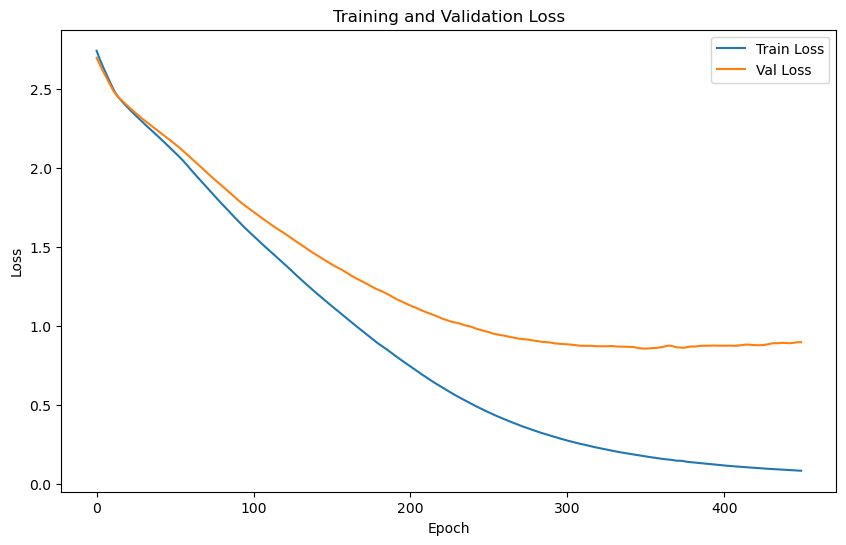

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.9940 | Test Accuracy: 73.17%


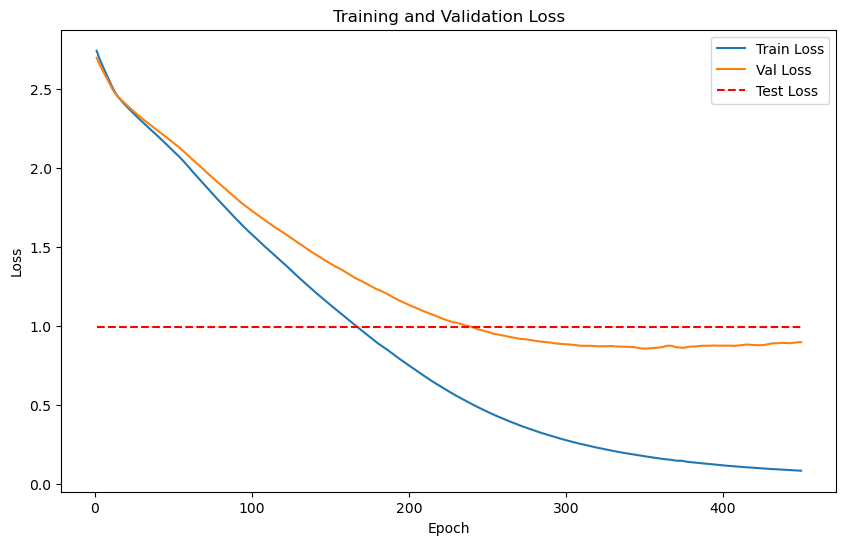

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.0929
Epoch [1/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.2894

Validation loss improved from inf to 0.2894. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.0925
Epoch [2/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.2894

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.0921
Epoch [3/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.0921
Epoch [4/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.2899

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.0920
Epoch [5/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.2901

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.0925
Epoch [6/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.2904

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.0921
Epoch [7/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.0916
Epoch [8/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.2899

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.0917
Epoch [9/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.2900

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.0913
Epoch [10/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.0910
Epoch [11/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.0884
Epoch [12/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.2883

Validation loss improved from 0.2894 to 0.2883. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.0852
Epoch [13/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.2866

Validation loss improved from 0.2883 to 0.2866. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.0817
Epoch [14/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.2851

Validation loss improved from 0.2866 to 0.2851. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.0801
Epoch [15/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.2845

Validation loss improved from 0.2851 to 0.2845. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4886
    Batch [2/2], Val Loss: 0.0780
Epoch [16/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.2833

Validation loss improved from 0.2845 to 0.2833. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.0755
Epoch [17/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.2820

Validation loss improved from 0.2833 to 0.2820. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.0719
Epoch [18/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.2806

Validation loss improved from 0.2820 to 0.2806. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.0690
Epoch [19/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.2795

Validation loss improved from 0.2806 to 0.2795. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.0679
Epoch [20/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.2793

Validation loss improved from 0.2795 to 0.2793. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.0682
Epoch [21/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.2798

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.0691
Epoch [22/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.2804

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.0693
Epoch [23/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.2807

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.0690
Epoch [24/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.2805

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.0684
Epoch [25/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.2798

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.0682
Epoch [26/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.2791

Validation loss improved from 0.2793 to 0.2791. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.0682
Epoch [27/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.2785

Validation loss improved from 0.2791 to 0.2785. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.0680
Epoch [28/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.2776

Validation loss improved from 0.2785 to 0.2776. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.0679
Epoch [29/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.2768

Validation loss improved from 0.2776 to 0.2768. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.0679
Epoch [30/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.2762

Validation loss improved from 0.2768 to 0.2762. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.0678
Epoch [31/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.2757

Validation loss improved from 0.2762 to 0.2757. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.0678
Epoch [32/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.2752

Validation loss improved from 0.2757 to 0.2752. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.0676
Epoch [33/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.2746

Validation loss improved from 0.2752 to 0.2746. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.0678
Epoch [34/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.2742

Validation loss improved from 0.2746 to 0.2742. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.0680
Epoch [35/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.2738

Validation loss improved from 0.2742 to 0.2738. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.0681
Epoch [36/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.2733

Validation loss improved from 0.2738 to 0.2733. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.0683
Epoch [37/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.2729

Validation loss improved from 0.2733 to 0.2729. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.0684
Epoch [38/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.2724

Validation loss improved from 0.2729 to 0.2724. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.0685
Epoch [39/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.2716

Validation loss improved from 0.2724 to 0.2716. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.0684
Epoch [40/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.2709

Validation loss improved from 0.2716 to 0.2709. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.0684
Epoch [41/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.2701

Validation loss improved from 0.2709 to 0.2701. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.0683
Epoch [42/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.2692

Validation loss improved from 0.2701 to 0.2692. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.0683
Epoch [43/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.2684

Validation loss improved from 0.2692 to 0.2684. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.0681
Epoch [44/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.2674

Validation loss improved from 0.2684 to 0.2674. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.0680
Epoch [45/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.2665

Validation loss improved from 0.2674 to 0.2665. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.0677
Epoch [46/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.2655

Validation loss improved from 0.2665 to 0.2655. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.0673
Epoch [47/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.2644

Validation loss improved from 0.2655 to 0.2644. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.0670
Epoch [48/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.2634

Validation loss improved from 0.2644 to 0.2634. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.0667
Epoch [49/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.2624

Validation loss improved from 0.2634 to 0.2624. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.0664
Epoch [50/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.2615

Validation loss improved from 0.2624 to 0.2615. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.0663
Epoch [51/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.2606

Validation loss improved from 0.2615 to 0.2606. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.0662
Epoch [52/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.2598

Validation loss improved from 0.2606 to 0.2598. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.0662
Epoch [53/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.2590

Validation loss improved from 0.2598 to 0.2590. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.0661
Epoch [54/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2580

Validation loss improved from 0.2590 to 0.2580. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.0660
Epoch [55/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.2570

Validation loss improved from 0.2580 to 0.2570. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.0659
Epoch [56/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2561

Validation loss improved from 0.2570 to 0.2561. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4448
    Batch [2/2], Val Loss: 0.0658
Epoch [57/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2553

Validation loss improved from 0.2561 to 0.2553. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.0656
Epoch [58/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.2547

Validation loss improved from 0.2553 to 0.2547. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.0655
Epoch [59/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2541

Validation loss improved from 0.2547 to 0.2541. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.0653
Epoch [60/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.2537

Validation loss improved from 0.2541 to 0.2537. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.0651
Epoch [61/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2534

Validation loss improved from 0.2537 to 0.2534. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.0650
Epoch [62/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.2532

Validation loss improved from 0.2534 to 0.2532. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.0648
Epoch [63/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2529

Validation loss improved from 0.2532 to 0.2529. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.0647
Epoch [64/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.0647
Epoch [65/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.0647
Epoch [66/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2525

Validation loss improved from 0.2527 to 0.2525. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.0647
Epoch [67/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.0648
Epoch [68/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.0647
Epoch [69/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2520

Validation loss improved from 0.2523 to 0.2520. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.0645
Epoch [70/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2515

Validation loss improved from 0.2520 to 0.2515. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4377
    Batch [2/2], Val Loss: 0.0643
Epoch [71/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2510

Validation loss improved from 0.2515 to 0.2510. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4367
    Batch [2/2], Val Loss: 0.0641
Epoch [72/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2504

Validation loss improved from 0.2510 to 0.2504. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.0641
Epoch [73/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2501

Validation loss improved from 0.2504 to 0.2501. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.0641
Epoch [74/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2498

Validation loss improved from 0.2501 to 0.2498. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.0642
Epoch [75/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2496

Validation loss improved from 0.2498 to 0.2496. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.0641
Epoch [76/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2494

Validation loss improved from 0.2496 to 0.2494. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.0638
Epoch [77/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2490

Validation loss improved from 0.2494 to 0.2490. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0637
Epoch [78/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2486

Validation loss improved from 0.2490 to 0.2486. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.0636
Epoch [79/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2480

Validation loss improved from 0.2486 to 0.2480. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.0634
Epoch [80/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2475

Validation loss improved from 0.2480 to 0.2475. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0633
Epoch [81/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2469

Validation loss improved from 0.2475 to 0.2469. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0630
Epoch [82/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.0628
Epoch [83/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.0624
Epoch [84/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.0620
Epoch [85/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.0618
Epoch [86/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2468

Validation loss improved from 0.2468 to 0.2468. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.0616
Epoch [87/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.0614
Epoch [88/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.0612
Epoch [89/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.0612
Epoch [90/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.0612
Epoch [91/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2465

Validation loss improved from 0.2467 to 0.2465. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.0611
Epoch [92/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.0612
Epoch [93/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2465

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.0616
Epoch [94/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2465

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.0619
Epoch [95/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0619
Epoch [96/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2460

Validation loss improved from 0.2463 to 0.2460. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.0618
Epoch [97/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2457

Validation loss improved from 0.2460 to 0.2457. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.0619
Epoch [98/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2454

Validation loss improved from 0.2457 to 0.2454. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.0621
Epoch [99/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2452

Validation loss improved from 0.2454 to 0.2452. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.0622
Epoch [100/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2449

Validation loss improved from 0.2452 to 0.2449. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.0624
Epoch [101/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0627
Epoch [102/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.0632
Epoch [103/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.0636
Epoch [104/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.0641
Epoch [105/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.0647
Epoch [106/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.0652
Epoch [107/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.0656
Epoch [108/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.0660
Epoch [109/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.0661
Epoch [110/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.0664
Epoch [111/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.0668
Epoch [112/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.0667
Epoch [113/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.0660
Epoch [114/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.0652
Epoch [115/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2444

Validation loss improved from 0.2449 to 0.2444. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0646
Epoch [116/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2434

Validation loss improved from 0.2444 to 0.2434. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.0638
Epoch [117/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2425

Validation loss improved from 0.2434 to 0.2425. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.0634
Epoch [118/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2420

Validation loss improved from 0.2425 to 0.2420. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0628
Epoch [119/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2413

Validation loss improved from 0.2420 to 0.2413. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.0623
Epoch [120/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2409

Validation loss improved from 0.2413 to 0.2409. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0616
Epoch [121/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.0611
Epoch [122/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2404

Validation loss improved from 0.2408 to 0.2404. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0607
Epoch [123/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2396

Validation loss improved from 0.2404 to 0.2396. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0603
Epoch [124/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2390

Validation loss improved from 0.2396 to 0.2390. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0597
Epoch [125/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2387

Validation loss improved from 0.2390 to 0.2387. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0592
Epoch [126/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2385

Validation loss improved from 0.2387 to 0.2385. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.0588
Epoch [127/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2379

Validation loss improved from 0.2385 to 0.2379. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0584
Epoch [128/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2374

Validation loss improved from 0.2379 to 0.2374. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.0580
Epoch [129/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2367

Validation loss improved from 0.2374 to 0.2367. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.0577
Epoch [130/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2359

Validation loss improved from 0.2367 to 0.2359. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.0578
Epoch [131/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2353

Validation loss improved from 0.2359 to 0.2353. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.0577
Epoch [132/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2347

Validation loss improved from 0.2353 to 0.2347. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.0578
Epoch [133/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2341

Validation loss improved from 0.2347 to 0.2341. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.0576
Epoch [134/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2336

Validation loss improved from 0.2341 to 0.2336. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.0577
Epoch [135/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2333

Validation loss improved from 0.2336 to 0.2333. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4082
    Batch [2/2], Val Loss: 0.0576
Epoch [136/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2329

Validation loss improved from 0.2333 to 0.2329. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4073
    Batch [2/2], Val Loss: 0.0575
Epoch [137/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2324

Validation loss improved from 0.2329 to 0.2324. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.0575
Epoch [138/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2320

Validation loss improved from 0.2324 to 0.2320. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.0574
Epoch [139/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2313

Validation loss improved from 0.2320 to 0.2313. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.0571
Epoch [140/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2307

Validation loss improved from 0.2313 to 0.2307. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.0570
Epoch [141/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2301

Validation loss improved from 0.2307 to 0.2301. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4021
    Batch [2/2], Val Loss: 0.0567
Epoch [142/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2294

Validation loss improved from 0.2301 to 0.2294. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4009
    Batch [2/2], Val Loss: 0.0565
Epoch [143/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2287

Validation loss improved from 0.2294 to 0.2287. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4003
    Batch [2/2], Val Loss: 0.0565
Epoch [144/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2284

Validation loss improved from 0.2287 to 0.2284. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.0565
Epoch [145/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2279

Validation loss improved from 0.2284 to 0.2279. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.3983
    Batch [2/2], Val Loss: 0.0565
Epoch [146/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2274

Validation loss improved from 0.2279 to 0.2274. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.0567
Epoch [147/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2274

Validation loss improved from 0.2274 to 0.2274. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.0568
Epoch [148/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2279

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.0569
Epoch [149/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0570
Epoch [150/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.0571
Epoch [151/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2289

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4009
    Batch [2/2], Val Loss: 0.0572
Epoch [152/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2291

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.0571
Epoch [153/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2291

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.0569
Epoch [154/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2293

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0562
Epoch [155/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2289

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.0560
Epoch [156/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.0557
Epoch [157/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0555
Epoch [158/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4009
    Batch [2/2], Val Loss: 0.0555
Epoch [159/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.0560
Epoch [160/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2280

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.0567
Epoch [161/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2278

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.0568
Epoch [162/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2272

Validation loss improved from 0.2274 to 0.2272. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3961
    Batch [2/2], Val Loss: 0.0568
Epoch [163/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2264

Validation loss improved from 0.2272 to 0.2264. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.0569
Epoch [164/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2255

Validation loss improved from 0.2264 to 0.2255. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3920
    Batch [2/2], Val Loss: 0.0571
Epoch [165/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2246

Validation loss improved from 0.2255 to 0.2246. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0572
Epoch [166/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2237

Validation loss improved from 0.2246 to 0.2237. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.0572
Epoch [167/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2232

Validation loss improved from 0.2237 to 0.2232. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.0575
Epoch [168/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2232

Validation loss improved from 0.2232 to 0.2232. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3888
    Batch [2/2], Val Loss: 0.0578
Epoch [169/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.0581
Epoch [170/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2231

Validation loss improved from 0.2232 to 0.2231. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.0581
Epoch [171/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0577
Epoch [172/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2225

Validation loss improved from 0.2229 to 0.2225. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.0573
Epoch [173/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2222

Validation loss improved from 0.2225 to 0.2222. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.0565
Epoch [174/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2221

Validation loss improved from 0.2222 to 0.2221. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.0559
Epoch [175/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.0553
Epoch [176/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.0548
Epoch [177/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3904
    Batch [2/2], Val Loss: 0.0542
Epoch [178/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2223

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.0536
Epoch [179/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.2223

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.0532
Epoch [180/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.3914
    Batch [2/2], Val Loss: 0.0531
Epoch [181/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2223

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.0529
Epoch [182/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2224

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.0526
Epoch [183/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.0522
Epoch [184/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2219

Validation loss improved from 0.2221 to 0.2219. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.0520
Epoch [185/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2212

Validation loss improved from 0.2219 to 0.2212. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3895
    Batch [2/2], Val Loss: 0.0515
Epoch [186/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2205

Validation loss improved from 0.2212 to 0.2205. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.0510
Epoch [187/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2197

Validation loss improved from 0.2205 to 0.2197. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.0503
Epoch [188/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2191

Validation loss improved from 0.2197 to 0.2191. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.3875
    Batch [2/2], Val Loss: 0.0496
Epoch [189/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2185

Validation loss improved from 0.2191 to 0.2185. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0491
Epoch [190/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2182

Validation loss improved from 0.2185 to 0.2182. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0486
Epoch [191/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2177

Validation loss improved from 0.2182 to 0.2177. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0484
Epoch [192/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2174

Validation loss improved from 0.2177 to 0.2174. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.0483
Epoch [193/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2172

Validation loss improved from 0.2174 to 0.2172. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.0483
Epoch [194/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2169

Validation loss improved from 0.2172 to 0.2169. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.0480
Epoch [195/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2168

Validation loss improved from 0.2169 to 0.2168. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.0479
Epoch [196/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2167

Validation loss improved from 0.2168 to 0.2167. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.0475
Epoch [197/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.2164

Validation loss improved from 0.2167 to 0.2164. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.0472
Epoch [198/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2161

Validation loss improved from 0.2164 to 0.2161. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0465
Epoch [199/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2158

Validation loss improved from 0.2161 to 0.2158. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.0458
Epoch [200/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2155

Validation loss improved from 0.2158 to 0.2155. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.0452
Epoch [201/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2152

Validation loss improved from 0.2155 to 0.2152. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.0448
Epoch [202/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.2150

Validation loss improved from 0.2152 to 0.2150. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.0445
Epoch [203/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2146

Validation loss improved from 0.2150 to 0.2146. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.0444
Epoch [204/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2143

Validation loss improved from 0.2146 to 0.2143. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3849
    Batch [2/2], Val Loss: 0.0440
Epoch [205/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.0440
Epoch [206/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.0439
Epoch [207/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.0435
Epoch [208/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.0433
Epoch [209/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.0431
Epoch [210/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0433
Epoch [211/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.0436
Epoch [212/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0442
Epoch [213/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.0450
Epoch [214/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.0456
Epoch [215/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.0464
Epoch [216/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.0469
Epoch [217/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.0472
Epoch [218/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2169

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0477
Epoch [219/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2170

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.0479
Epoch [220/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2166

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0477
Epoch [221/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2169

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.0475
Epoch [222/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0475
Epoch [223/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0471
Epoch [224/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.2174

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.0470
Epoch [225/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.0470
Epoch [226/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2176

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3356
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.0468
Epoch [227/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0465
Epoch [228/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2165

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.0465
Epoch [229/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.3840
    Batch [2/2], Val Loss: 0.0465
Epoch [230/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3265
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.0463
Epoch [231/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.2143

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.0462
Epoch [232/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2134

Validation loss improved from 0.2143 to 0.2134. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.0460
Epoch [233/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2125

Validation loss improved from 0.2134 to 0.2125. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3776
    Batch [2/2], Val Loss: 0.0459
Epoch [234/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2117

Validation loss improved from 0.2125 to 0.2117. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.0458
Epoch [235/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.2110

Validation loss improved from 0.2117 to 0.2110. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.0457
Epoch [236/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2103

Validation loss improved from 0.2110 to 0.2103. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3735
    Batch [2/2], Val Loss: 0.0457
Epoch [237/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.2096

Validation loss improved from 0.2103 to 0.2096. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3724
    Batch [2/2], Val Loss: 0.0456
Epoch [238/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2090

Validation loss improved from 0.2096 to 0.2090. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.0455
Epoch [239/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.2085

Validation loss improved from 0.2090 to 0.2085. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3706
    Batch [2/2], Val Loss: 0.0455
Epoch [240/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2081

Validation loss improved from 0.2085 to 0.2081. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.0454
Epoch [241/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2077

Validation loss improved from 0.2081 to 0.2077. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3695
    Batch [2/2], Val Loss: 0.0453
Epoch [242/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2074

Validation loss improved from 0.2077 to 0.2074. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3690
    Batch [2/2], Val Loss: 0.0453
Epoch [243/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2071

Validation loss improved from 0.2074 to 0.2071. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.0452
Epoch [244/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2069

Validation loss improved from 0.2071 to 0.2069. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0452
Epoch [245/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2068

Validation loss improved from 0.2069 to 0.2068. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.0451
Epoch [246/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2067

Validation loss improved from 0.2068 to 0.2067. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3682
    Batch [2/2], Val Loss: 0.0451
Epoch [247/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2066

Validation loss improved from 0.2067 to 0.2066. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.0451
Epoch [248/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.2066

Validation loss improved from 0.2066 to 0.2066. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.0450
Epoch [249/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2066

Validation loss improved from 0.2066 to 0.2066. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3680
    Batch [2/2], Val Loss: 0.0450
Epoch [250/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2065

Validation loss improved from 0.2066 to 0.2065. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.0449
Epoch [251/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2064

Validation loss improved from 0.2065 to 0.2064. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.0449
Epoch [252/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.2064

Validation loss improved from 0.2064 to 0.2064. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.0449
Epoch [253/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2063

Validation loss improved from 0.2064 to 0.2063. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3676
    Batch [2/2], Val Loss: 0.0448
Epoch [254/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2062

Validation loss improved from 0.2063 to 0.2062. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3676
    Batch [2/2], Val Loss: 0.0448
Epoch [255/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.2062

Validation loss improved from 0.2062 to 0.2062. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.0448
Epoch [256/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2062

Validation loss improved from 0.2062 to 0.2062. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.0448
Epoch [257/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2061

Validation loss improved from 0.2062 to 0.2061. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3311
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3674
    Batch [2/2], Val Loss: 0.0448
Epoch [258/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.2061

Validation loss improved from 0.2061 to 0.2061. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3673
    Batch [2/2], Val Loss: 0.0448
Epoch [259/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2061

Validation loss improved from 0.2061 to 0.2061. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.3672
    Batch [2/2], Val Loss: 0.0449
Epoch [260/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.2060

Validation loss improved from 0.2061 to 0.2060. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0449
Epoch [261/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2060

Validation loss improved from 0.2060 to 0.2060. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0449
Epoch [262/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2059

Validation loss improved from 0.2060 to 0.2059. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0448
Epoch [263/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0448
Epoch [264/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0448
Epoch [265/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0448
Epoch [266/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0448
Epoch [267/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0448
Epoch [268/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2058

Validation loss improved from 0.2059 to 0.2058. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0448
Epoch [269/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.2058

Validation loss improved from 0.2058 to 0.2058. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0448
Epoch [270/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2058

Validation loss improved from 0.2058 to 0.2058. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0448
Epoch [271/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2057

Validation loss improved from 0.2058 to 0.2057. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0448
Epoch [272/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2057

Validation loss improved from 0.2057 to 0.2057. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0448
Epoch [273/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2057

Validation loss improved from 0.2057 to 0.2057. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0448
Epoch [274/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2057

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0449
Epoch [275/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2057

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0448
Epoch [276/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2057

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0448
Epoch [277/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2057

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0448
Epoch [278/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0448
Epoch [279/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0447
Epoch [280/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0447
Epoch [281/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0447
Epoch [282/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0447
Epoch [283/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0448
Epoch [284/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0448
Epoch [285/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3311
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0447
Epoch [286/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0447
Epoch [287/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.0447
Epoch [288/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0447
Epoch [289/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0447
Epoch [290/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0446
Epoch [291/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0446
Epoch [292/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0445
Epoch [293/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2057

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.0445
Epoch [294/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.2057

Validation loss improved from 0.2057 to 0.2057. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0445
Epoch [295/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2057

Validation loss improved from 0.2057 to 0.2057. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0445
Epoch [296/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2056

Validation loss improved from 0.2057 to 0.2056. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0444
Epoch [297/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2056

Validation loss improved from 0.2056 to 0.2056. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0444
Epoch [298/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2056

Validation loss improved from 0.2056 to 0.2056. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0444
Epoch [299/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.2056

Validation loss improved from 0.2056 to 0.2056. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0444
Epoch [300/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2055

Validation loss improved from 0.2056 to 0.2055. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0444
Epoch [301/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2055

Validation loss improved from 0.2055 to 0.2055. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0444
Epoch [302/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2055

Validation loss improved from 0.2055 to 0.2055. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0444
Epoch [303/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0444
Epoch [304/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0444
Epoch [305/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0444
Epoch [306/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0444
Epoch [307/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.2055

Validation loss improved from 0.2055 to 0.2055. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0444
Epoch [308/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0444
Epoch [309/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0445
Epoch [310/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0445
Epoch [311/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0445
Epoch [312/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0445
Epoch [313/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0446
Epoch [314/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0446
Epoch [315/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0446
Epoch [316/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.0446
Epoch [317/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3665
    Batch [2/2], Val Loss: 0.0446
Epoch [318/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [319/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [320/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [321/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [322/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.2055

Validation loss improved from 0.2055 to 0.2055. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.0447
Epoch [323/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2055

Validation loss improved from 0.2055 to 0.2055. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [324/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [325/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [326/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [327/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [328/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [329/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [330/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [331/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [332/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [333/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0447
Epoch [334/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.0447
Epoch [335/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.0447
Epoch [336/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2055

Validation loss improved from 0.2055 to 0.2055. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.0447
Epoch [337/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.2054

Validation loss improved from 0.2055 to 0.2054. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.0447
Epoch [338/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2053

Validation loss improved from 0.2054 to 0.2053. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.0447
Epoch [339/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2053

Validation loss improved from 0.2053 to 0.2053. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0447
Epoch [340/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.2052

Validation loss improved from 0.2053 to 0.2052. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.0447
Epoch [341/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2052

Validation loss improved from 0.2052 to 0.2052. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0447
Epoch [342/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2052

Validation loss improved from 0.2052 to 0.2052. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0447
Epoch [343/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2051

Validation loss improved from 0.2052 to 0.2051. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0447
Epoch [344/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.2051

Validation loss improved from 0.2051 to 0.2051. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0447
Epoch [345/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2051

Validation loss improved from 0.2051 to 0.2051. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0447
Epoch [346/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.2050

Validation loss improved from 0.2051 to 0.2050. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0447
Epoch [347/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2049

Validation loss improved from 0.2050 to 0.2049. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0447
Epoch [348/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0447
Epoch [349/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2048

Validation loss improved from 0.2049 to 0.2048. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0447
Epoch [350/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0447
Epoch [351/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0446
Epoch [352/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0446
Epoch [353/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0446
Epoch [354/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.2047

Validation loss improved from 0.2048 to 0.2047. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3244
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0445
Epoch [355/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0445
Epoch [356/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0445
Epoch [357/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2046

Validation loss improved from 0.2047 to 0.2046. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0444
Epoch [358/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.0444
Epoch [359/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0444
Epoch [360/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0443
Epoch [361/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0443
Epoch [362/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0443
Epoch [363/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3654
    Batch [2/2], Val Loss: 0.0442
Epoch [364/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0442
Epoch [365/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0442
Epoch [366/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0441
Epoch [367/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0441
Epoch [368/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.0441
Epoch [369/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0440
Epoch [370/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0440
Epoch [371/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0439
Epoch [372/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.0439
Epoch [373/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0439
Epoch [374/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0438
Epoch [375/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3265
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0438
Epoch [376/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.0438
Epoch [377/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.0437
Epoch [378/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0437
Epoch [379/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0437
Epoch [380/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0437
Epoch [381/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3151
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0437
Epoch [382/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0437
Epoch [383/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0436
Epoch [384/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0436
Epoch [385/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.0436
Epoch [386/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0436
Epoch [387/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0436
Epoch [388/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2045

Validation loss improved from 0.2046 to 0.2045. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3654
    Batch [2/2], Val Loss: 0.0436
Epoch [389/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0436
Epoch [390/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2044

Validation loss improved from 0.2045 to 0.2044. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0436
Epoch [391/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0436
Epoch [392/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0436
Epoch [393/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0436
Epoch [394/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2043

Validation loss improved from 0.2044 to 0.2043. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0436
Epoch [395/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0436
Epoch [396/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0436
Epoch [397/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0436
Epoch [398/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0437
Epoch [399/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3654
    Batch [2/2], Val Loss: 0.0437
Epoch [400/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0436
Epoch [401/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.0436
Epoch [402/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0436
Epoch [403/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.0436
Epoch [404/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.0436
Epoch [405/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.0436
Epoch [406/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0437
Epoch [407/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2042

Validation loss improved from 0.2043 to 0.2042. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.0437
Epoch [408/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2042

Validation loss improved from 0.2042 to 0.2042. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.0437
Epoch [409/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2042

Validation loss improved from 0.2042 to 0.2042. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0437
Epoch [410/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2042

Validation loss improved from 0.2042 to 0.2042. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0437
Epoch [411/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2041

Validation loss improved from 0.2042 to 0.2041. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0437
Epoch [412/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2041

Validation loss improved from 0.2041 to 0.2041. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0437
Epoch [413/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2041

Validation loss improved from 0.2041 to 0.2041. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0436
Epoch [414/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2041

Validation loss improved from 0.2041 to 0.2041. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0436
Epoch [415/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0436
Epoch [416/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0436
Epoch [417/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0436
Epoch [418/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0436
Epoch [419/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0436
Epoch [420/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0436
Epoch [421/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0436
Epoch [422/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2041

Validation loss improved from 0.2041 to 0.2041. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0436
Epoch [423/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2040

Validation loss improved from 0.2041 to 0.2040. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0436
Epoch [424/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2040

Validation loss improved from 0.2040 to 0.2040. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0436
Epoch [425/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0436
Epoch [426/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0435
Epoch [427/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0435
Epoch [428/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.0435
Epoch [429/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.0435
Epoch [430/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0435
Epoch [431/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0434
Epoch [432/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0434
Epoch [433/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0434
Epoch [434/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0434
Epoch [435/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.0435
Epoch [436/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0435
Epoch [437/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.0435
Epoch [438/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0435
Epoch [439/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2040

Validation loss improved from 0.2040 to 0.2040. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0436
Epoch [440/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2040

Validation loss improved from 0.2040 to 0.2040. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0436
Epoch [441/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2040

Validation loss improved from 0.2040 to 0.2040. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0435
Epoch [442/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2040

Validation loss improved from 0.2040 to 0.2040. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0435
Epoch [443/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2039

Validation loss improved from 0.2040 to 0.2039. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0435
Epoch [444/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2039

Validation loss improved from 0.2039 to 0.2039. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0434
Epoch [445/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2039

Validation loss improved from 0.2039 to 0.2039. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0434
Epoch [446/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.2039

Validation loss improved from 0.2039 to 0.2039. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0433
Epoch [447/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2038

Validation loss improved from 0.2039 to 0.2038. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0433
Epoch [448/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2038

Validation loss improved from 0.2038 to 0.2038. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0432
Epoch [449/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2037

Validation loss improved from 0.2038 to 0.2037. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0432
Epoch [450/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2037

Validation loss improved from 0.2037 to 0.2037. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0431
Epoch [451/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2037

Validation loss improved from 0.2037 to 0.2037. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0431
Epoch [452/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2037

Validation loss improved from 0.2037 to 0.2037. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0431
Epoch [453/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2037

Validation loss improved from 0.2037 to 0.2037. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0430
Epoch [454/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2036

Validation loss improved from 0.2037 to 0.2036. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0430
Epoch [455/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2036

Validation loss improved from 0.2036 to 0.2036. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0430
Epoch [456/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2036

Validation loss improved from 0.2036 to 0.2036. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0430
Epoch [457/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2036

Validation loss improved from 0.2036 to 0.2036. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0430
Epoch [458/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0430
Epoch [459/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0430
Epoch [460/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0429
Epoch [461/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2036

Validation loss improved from 0.2036 to 0.2036. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0429
Epoch [462/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2036

Validation loss improved from 0.2036 to 0.2036. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0429
Epoch [463/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.2035

Validation loss improved from 0.2036 to 0.2035. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0428
Epoch [464/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2035

Validation loss improved from 0.2035 to 0.2035. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0428
Epoch [465/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2035

Validation loss improved from 0.2035 to 0.2035. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0428
Epoch [466/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.2035

Validation loss improved from 0.2035 to 0.2035. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0428
Epoch [467/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2035

Validation loss improved from 0.2035 to 0.2035. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.0428
Epoch [468/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.2034

Validation loss improved from 0.2035 to 0.2034. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.0428
Epoch [469/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2034

Validation loss improved from 0.2034 to 0.2034. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.0428
Epoch [470/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2033

Validation loss improved from 0.2034 to 0.2033. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.0428
Epoch [471/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.2032

Validation loss improved from 0.2033 to 0.2032. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.0428
Epoch [472/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2032

Validation loss improved from 0.2032 to 0.2032. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0428
Epoch [473/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2031

Validation loss improved from 0.2032 to 0.2031. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0428
Epoch [474/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.2030

Validation loss improved from 0.2031 to 0.2030. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0428
Epoch [475/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2030

Validation loss improved from 0.2030 to 0.2030. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0428
Epoch [476/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2029

Validation loss improved from 0.2030 to 0.2029. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0428
Epoch [477/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2029

Validation loss improved from 0.2029 to 0.2029. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0428
Epoch [478/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2028

Validation loss improved from 0.2029 to 0.2028. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0428
Epoch [479/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2028

Validation loss improved from 0.2028 to 0.2028. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0428
Epoch [480/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2028

Validation loss improved from 0.2028 to 0.2028. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0428
Epoch [481/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [482/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [483/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [484/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [485/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [486/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [487/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [488/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [489/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [490/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0429
Epoch [491/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0429
Epoch [492/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0429
Epoch [493/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0429
Epoch [494/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0429
Epoch [495/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0430
Epoch [496/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0430
Epoch [497/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0430
Epoch [498/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0429
Epoch [499/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0429
Epoch [500/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.0429
Epoch [501/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2032

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.0429
Epoch [502/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2032

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.0429
Epoch [503/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2033

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.0429
Epoch [504/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2033

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.0428
Epoch [505/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2033

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.0428
Epoch [506/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.2033

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.0428
Epoch [507/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2032

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.0428
Epoch [508/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2032

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.0428
Epoch [509/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2032

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.0428
Epoch [510/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.0428
Epoch [511/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0428
Epoch [512/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0428
Epoch [513/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0428
Epoch [514/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0428
Epoch [515/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0428
Epoch [516/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0428
Epoch [517/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0428
Epoch [518/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0428
Epoch [519/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0428
Epoch [520/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0428
Epoch [521/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0428
Epoch [522/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [523/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [524/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [525/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [526/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0429
Epoch [527/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [528/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [529/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [530/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [531/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [532/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [533/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [534/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [535/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [536/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [537/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [538/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [539/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [540/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [541/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [542/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [543/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [544/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [545/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [546/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [547/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [548/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [549/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [550/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [551/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [552/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [553/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [554/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3141
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [555/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [556/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [557/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [558/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [559/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [560/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [561/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [562/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [563/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [564/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [565/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [566/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [567/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [568/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [569/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [570/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [571/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [572/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [573/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [574/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [575/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [576/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [577/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [578/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [579/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0429
Epoch [580/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 580!!
No improvement for 100 epochs


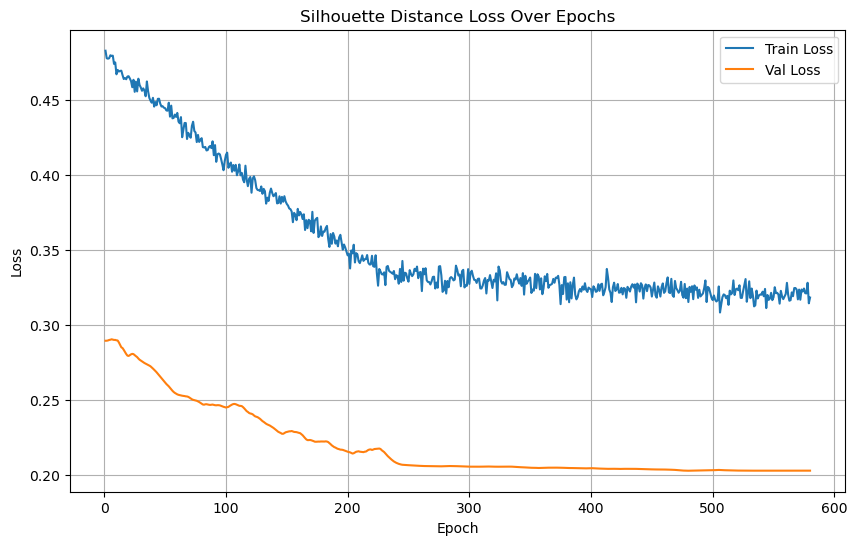

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/48], Loss: 0.2770


Test Batch [20/48], Loss: 0.2096
Test Batch [30/48], Loss: 0.2748
Test Batch [40/48], Loss: 0.5000

Test Loss: 0.2790


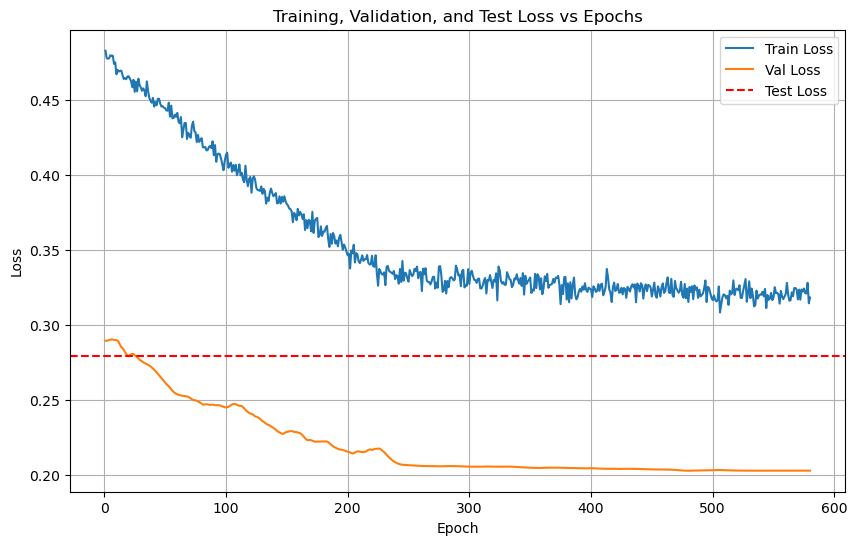

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/48 for test dataset.
  Processed batch 20/48 for test dataset.


  Processed batch 30/48 for test dataset.
  Processed batch 40/48 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       0.50      0.20      0.29         5
           5       0.50      0.60      0.55         5
           6       1.00      0.80      0.89         5
           7       0.83      1.00      0.91         5
           8       0.75      0.60      0.67         5
           9       0.80      0.80      0.80         5
          10       1.00      0.60      0.75         5
          11       1.00      1.00      1.00         5
          12       0.56      1.00      0.71         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5509  |  Val Loss: 2.5476
Validation loss improved from inf to 2.5476.
[Epoch 2/1000] Train Loss: 2.5300  |  Val Loss: 2.5310
Validation loss improved from 2.5476 to 2.5310.
[Epoch 3/1000] Train Loss: 2.5104  |  Val Loss: 2.5155
Validation loss improved from 2.5310 to 2.5155.
[Epoch 4/1000] Train Loss: 2.4923  |  Val Loss: 2.4999
Validation loss improved from 2.5155 to 2.4999.
[Epoch 5/1000] Train Loss: 2.4745  |  Val Loss: 2.4845
Validation loss improved from 2.4999 to 2.4845.
[Epoch 6/1000] Train Loss: 2.4571  |  Val Loss: 2.4700
Validation loss improved from 2.4845 to 2.4700.
[Epoch 7/1000] Train Loss: 2.4394  |  Val Loss: 2.4558
Validation loss improved from 2.4700 to 2.4558.
[Epoch 8/1000] Train Loss: 2.4228  |  Val Loss: 2.4417
Validation loss improved from 2.4558 to 2.4417.
[Epoch 9/1000] Train Loss: 2.4063  |  Val Loss: 2.4281
Validation loss improved from 2.4417 to 2.4281.
[Epoch 10/1000] Train Loss: 2.3911  |  Val Loss: 2.4147
Validation loss impr

[Epoch 16/1000] Train Loss: 2.3049  |  Val Loss: 2.3427
Validation loss improved from 2.3536 to 2.3427.
[Epoch 17/1000] Train Loss: 2.2917  |  Val Loss: 2.3320
Validation loss improved from 2.3427 to 2.3320.
[Epoch 18/1000] Train Loss: 2.2782  |  Val Loss: 2.3214
Validation loss improved from 2.3320 to 2.3214.
[Epoch 19/1000] Train Loss: 2.2653  |  Val Loss: 2.3105
Validation loss improved from 2.3214 to 2.3105.
[Epoch 20/1000] Train Loss: 2.2526  |  Val Loss: 2.2996
Validation loss improved from 2.3105 to 2.2996.
[Epoch 21/1000] Train Loss: 2.2398  |  Val Loss: 2.2886
Validation loss improved from 2.2996 to 2.2886.
[Epoch 22/1000] Train Loss: 2.2275  |  Val Loss: 2.2775
Validation loss improved from 2.2886 to 2.2775.
[Epoch 23/1000] Train Loss: 2.2151  |  Val Loss: 2.2662
Validation loss improved from 2.2775 to 2.2662.
[Epoch 24/1000] Train Loss: 2.2025  |  Val Loss: 2.2553
Validation loss improved from 2.2662 to 2.2553.


[Epoch 25/1000] Train Loss: 2.1904  |  Val Loss: 2.2448
Validation loss improved from 2.2553 to 2.2448.
[Epoch 26/1000] Train Loss: 2.1789  |  Val Loss: 2.2343
Validation loss improved from 2.2448 to 2.2343.
[Epoch 27/1000] Train Loss: 2.1666  |  Val Loss: 2.2235
Validation loss improved from 2.2343 to 2.2235.
[Epoch 28/1000] Train Loss: 2.1552  |  Val Loss: 2.2126
Validation loss improved from 2.2235 to 2.2126.
[Epoch 29/1000] Train Loss: 2.1432  |  Val Loss: 2.2019
Validation loss improved from 2.2126 to 2.2019.
[Epoch 30/1000] Train Loss: 2.1314  |  Val Loss: 2.1912
Validation loss improved from 2.2019 to 2.1912.
[Epoch 31/1000] Train Loss: 2.1196  |  Val Loss: 2.1809
Validation loss improved from 2.1912 to 2.1809.
[Epoch 32/1000] Train Loss: 2.1081  |  Val Loss: 2.1706
Validation loss improved from 2.1809 to 2.1706.
[Epoch 33/1000] Train Loss: 2.0968  |  Val Loss: 2.1603
Validation loss improved from 2.1706 to 2.1603.
[Epoch 34/1000] Train Loss: 2.0849  |  Val Loss: 2.1505
Validati

[Epoch 47/1000] Train Loss: 1.9404  |  Val Loss: 2.0270
Validation loss improved from 2.0362 to 2.0270.
[Epoch 48/1000] Train Loss: 1.9294  |  Val Loss: 2.0176
Validation loss improved from 2.0270 to 2.0176.
[Epoch 49/1000] Train Loss: 1.9184  |  Val Loss: 2.0083
Validation loss improved from 2.0176 to 2.0083.
[Epoch 50/1000] Train Loss: 1.9070  |  Val Loss: 1.9991
Validation loss improved from 2.0083 to 1.9991.
[Epoch 51/1000] Train Loss: 1.8957  |  Val Loss: 1.9900
Validation loss improved from 1.9991 to 1.9900.
[Epoch 52/1000] Train Loss: 1.8847  |  Val Loss: 1.9806
Validation loss improved from 1.9900 to 1.9806.
[Epoch 53/1000] Train Loss: 1.8734  |  Val Loss: 1.9708
Validation loss improved from 1.9806 to 1.9708.
[Epoch 54/1000] Train Loss: 1.8619  |  Val Loss: 1.9614
Validation loss improved from 1.9708 to 1.9614.
[Epoch 55/1000] Train Loss: 1.8506  |  Val Loss: 1.9521
Validation loss improved from 1.9614 to 1.9521.
[Epoch 56/1000] Train Loss: 1.8396  |  Val Loss: 1.9426
Validati

[Epoch 58/1000] Train Loss: 1.8169  |  Val Loss: 1.9242
Validation loss improved from 1.9334 to 1.9242.
[Epoch 59/1000] Train Loss: 1.8054  |  Val Loss: 1.9147
Validation loss improved from 1.9242 to 1.9147.
[Epoch 60/1000] Train Loss: 1.7941  |  Val Loss: 1.9053
Validation loss improved from 1.9147 to 1.9053.
[Epoch 61/1000] Train Loss: 1.7823  |  Val Loss: 1.8960
Validation loss improved from 1.9053 to 1.8960.
[Epoch 62/1000] Train Loss: 1.7708  |  Val Loss: 1.8866
Validation loss improved from 1.8960 to 1.8866.
[Epoch 63/1000] Train Loss: 1.7594  |  Val Loss: 1.8773
Validation loss improved from 1.8866 to 1.8773.
[Epoch 64/1000] Train Loss: 1.7480  |  Val Loss: 1.8680
Validation loss improved from 1.8773 to 1.8680.
[Epoch 65/1000] Train Loss: 1.7366  |  Val Loss: 1.8588
Validation loss improved from 1.8680 to 1.8588.
[Epoch 66/1000] Train Loss: 1.7252  |  Val Loss: 1.8495
Validation loss improved from 1.8588 to 1.8495.
[Epoch 67/1000] Train Loss: 1.7140  |  Val Loss: 1.8402
Validati

[Epoch 75/1000] Train Loss: 1.6222  |  Val Loss: 1.7650
Validation loss improved from 1.7744 to 1.7650.
[Epoch 76/1000] Train Loss: 1.6108  |  Val Loss: 1.7556
Validation loss improved from 1.7650 to 1.7556.
[Epoch 77/1000] Train Loss: 1.5992  |  Val Loss: 1.7462
Validation loss improved from 1.7556 to 1.7462.
[Epoch 78/1000] Train Loss: 1.5879  |  Val Loss: 1.7368
Validation loss improved from 1.7462 to 1.7368.
[Epoch 79/1000] Train Loss: 1.5766  |  Val Loss: 1.7276
Validation loss improved from 1.7368 to 1.7276.
[Epoch 80/1000] Train Loss: 1.5652  |  Val Loss: 1.7184
Validation loss improved from 1.7276 to 1.7184.
[Epoch 81/1000] Train Loss: 1.5539  |  Val Loss: 1.7090
Validation loss improved from 1.7184 to 1.7090.
[Epoch 82/1000] Train Loss: 1.5426  |  Val Loss: 1.6998
Validation loss improved from 1.7090 to 1.6998.
[Epoch 83/1000] Train Loss: 1.5314  |  Val Loss: 1.6905
Validation loss improved from 1.6998 to 1.6905.
[Epoch 84/1000] Train Loss: 1.5202  |  Val Loss: 1.6812
Validati

[Epoch 88/1000] Train Loss: 1.4754  |  Val Loss: 1.6450
Validation loss improved from 1.6541 to 1.6450.
[Epoch 89/1000] Train Loss: 1.4640  |  Val Loss: 1.6357
Validation loss improved from 1.6450 to 1.6357.
[Epoch 90/1000] Train Loss: 1.4528  |  Val Loss: 1.6263
Validation loss improved from 1.6357 to 1.6263.
[Epoch 91/1000] Train Loss: 1.4410  |  Val Loss: 1.6168
Validation loss improved from 1.6263 to 1.6168.
[Epoch 92/1000] Train Loss: 1.4294  |  Val Loss: 1.6072
Validation loss improved from 1.6168 to 1.6072.
[Epoch 93/1000] Train Loss: 1.4178  |  Val Loss: 1.5977
Validation loss improved from 1.6072 to 1.5977.
[Epoch 94/1000] Train Loss: 1.4060  |  Val Loss: 1.5880
Validation loss improved from 1.5977 to 1.5880.
[Epoch 95/1000] Train Loss: 1.3944  |  Val Loss: 1.5783
Validation loss improved from 1.5880 to 1.5783.
[Epoch 96/1000] Train Loss: 1.3826  |  Val Loss: 1.5688
Validation loss improved from 1.5783 to 1.5688.
[Epoch 97/1000] Train Loss: 1.3709  |  Val Loss: 1.5593
Validati

[Epoch 105/1000] Train Loss: 1.2773  |  Val Loss: 1.4817
Validation loss improved from 1.4915 to 1.4817.
[Epoch 106/1000] Train Loss: 1.2657  |  Val Loss: 1.4718
Validation loss improved from 1.4817 to 1.4718.
[Epoch 107/1000] Train Loss: 1.2541  |  Val Loss: 1.4618
Validation loss improved from 1.4718 to 1.4618.
[Epoch 108/1000] Train Loss: 1.2419  |  Val Loss: 1.4519
Validation loss improved from 1.4618 to 1.4519.
[Epoch 109/1000] Train Loss: 1.2301  |  Val Loss: 1.4421
Validation loss improved from 1.4519 to 1.4421.
[Epoch 110/1000] Train Loss: 1.2183  |  Val Loss: 1.4322
Validation loss improved from 1.4421 to 1.4322.
[Epoch 111/1000] Train Loss: 1.2062  |  Val Loss: 1.4225
Validation loss improved from 1.4322 to 1.4225.
[Epoch 112/1000] Train Loss: 1.1943  |  Val Loss: 1.4126
Validation loss improved from 1.4225 to 1.4126.
[Epoch 113/1000] Train Loss: 1.1827  |  Val Loss: 1.4025
Validation loss improved from 1.4126 to 1.4025.
[Epoch 114/1000] Train Loss: 1.1704  |  Val Loss: 1.392

[Epoch 119/1000] Train Loss: 1.1102  |  Val Loss: 1.3425
Validation loss improved from 1.3525 to 1.3425.
[Epoch 120/1000] Train Loss: 1.0978  |  Val Loss: 1.3323
Validation loss improved from 1.3425 to 1.3323.
[Epoch 121/1000] Train Loss: 1.0854  |  Val Loss: 1.3221
Validation loss improved from 1.3323 to 1.3221.
[Epoch 122/1000] Train Loss: 1.0727  |  Val Loss: 1.3117
Validation loss improved from 1.3221 to 1.3117.
[Epoch 123/1000] Train Loss: 1.0603  |  Val Loss: 1.3014
Validation loss improved from 1.3117 to 1.3014.
[Epoch 124/1000] Train Loss: 1.0477  |  Val Loss: 1.2914
Validation loss improved from 1.3014 to 1.2914.
[Epoch 125/1000] Train Loss: 1.0353  |  Val Loss: 1.2813
Validation loss improved from 1.2914 to 1.2813.
[Epoch 126/1000] Train Loss: 1.0233  |  Val Loss: 1.2710
Validation loss improved from 1.2813 to 1.2710.
[Epoch 127/1000] Train Loss: 1.0109  |  Val Loss: 1.2610
Validation loss improved from 1.2710 to 1.2610.
[Epoch 128/1000] Train Loss: 0.9986  |  Val Loss: 1.251

[Epoch 137/1000] Train Loss: 0.8929  |  Val Loss: 1.1645
Validation loss improved from 1.1739 to 1.1645.
[Epoch 138/1000] Train Loss: 0.8816  |  Val Loss: 1.1551
Validation loss improved from 1.1645 to 1.1551.
[Epoch 139/1000] Train Loss: 0.8703  |  Val Loss: 1.1459
Validation loss improved from 1.1551 to 1.1459.
[Epoch 140/1000] Train Loss: 0.8591  |  Val Loss: 1.1368
Validation loss improved from 1.1459 to 1.1368.
[Epoch 141/1000] Train Loss: 0.8480  |  Val Loss: 1.1279
Validation loss improved from 1.1368 to 1.1279.
[Epoch 142/1000] Train Loss: 0.8373  |  Val Loss: 1.1189
Validation loss improved from 1.1279 to 1.1189.
[Epoch 143/1000] Train Loss: 0.8261  |  Val Loss: 1.1100
Validation loss improved from 1.1189 to 1.1100.
[Epoch 144/1000] Train Loss: 0.8148  |  Val Loss: 1.1010
Validation loss improved from 1.1100 to 1.1010.
[Epoch 145/1000] Train Loss: 0.8044  |  Val Loss: 1.0919
Validation loss improved from 1.1010 to 1.0919.
[Epoch 146/1000] Train Loss: 0.7932  |  Val Loss: 1.083

[Epoch 150/1000] Train Loss: 0.7501  |  Val Loss: 1.0473
Validation loss improved from 1.0562 to 1.0473.
[Epoch 151/1000] Train Loss: 0.7394  |  Val Loss: 1.0385
Validation loss improved from 1.0473 to 1.0385.
[Epoch 152/1000] Train Loss: 0.7290  |  Val Loss: 1.0301
Validation loss improved from 1.0385 to 1.0301.
[Epoch 153/1000] Train Loss: 0.7188  |  Val Loss: 1.0218
Validation loss improved from 1.0301 to 1.0218.
[Epoch 154/1000] Train Loss: 0.7088  |  Val Loss: 1.0139
Validation loss improved from 1.0218 to 1.0139.
[Epoch 155/1000] Train Loss: 0.6989  |  Val Loss: 1.0062
Validation loss improved from 1.0139 to 1.0062.
[Epoch 156/1000] Train Loss: 0.6889  |  Val Loss: 0.9986
Validation loss improved from 1.0062 to 0.9986.
[Epoch 157/1000] Train Loss: 0.6792  |  Val Loss: 0.9908
Validation loss improved from 0.9986 to 0.9908.
[Epoch 158/1000] Train Loss: 0.6692  |  Val Loss: 0.9832
Validation loss improved from 0.9908 to 0.9832.
[Epoch 159/1000] Train Loss: 0.6596  |  Val Loss: 0.976

[Epoch 166/1000] Train Loss: 0.5960  |  Val Loss: 0.9266
Validation loss improved from 0.9335 to 0.9266.
[Epoch 167/1000] Train Loss: 0.5870  |  Val Loss: 0.9199
Validation loss improved from 0.9266 to 0.9199.
[Epoch 168/1000] Train Loss: 0.5784  |  Val Loss: 0.9130
Validation loss improved from 0.9199 to 0.9130.
[Epoch 169/1000] Train Loss: 0.5700  |  Val Loss: 0.9063
Validation loss improved from 0.9130 to 0.9063.
[Epoch 170/1000] Train Loss: 0.5609  |  Val Loss: 0.8997
Validation loss improved from 0.9063 to 0.8997.
[Epoch 171/1000] Train Loss: 0.5524  |  Val Loss: 0.8928
Validation loss improved from 0.8997 to 0.8928.
[Epoch 172/1000] Train Loss: 0.5440  |  Val Loss: 0.8858
Validation loss improved from 0.8928 to 0.8858.
[Epoch 173/1000] Train Loss: 0.5356  |  Val Loss: 0.8791
Validation loss improved from 0.8858 to 0.8791.
[Epoch 174/1000] Train Loss: 0.5275  |  Val Loss: 0.8724
Validation loss improved from 0.8791 to 0.8724.
[Epoch 175/1000] Train Loss: 0.5194  |  Val Loss: 0.866

[Epoch 182/1000] Train Loss: 0.4681  |  Val Loss: 0.8278
Validation loss improved from 0.8332 to 0.8278.
[Epoch 183/1000] Train Loss: 0.4613  |  Val Loss: 0.8224
Validation loss improved from 0.8278 to 0.8224.
[Epoch 184/1000] Train Loss: 0.4546  |  Val Loss: 0.8172
Validation loss improved from 0.8224 to 0.8172.
[Epoch 185/1000] Train Loss: 0.4478  |  Val Loss: 0.8123
Validation loss improved from 0.8172 to 0.8123.
[Epoch 186/1000] Train Loss: 0.4415  |  Val Loss: 0.8073
Validation loss improved from 0.8123 to 0.8073.
[Epoch 187/1000] Train Loss: 0.4350  |  Val Loss: 0.8019
Validation loss improved from 0.8073 to 0.8019.
[Epoch 188/1000] Train Loss: 0.4287  |  Val Loss: 0.7966
Validation loss improved from 0.8019 to 0.7966.
[Epoch 189/1000] Train Loss: 0.4221  |  Val Loss: 0.7915
Validation loss improved from 0.7966 to 0.7915.
[Epoch 190/1000] Train Loss: 0.4156  |  Val Loss: 0.7866
Validation loss improved from 0.7915 to 0.7866.
[Epoch 191/1000] Train Loss: 0.4097  |  Val Loss: 0.781

[Epoch 197/1000] Train Loss: 0.3752  |  Val Loss: 0.7554
Validation loss improved from 0.7595 to 0.7554.
[Epoch 198/1000] Train Loss: 0.3697  |  Val Loss: 0.7514
Validation loss improved from 0.7554 to 0.7514.
[Epoch 199/1000] Train Loss: 0.3643  |  Val Loss: 0.7474
Validation loss improved from 0.7514 to 0.7474.
[Epoch 200/1000] Train Loss: 0.3591  |  Val Loss: 0.7436
Validation loss improved from 0.7474 to 0.7436.
[Epoch 201/1000] Train Loss: 0.3539  |  Val Loss: 0.7400
Validation loss improved from 0.7436 to 0.7400.
[Epoch 202/1000] Train Loss: 0.3490  |  Val Loss: 0.7368
Validation loss improved from 0.7400 to 0.7368.
[Epoch 203/1000] Train Loss: 0.3441  |  Val Loss: 0.7337
Validation loss improved from 0.7368 to 0.7337.
[Epoch 204/1000] Train Loss: 0.3395  |  Val Loss: 0.7302
Validation loss improved from 0.7337 to 0.7302.
[Epoch 205/1000] Train Loss: 0.3345  |  Val Loss: 0.7269
Validation loss improved from 0.7302 to 0.7269.
[Epoch 206/1000] Train Loss: 0.3300  |  Val Loss: 0.724

[Epoch 211/1000] Train Loss: 0.3076  |  Val Loss: 0.7092
Validation loss improved from 0.7117 to 0.7092.
[Epoch 212/1000] Train Loss: 0.3034  |  Val Loss: 0.7066
Validation loss improved from 0.7092 to 0.7066.
[Epoch 213/1000] Train Loss: 0.2990  |  Val Loss: 0.7038
Validation loss improved from 0.7066 to 0.7038.
[Epoch 214/1000] Train Loss: 0.2950  |  Val Loss: 0.7010
Validation loss improved from 0.7038 to 0.7010.
[Epoch 215/1000] Train Loss: 0.2910  |  Val Loss: 0.6982
Validation loss improved from 0.7010 to 0.6982.
[Epoch 216/1000] Train Loss: 0.2872  |  Val Loss: 0.6955
Validation loss improved from 0.6982 to 0.6955.
[Epoch 217/1000] Train Loss: 0.2833  |  Val Loss: 0.6926
Validation loss improved from 0.6955 to 0.6926.
[Epoch 218/1000] Train Loss: 0.2796  |  Val Loss: 0.6901
Validation loss improved from 0.6926 to 0.6901.
[Epoch 219/1000] Train Loss: 0.2761  |  Val Loss: 0.6877
Validation loss improved from 0.6901 to 0.6877.
[Epoch 220/1000] Train Loss: 0.2724  |  Val Loss: 0.685

[Epoch 226/1000] Train Loss: 0.2514  |  Val Loss: 0.6722
Validation loss improved from 0.6745 to 0.6722.
[Epoch 227/1000] Train Loss: 0.2482  |  Val Loss: 0.6704
Validation loss improved from 0.6722 to 0.6704.
[Epoch 228/1000] Train Loss: 0.2450  |  Val Loss: 0.6687
Validation loss improved from 0.6704 to 0.6687.
[Epoch 229/1000] Train Loss: 0.2418  |  Val Loss: 0.6669
Validation loss improved from 0.6687 to 0.6669.
[Epoch 230/1000] Train Loss: 0.2388  |  Val Loss: 0.6654
Validation loss improved from 0.6669 to 0.6654.
[Epoch 231/1000] Train Loss: 0.2358  |  Val Loss: 0.6637
Validation loss improved from 0.6654 to 0.6637.
[Epoch 232/1000] Train Loss: 0.2328  |  Val Loss: 0.6623
Validation loss improved from 0.6637 to 0.6623.
[Epoch 233/1000] Train Loss: 0.2299  |  Val Loss: 0.6612
Validation loss improved from 0.6623 to 0.6612.
[Epoch 234/1000] Train Loss: 0.2271  |  Val Loss: 0.6599
Validation loss improved from 0.6612 to 0.6599.
[Epoch 235/1000] Train Loss: 0.2243  |  Val Loss: 0.658

[Epoch 240/1000] Train Loss: 0.2107  |  Val Loss: 0.6458
Validation loss improved from 0.6483 to 0.6458.
[Epoch 241/1000] Train Loss: 0.2082  |  Val Loss: 0.6430
Validation loss improved from 0.6458 to 0.6430.
[Epoch 242/1000] Train Loss: 0.2056  |  Val Loss: 0.6409
Validation loss improved from 0.6430 to 0.6409.
[Epoch 243/1000] Train Loss: 0.2033  |  Val Loss: 0.6388
Validation loss improved from 0.6409 to 0.6388.
[Epoch 244/1000] Train Loss: 0.2010  |  Val Loss: 0.6375
Validation loss improved from 0.6388 to 0.6375.
[Epoch 245/1000] Train Loss: 0.1986  |  Val Loss: 0.6362
Validation loss improved from 0.6375 to 0.6362.
[Epoch 246/1000] Train Loss: 0.1965  |  Val Loss: 0.6345
Validation loss improved from 0.6362 to 0.6345.
[Epoch 247/1000] Train Loss: 0.1941  |  Val Loss: 0.6332
Validation loss improved from 0.6345 to 0.6332.
[Epoch 248/1000] Train Loss: 0.1920  |  Val Loss: 0.6319
Validation loss improved from 0.6332 to 0.6319.
[Epoch 249/1000] Train Loss: 0.1897  |  Val Loss: 0.630

[Epoch 255/1000] Train Loss: 0.1776  |  Val Loss: 0.6270
Validation loss improved from 0.6277 to 0.6270.
[Epoch 256/1000] Train Loss: 0.1758  |  Val Loss: 0.6262
Validation loss improved from 0.6270 to 0.6262.
[Epoch 257/1000] Train Loss: 0.1739  |  Val Loss: 0.6255
Validation loss improved from 0.6262 to 0.6255.
[Epoch 258/1000] Train Loss: 0.1721  |  Val Loss: 0.6247
Validation loss improved from 0.6255 to 0.6247.
[Epoch 259/1000] Train Loss: 0.1703  |  Val Loss: 0.6236
Validation loss improved from 0.6247 to 0.6236.
[Epoch 260/1000] Train Loss: 0.1686  |  Val Loss: 0.6227
Validation loss improved from 0.6236 to 0.6227.
[Epoch 261/1000] Train Loss: 0.1668  |  Val Loss: 0.6219
Validation loss improved from 0.6227 to 0.6219.
[Epoch 262/1000] Train Loss: 0.1651  |  Val Loss: 0.6210
Validation loss improved from 0.6219 to 0.6210.
[Epoch 263/1000] Train Loss: 0.1634  |  Val Loss: 0.6197
Validation loss improved from 0.6210 to 0.6197.
[Epoch 264/1000] Train Loss: 0.1617  |  Val Loss: 0.618

[Epoch 270/1000] Train Loss: 0.1525  |  Val Loss: 0.6148
Validation loss improved from 0.6149 to 0.6148.
[Epoch 271/1000] Train Loss: 0.1509  |  Val Loss: 0.6145
Validation loss improved from 0.6148 to 0.6145.
[Epoch 272/1000] Train Loss: 0.1495  |  Val Loss: 0.6142
Validation loss improved from 0.6145 to 0.6142.
[Epoch 273/1000] Train Loss: 0.1480  |  Val Loss: 0.6135
Validation loss improved from 0.6142 to 0.6135.
[Epoch 274/1000] Train Loss: 0.1464  |  Val Loss: 0.6128
Validation loss improved from 0.6135 to 0.6128.
[Epoch 275/1000] Train Loss: 0.1451  |  Val Loss: 0.6124
Validation loss improved from 0.6128 to 0.6124.
[Epoch 276/1000] Train Loss: 0.1437  |  Val Loss: 0.6123
Validation loss improved from 0.6124 to 0.6123.
[Epoch 277/1000] Train Loss: 0.1424  |  Val Loss: 0.6125
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 278/1000] Train Loss: 0.1411  |  Val Loss: 0.6124
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 279/1000] Train Loss: 0.1398  |  Val

[Epoch 288/1000] Train Loss: 0.1290  |  Val Loss: 0.6022
Validation loss improved from 0.6032 to 0.6022.
[Epoch 289/1000] Train Loss: 0.1278  |  Val Loss: 0.6014
Validation loss improved from 0.6022 to 0.6014.
[Epoch 290/1000] Train Loss: 0.1267  |  Val Loss: 0.6009
Validation loss improved from 0.6014 to 0.6009.
[Epoch 291/1000] Train Loss: 0.1255  |  Val Loss: 0.6003
Validation loss improved from 0.6009 to 0.6003.
[Epoch 292/1000] Train Loss: 0.1245  |  Val Loss: 0.5999
Validation loss improved from 0.6003 to 0.5999.
[Epoch 293/1000] Train Loss: 0.1234  |  Val Loss: 0.5994
Validation loss improved from 0.5999 to 0.5994.
[Epoch 294/1000] Train Loss: 0.1224  |  Val Loss: 0.5987
Validation loss improved from 0.5994 to 0.5987.
[Epoch 295/1000] Train Loss: 0.1213  |  Val Loss: 0.5981
Validation loss improved from 0.5987 to 0.5981.
[Epoch 296/1000] Train Loss: 0.1203  |  Val Loss: 0.5977
Validation loss improved from 0.5981 to 0.5977.
[Epoch 297/1000] Train Loss: 0.1193  |  Val Loss: 0.597

[Epoch 300/1000] Train Loss: 0.1164  |  Val Loss: 0.5940
Validation loss improved from 0.5954 to 0.5940.
[Epoch 301/1000] Train Loss: 0.1153  |  Val Loss: 0.5938
Validation loss improved from 0.5940 to 0.5938.
[Epoch 302/1000] Train Loss: 0.1144  |  Val Loss: 0.5938
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 303/1000] Train Loss: 0.1134  |  Val Loss: 0.5938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 304/1000] Train Loss: 0.1125  |  Val Loss: 0.5937
Validation loss improved from 0.5938 to 0.5937.
[Epoch 305/1000] Train Loss: 0.1116  |  Val Loss: 0.5931
Validation loss improved from 0.5937 to 0.5931.
[Epoch 306/1000] Train Loss: 0.1106  |  Val Loss: 0.5925
Validation loss improved from 0.5931 to 0.5925.
[Epoch 307/1000] Train Loss: 0.1098  |  Val Loss: 0.5920
Validation loss improved from 0.5925 to 0.5920.
[Epoch 308/1000] Train Loss: 0.1090  |  Val Loss: 0.5909
Validation loss improved from 0.5920 to 0.5909.
[Epoch 309/1000] Train Loss: 0.1082  |  Val

[Epoch 319/1000] Train Loss: 0.0996  |  Val Loss: 0.5907
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 320/1000] Train Loss: 0.0988  |  Val Loss: 0.5904
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 321/1000] Train Loss: 0.0980  |  Val Loss: 0.5895
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 322/1000] Train Loss: 0.0972  |  Val Loss: 0.5890
Validation loss improved from 0.5892 to 0.5890.
[Epoch 323/1000] Train Loss: 0.0965  |  Val Loss: 0.5887
Validation loss improved from 0.5890 to 0.5887.
[Epoch 324/1000] Train Loss: 0.0957  |  Val Loss: 0.5888
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 325/1000] Train Loss: 0.0950  |  Val Loss: 0.5892
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 326/1000] Train Loss: 0.0944  |  Val Loss: 0.5891
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 327/1000] Train Loss: 0.0937  |  Val Loss: 0.5891
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 328/10

[Epoch 330/1000] Train Loss: 0.0917  |  Val Loss: 0.5901
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 331/1000] Train Loss: 0.0911  |  Val Loss: 0.5908
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 332/1000] Train Loss: 0.0904  |  Val Loss: 0.5906
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 333/1000] Train Loss: 0.0898  |  Val Loss: 0.5897
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 334/1000] Train Loss: 0.0890  |  Val Loss: 0.5895
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 335/1000] Train Loss: 0.0884  |  Val Loss: 0.5898
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 336/1000] Train Loss: 0.0876  |  Val Loss: 0.5900
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 337/1000] Train Loss: 0.0870  |  Val Loss: 0.5894
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 338/1000] Train Loss: 0.0863  |  Val Loss: 0.5887
Validation loss improved from 0.5887 to 0.5887.
[E

[Epoch 349/1000] Train Loss: 0.0796  |  Val Loss: 0.5965
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 350/1000] Train Loss: 0.0791  |  Val Loss: 0.5966
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 351/1000] Train Loss: 0.0785  |  Val Loss: 0.5965
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 352/1000] Train Loss: 0.0784  |  Val Loss: 0.5962
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 353/1000] Train Loss: 0.0777  |  Val Loss: 0.5957
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 354/1000] Train Loss: 0.0771  |  Val Loss: 0.5961
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 355/1000] Train Loss: 0.0765  |  Val Loss: 0.5968
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 356/1000] Train Loss: 0.0760  |  Val Loss: 0.5973
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 357/1000] Train Loss: 0.0755  |  Val Loss: 0.5980
!! Validation loss did NOT improve !! Patience: 

[Epoch 359/1000] Train Loss: 0.0744  |  Val Loss: 0.5990
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 360/1000] Train Loss: 0.0738  |  Val Loss: 0.5988
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 361/1000] Train Loss: 0.0732  |  Val Loss: 0.5982
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 362/1000] Train Loss: 0.0727  |  Val Loss: 0.5972
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 363/1000] Train Loss: 0.0722  |  Val Loss: 0.5967
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 364/1000] Train Loss: 0.0718  |  Val Loss: 0.5965
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 365/1000] Train Loss: 0.0712  |  Val Loss: 0.5968
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 366/1000] Train Loss: 0.0708  |  Val Loss: 0.5971
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 367/1000] Train Loss: 0.0703  |  Val Loss: 0.5976
!! Validation loss did NOT improve !! Patience:

[Epoch 380/1000] Train Loss: 0.0646  |  Val Loss: 0.6047
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 381/1000] Train Loss: 0.0641  |  Val Loss: 0.6032
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 382/1000] Train Loss: 0.0637  |  Val Loss: 0.6021
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 383/1000] Train Loss: 0.0632  |  Val Loss: 0.6012
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 384/1000] Train Loss: 0.0629  |  Val Loss: 0.6007
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 385/1000] Train Loss: 0.0624  |  Val Loss: 0.6003
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 386/1000] Train Loss: 0.0620  |  Val Loss: 0.6001
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 387/1000] Train Loss: 0.0616  |  Val Loss: 0.5995
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 388/1000] Train Loss: 0.0613  |  Val Loss: 0.5992
!! Validation loss did NOT improve !! Patience:

[Epoch 391/1000] Train Loss: 0.0601  |  Val Loss: 0.5989
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 392/1000] Train Loss: 0.0598  |  Val Loss: 0.5994
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 393/1000] Train Loss: 0.0594  |  Val Loss: 0.5999
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 394/1000] Train Loss: 0.0591  |  Val Loss: 0.6008
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 395/1000] Train Loss: 0.0588  |  Val Loss: 0.6015
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 396/1000] Train Loss: 0.0584  |  Val Loss: 0.6018
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 397/1000] Train Loss: 0.0580  |  Val Loss: 0.6017
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 398/1000] Train Loss: 0.0577  |  Val Loss: 0.6011
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 399/1000] Train Loss: 0.0573  |  Val Loss: 0.6010
!! Validation loss did NOT improve !! Patience:

[Epoch 409/1000] Train Loss: 0.0539  |  Val Loss: 0.6096
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 410/1000] Train Loss: 0.0535  |  Val Loss: 0.6110
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 411/1000] Train Loss: 0.0534  |  Val Loss: 0.6121
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 412/1000] Train Loss: 0.0530  |  Val Loss: 0.6126
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 413/1000] Train Loss: 0.0528  |  Val Loss: 0.6126
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 414/1000] Train Loss: 0.0526  |  Val Loss: 0.6119
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 415/1000] Train Loss: 0.0520  |  Val Loss: 0.6100
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 416/1000] Train Loss: 0.0517  |  Val Loss: 0.6086
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 417/1000] Train Loss: 0.0514  |  Val Loss: 0.6077
!! Validation loss did NOT improve !! Patience:

[Epoch 421/1000] Train Loss: 0.0502  |  Val Loss: 0.6080
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 422/1000] Train Loss: 0.0499  |  Val Loss: 0.6086
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 423/1000] Train Loss: 0.0497  |  Val Loss: 0.6092
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 424/1000] Train Loss: 0.0495  |  Val Loss: 0.6096
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 425/1000] Train Loss: 0.0493  |  Val Loss: 0.6094
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 426/1000] Train Loss: 0.0490  |  Val Loss: 0.6084
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 427/1000] Train Loss: 0.0488  |  Val Loss: 0.6073
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 428/1000] Train Loss: 0.0483  |  Val Loss: 0.6066
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 429/1000] Train Loss: 0.0480  |  Val Loss: 0.6067
!! Validation loss did NOT improve !! Patience:

[Epoch 436/1000] Train Loss: 0.0464  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 437/1000] Train Loss: 0.0462  |  Val Loss: 0.6149
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 438/1000] Train Loss: 0.0458  |  Val Loss: 0.6157
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 439/1000] Train Loss: 0.0455  |  Val Loss: 0.6163
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 440/1000] Train Loss: 0.0453  |  Val Loss: 0.6166
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 440 !!
No improvement for 100 epochs.


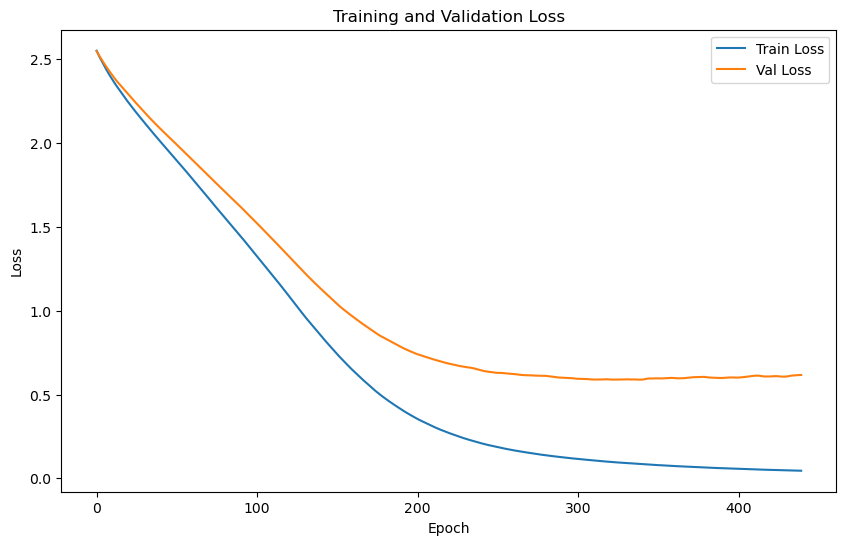

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7205 | Test Accuracy: 78.31%


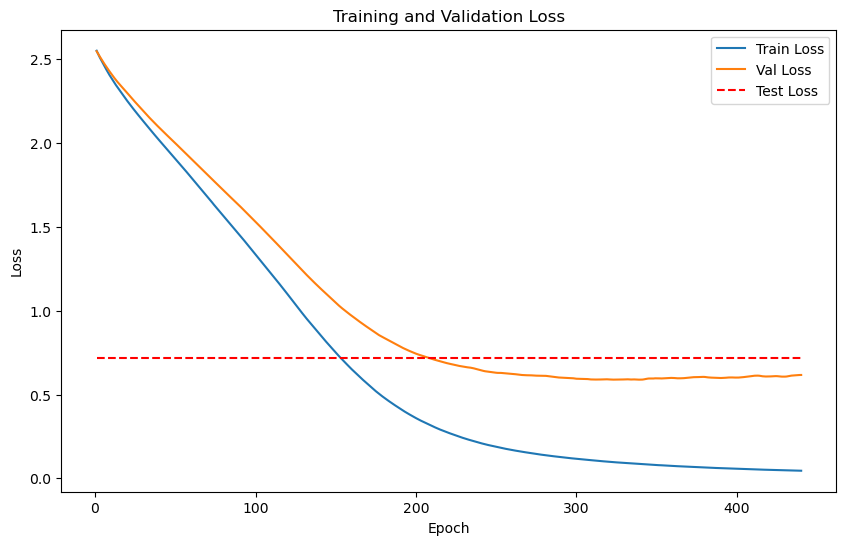

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


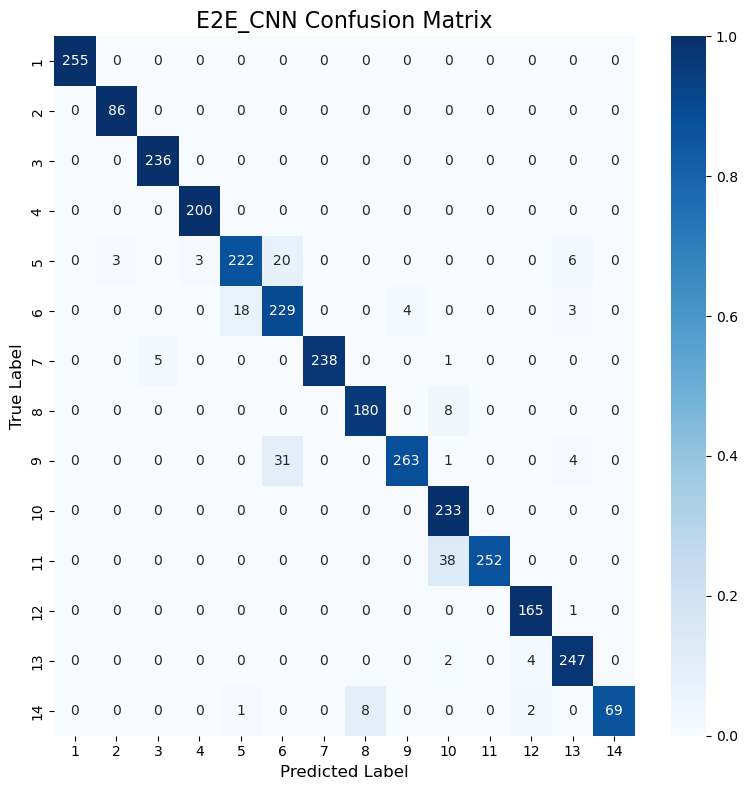

Classification Accuracy: 94.63%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


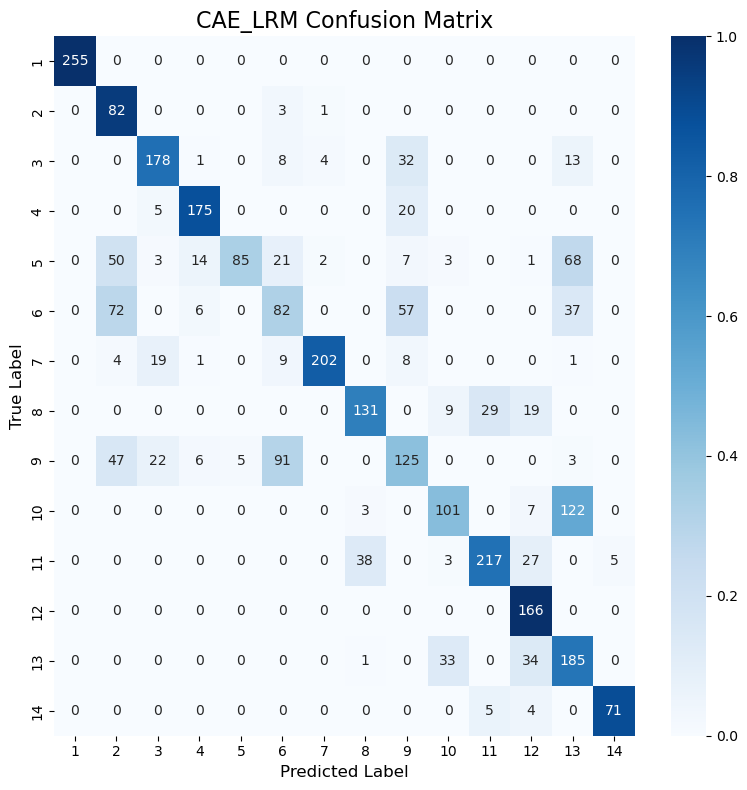

Classification Accuracy: 67.64%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


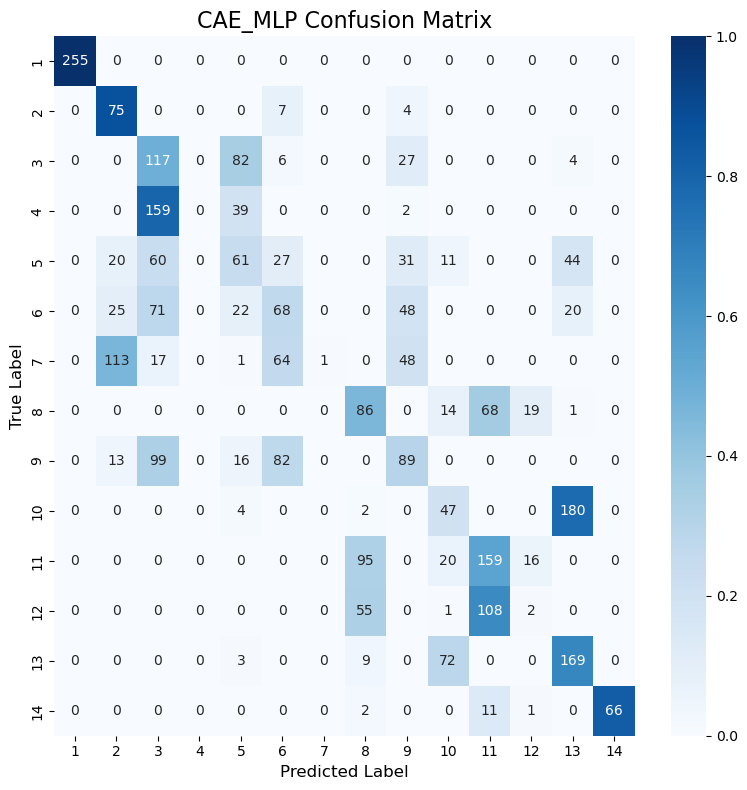

Classification Accuracy: 39.34%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


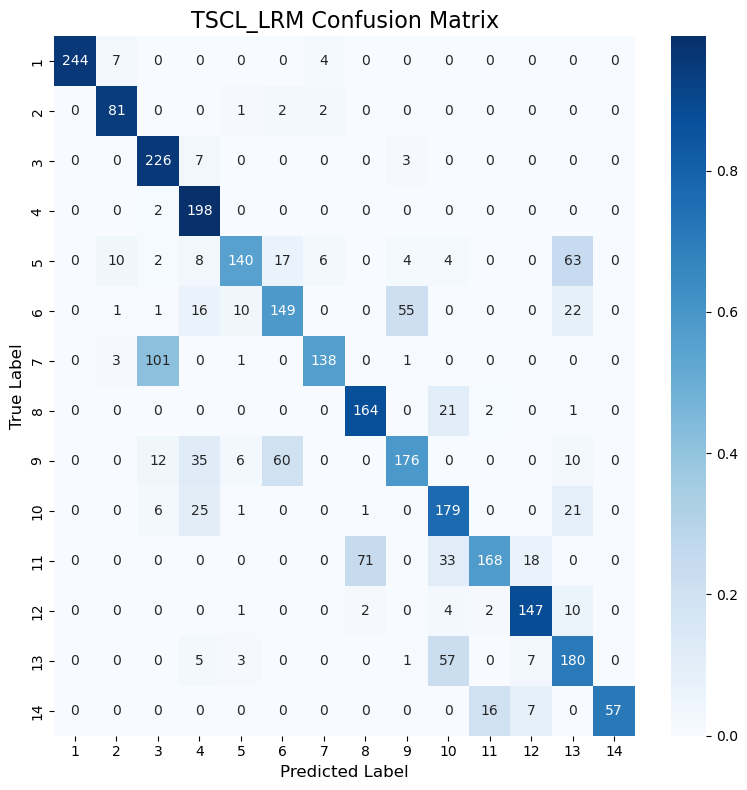

Classification Accuracy: 73.96%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


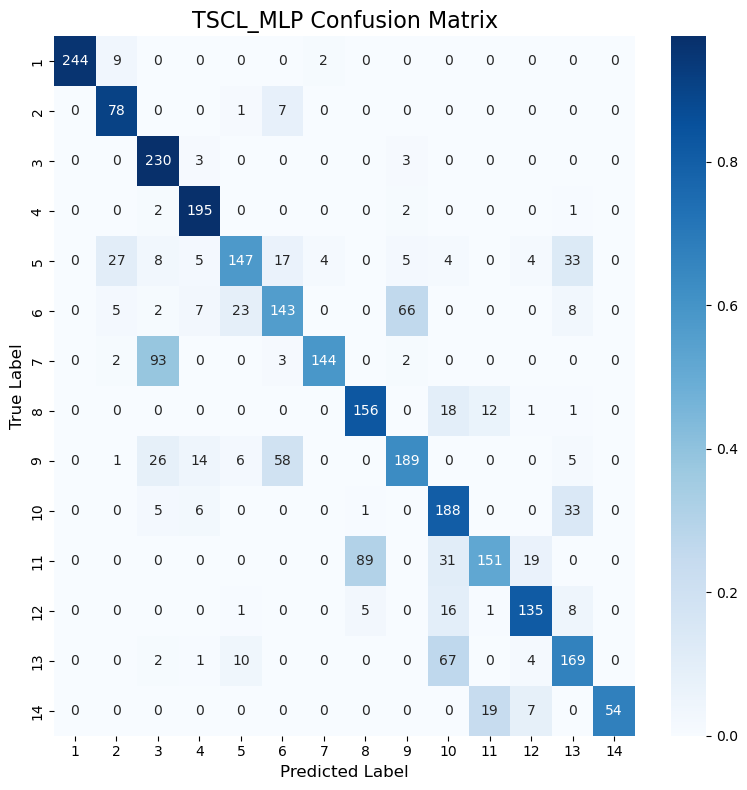

Classification Accuracy: 73.17%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


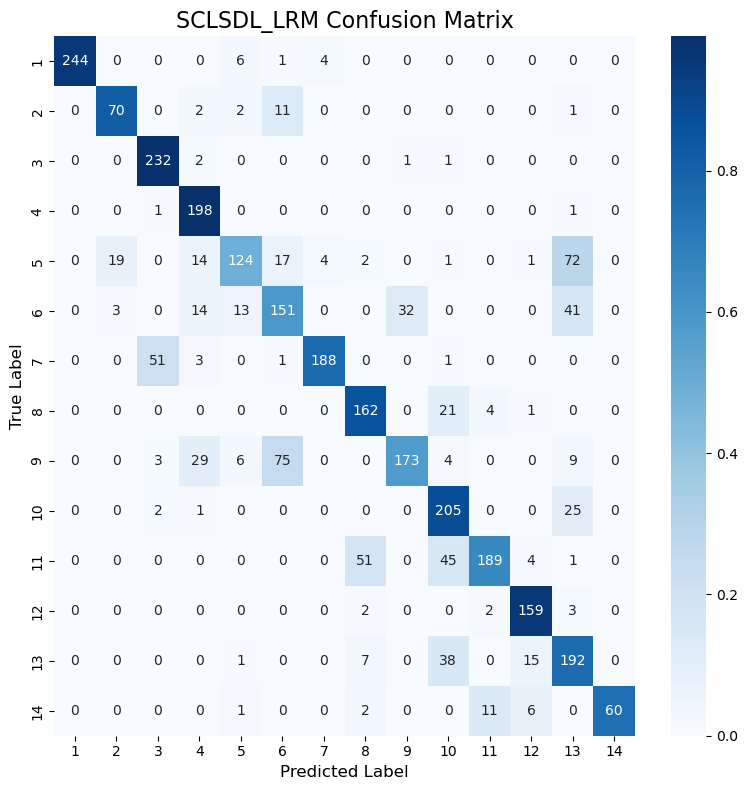

Classification Accuracy: 77.25%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


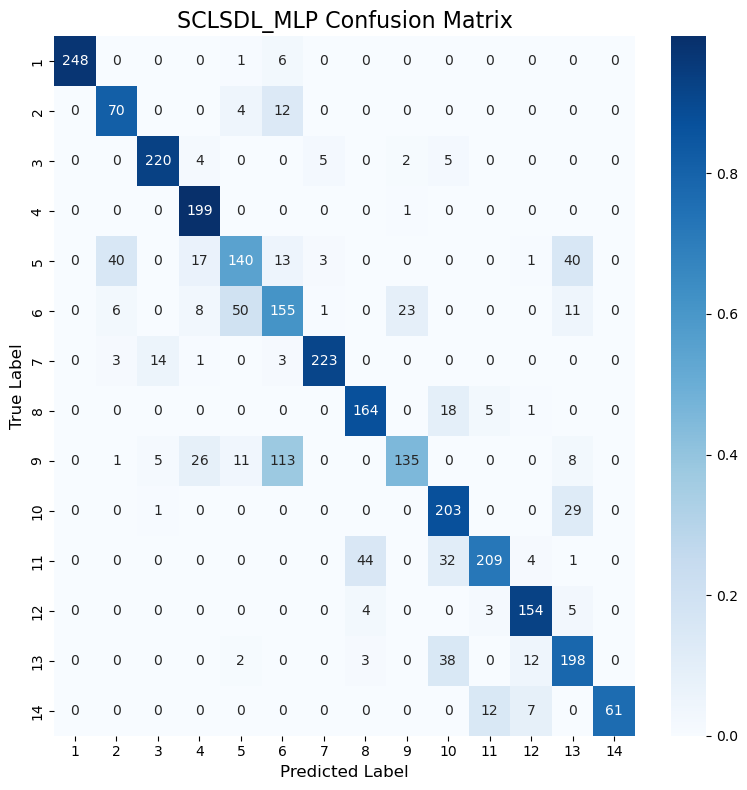

Classification Accuracy: 78.31%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          94.63
1    LRM (CAE)          67.64
2    MLP (CAE)          39.34
3     TSCL LRM          73.96
4     TSCL MLP          73.17
5  SCL_SDL LRM          77.25
6  SCL_SDL MLP          78.31

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          94.63
6  SCL_SDL MLP          78.31
5  SCL_SDL LRM          77.25
3     TSCL LRM          73.96
4     TSCL MLP          73.17
1    LRM (CAE)          67.64
2    MLP (CAE)          39.34
